In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3lenibuz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3lenibuz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=d1f7e5903d18dbc18afa7027df523c57847a58abc36f5de2e04c7051389e8914
  Stored in directory: /tmp/pip-ephem-wheel-cache-00lnlqfv/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 5.0 MB/s eta 0:00:00


In [5]:
!pip install pydantic==1.10.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.1
    Uninstalling pydantic-2.6.1:
      Successfully uninstalled pydantic-2.6.1


In [6]:
!mkdir /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/DentalPanoramicXrays.zip /content/data
!cp /content/drive/MyDrive/DentalImages/ToothSegDataset/Masks.zip /content/data

(3, 1024, 1024)
(1300, 3100, 3)


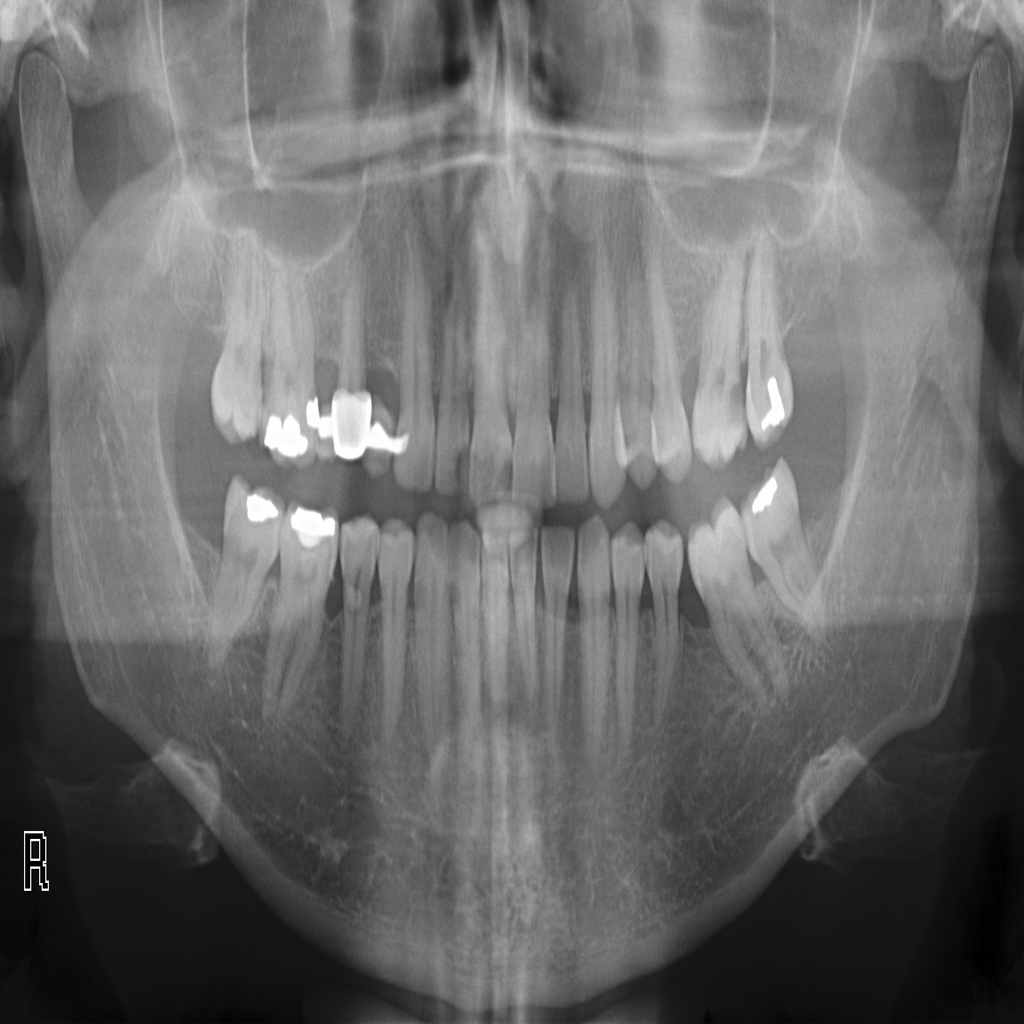

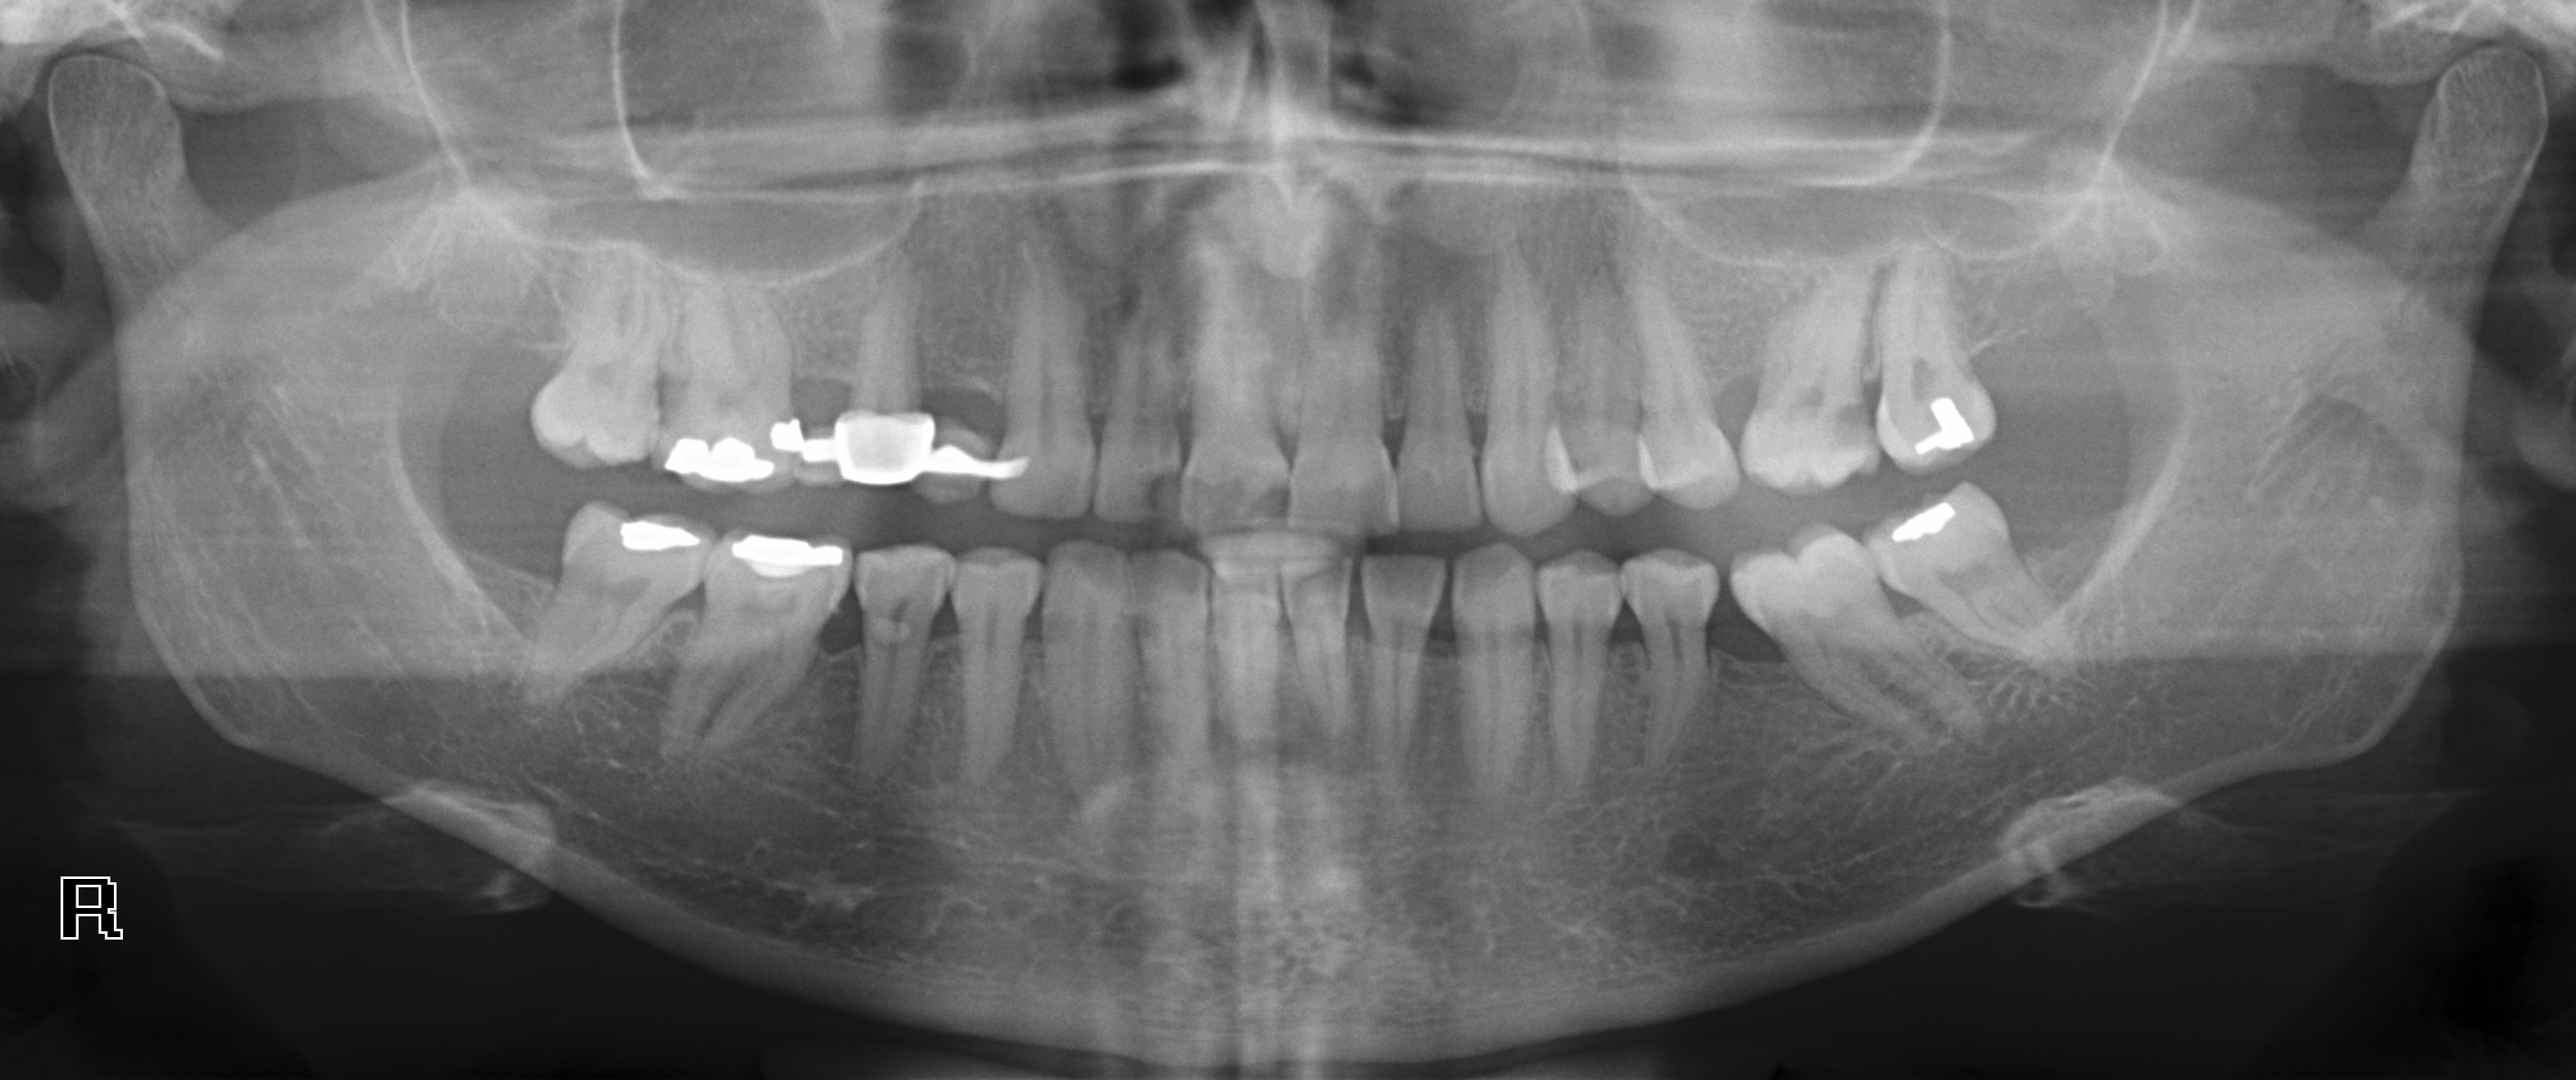

In [37]:
import cv2
import numpy as np
import os
import torch
from google.colab.patches import cv2_imshow
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted

def convert_to_three_channel(img):
  if len(img.shape) <= 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  img = np.moveaxis(img, -1, 0)
  return img

def convert_to_three_channel_yolo(img):
  if len(img.shape) <= 2:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img

def convert_to_one_channel(img):
  if len(img.shape) > 2:
    img = img[:,:,0]
  return img

def extract_image_paths(path, zip_name, folder_name, save_path):
  full_path = os.path.join(path, zip_name)
  ZipFile(full_path).extractall(save_path)
  unzipped_path = os.path.join(path, folder_name)
  dirs=natsorted(os.listdir(unzipped_path))
  return dirs

def load_images(resize_shape, path, zip_name, folder_name, save_path, convert_function):

    dirs = extract_image_paths(path, zip_name, folder_name, save_path)

    images = []

    for i in range(len(dirs)):
        img=Image.open(os.path.join(path, folder_name, dirs[i]))
        img=img.resize((resize_shape), Image.LANCZOS )

        img = convert_function(np.asarray(img))
        images.append(img)

    images = np.array(images)
    return images

def load_yolo_images(path, resize_shape):
  image_names = natsorted(os.listdir(path))
  images=[]

  for image_name in image_names:
    img = Image.open(os.path.join(path, image_name))
    if len(images)>0:
      img = img.resize(resize_shape, Image.LANCZOS)

    img = convert_to_three_channel_yolo(np.asarray(img))

    img = np.array(img)
    images.append(img)

  images = np.array(images)
  return images



PATH = "/content/data/"
X = load_images((1024, 1024), PATH, "DentalPanoramicXrays.zip",'Images/', "/content/data", convert_to_three_channel)
Y = load_images((1024, 1024), PATH, "Masks.zip", "Masks/", "/content/data/Masks", convert_to_one_channel)
X_yolo = load_yolo_images("/content/data/Images",(3100,1300))

x_train = X[:88]
x_val = X[88:]
y_train = Y[:88]
y_val = Y[88:]
x_train_yolo = X_yolo[:88]
x_val_yolo = X_yolo[88:]

print(x_train[3].shape)
print(x_train_yolo[3].shape)
cv2_imshow(x_train[3,0])
cv2_imshow(x_train_yolo[3])






In [34]:
def get_fixed_coordinates(box, image):

  x_center = box[0].numpy()
  y_center = box[1].numpy()
  width = box[2].numpy()
  height = box[3].numpy()
  x_center *= image.shape[0]
  y_center *= image.shape[1]
  width *= image.shape[0]
  height *= image.shape[1]

  x1 = int(x_center - width / 2)
  y1 = int(y_center - height / 2)
  x2 = int(x_center + width / 2)
  y2 = int(y_center + height / 2)

  return x1, y1, x2, y2


  0%|          | 0/100 [00:00<?, ?it/s]


0: 288x640 30 tooths, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


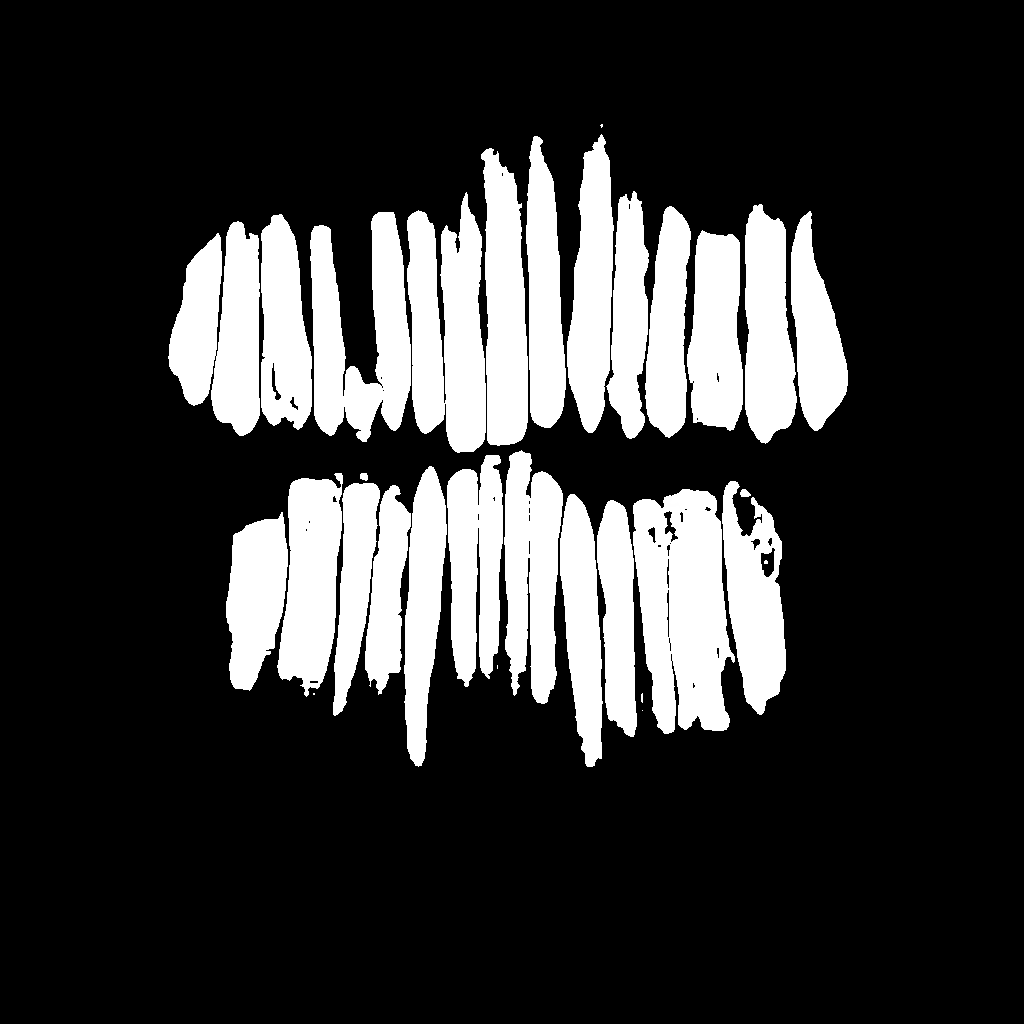

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  1%|          | 1/100 [00:05<09:45,  5.92s/it]

Loss: 0.05270873010158539

0: 288x640 31 tooths, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


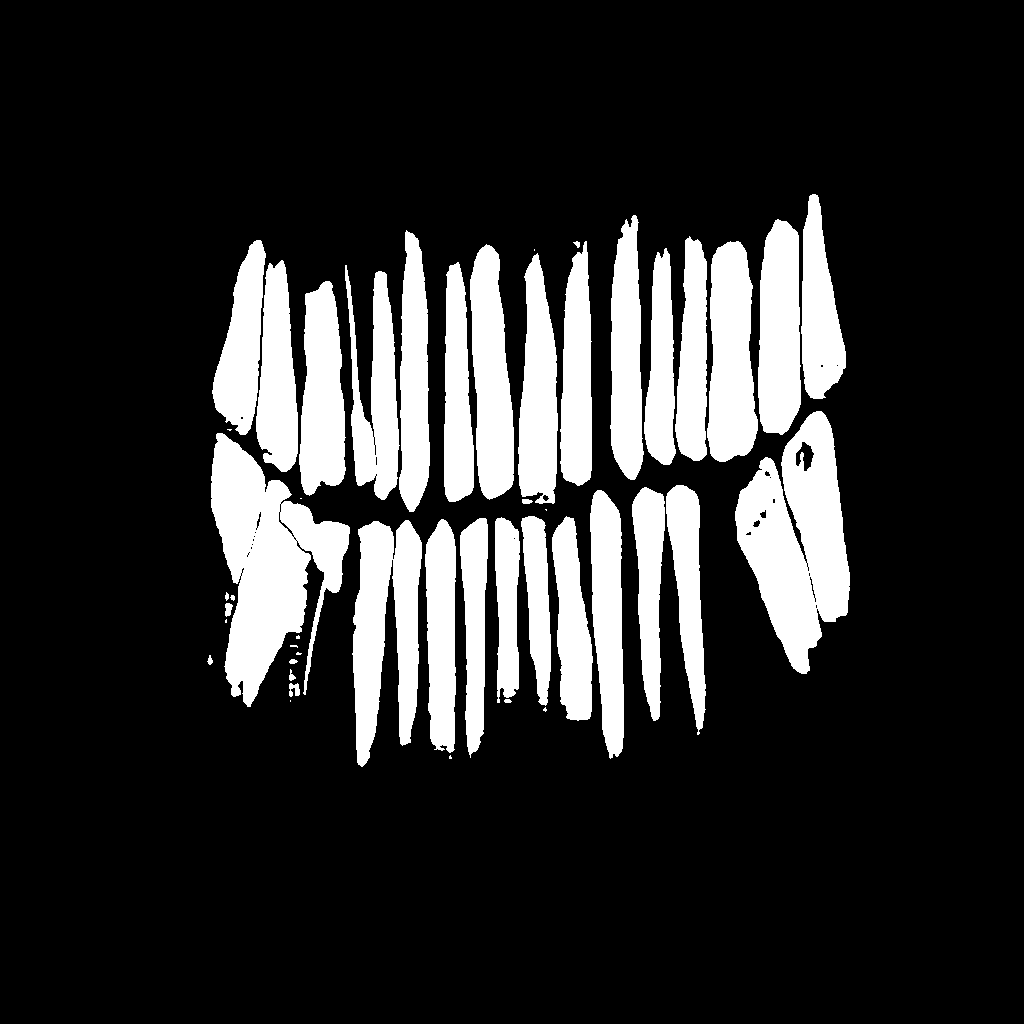

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  2%|▏         | 2/100 [00:13<11:18,  6.93s/it]

Loss: 0.047028180211782455

0: 288x640 28 tooths, 10.1ms
Speed: 1.9ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


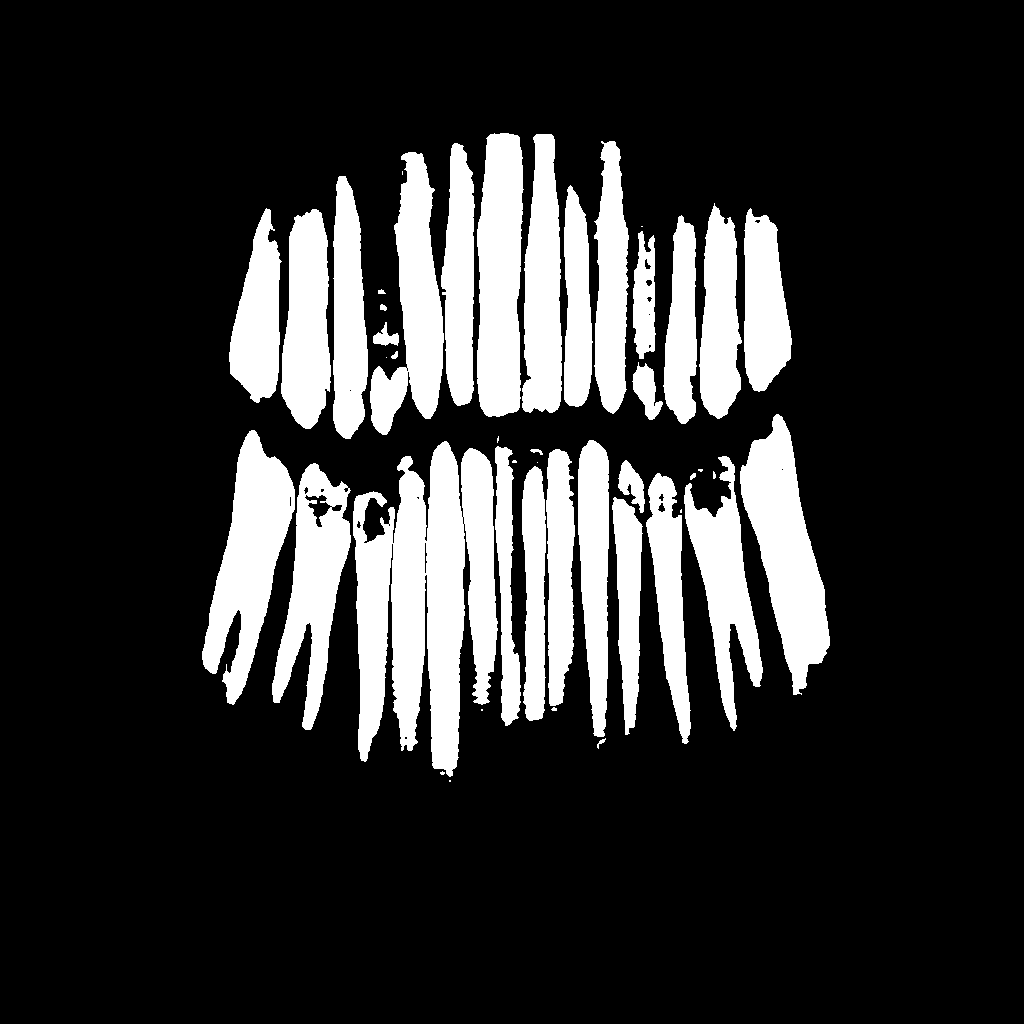

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  3%|▎         | 3/100 [00:19<10:16,  6.35s/it]

Loss: 0.05817035585641861

0: 288x640 28 tooths, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


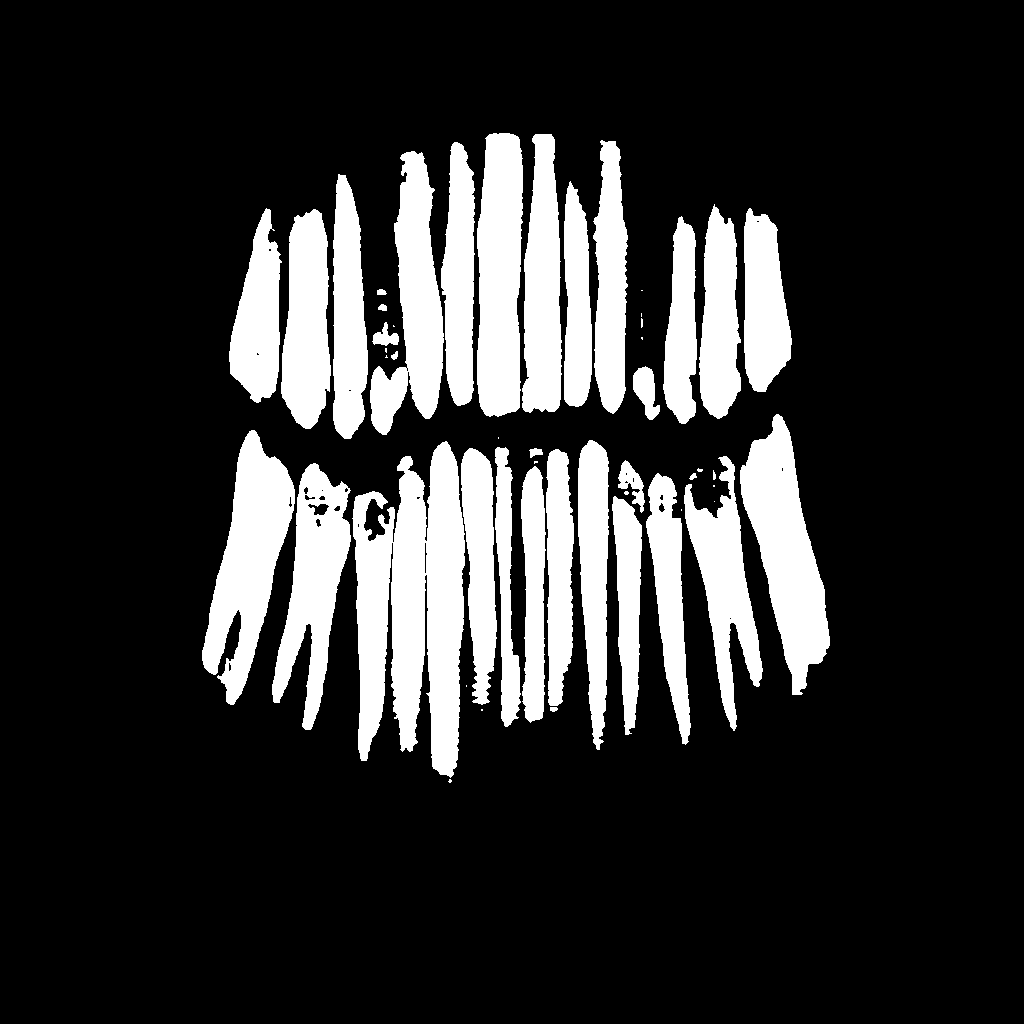

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  4%|▍         | 4/100 [00:26<10:40,  6.67s/it]

Loss: 0.06106172874569893

0: 288x640 27 tooths, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


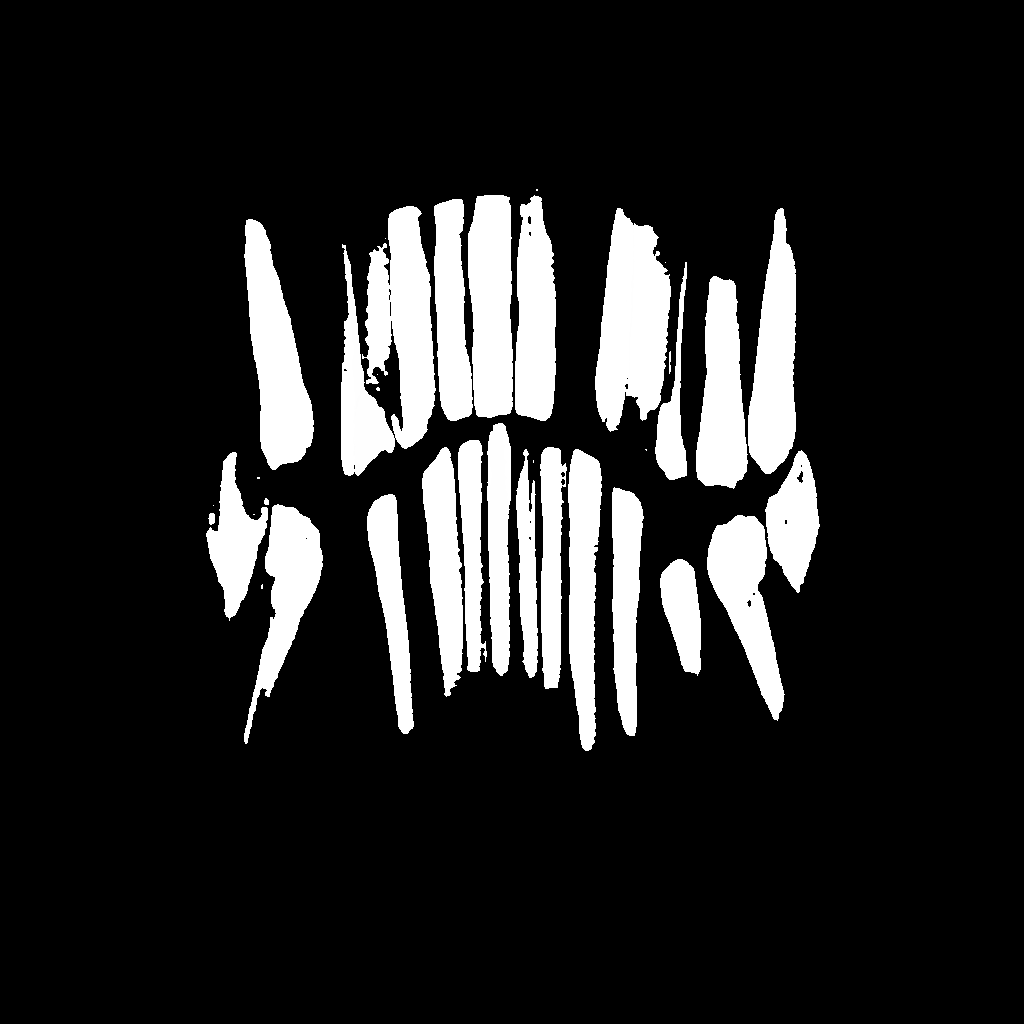

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  5%|▌         | 5/100 [00:32<10:18,  6.51s/it]

Loss: 0.057039398699998856

0: 288x640 27 tooths, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


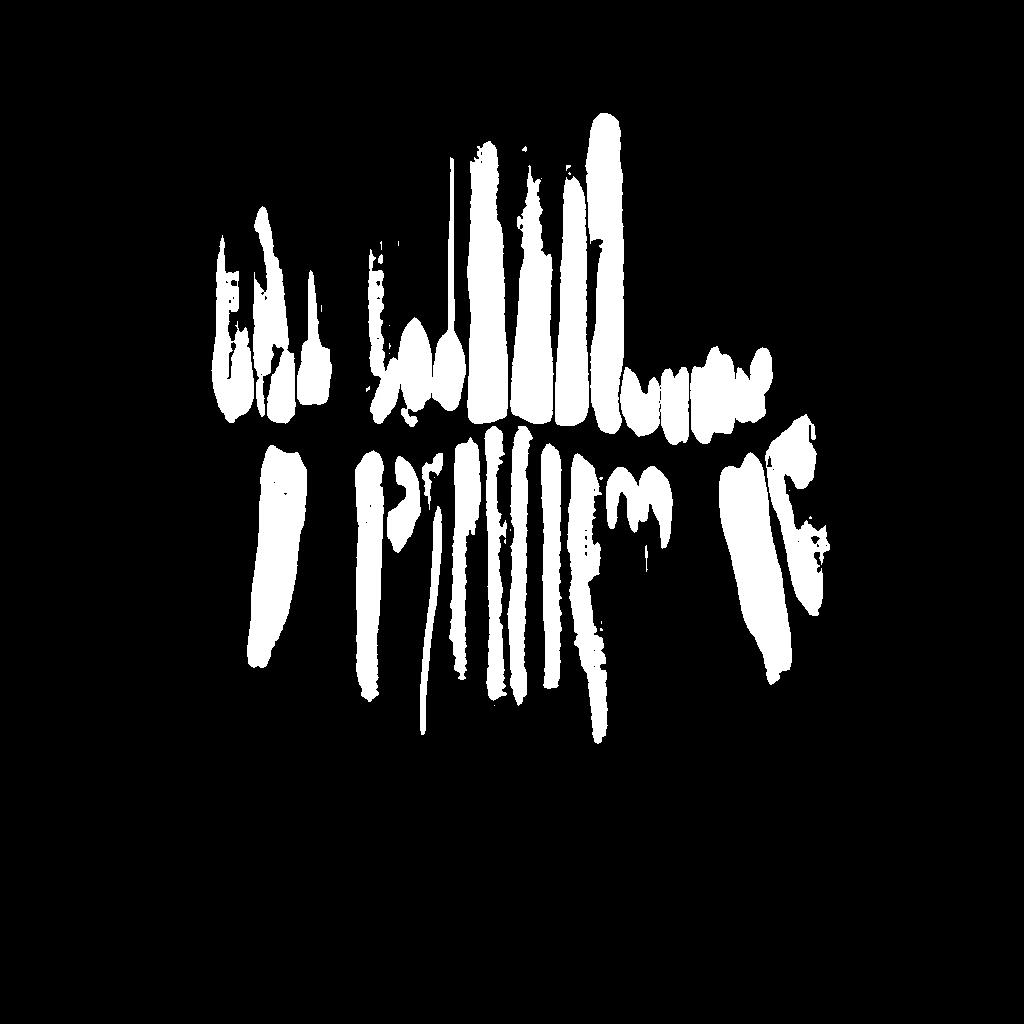

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  6%|▌         | 6/100 [00:39<10:27,  6.67s/it]

Loss: 0.08706586062908173

0: 288x640 20 tooths, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


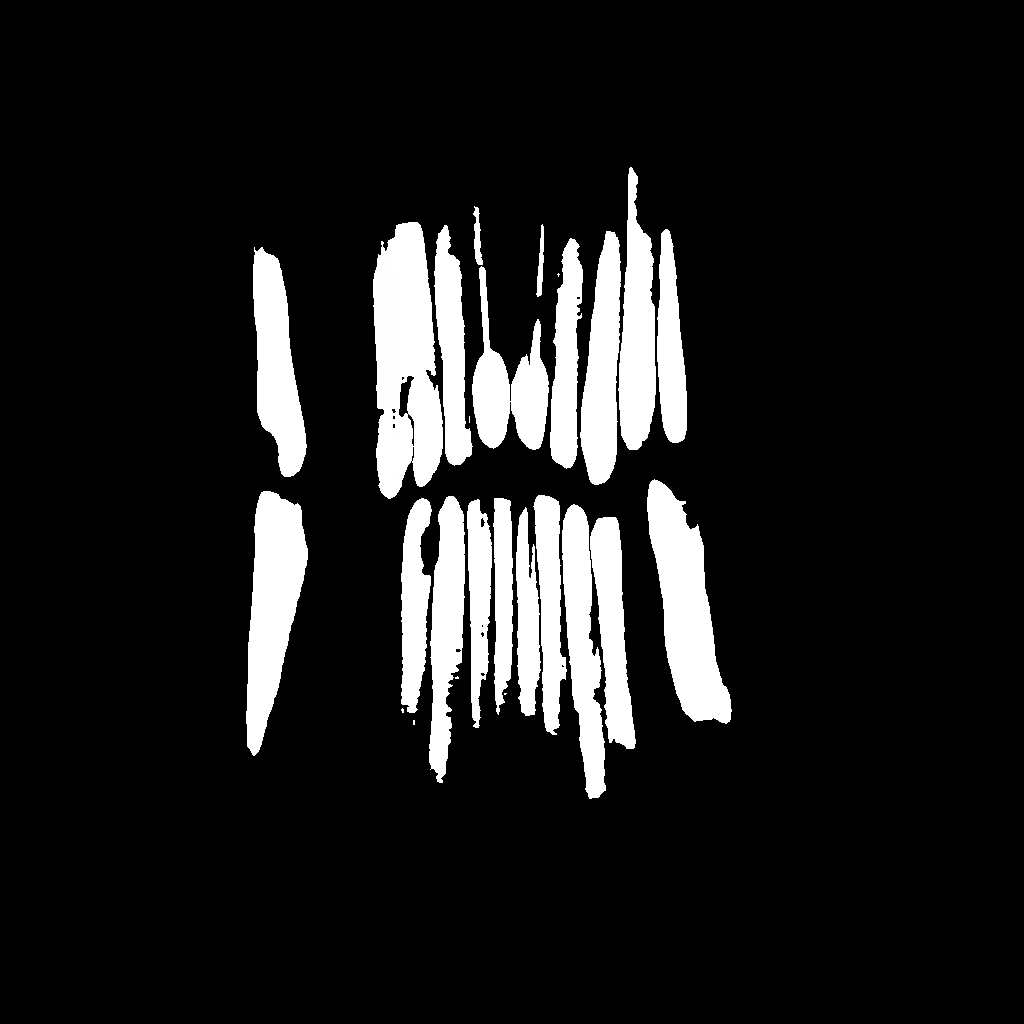

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  7%|▋         | 7/100 [00:43<09:05,  5.86s/it]

Loss: 0.04182317107915878

0: 288x640 30 tooths, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


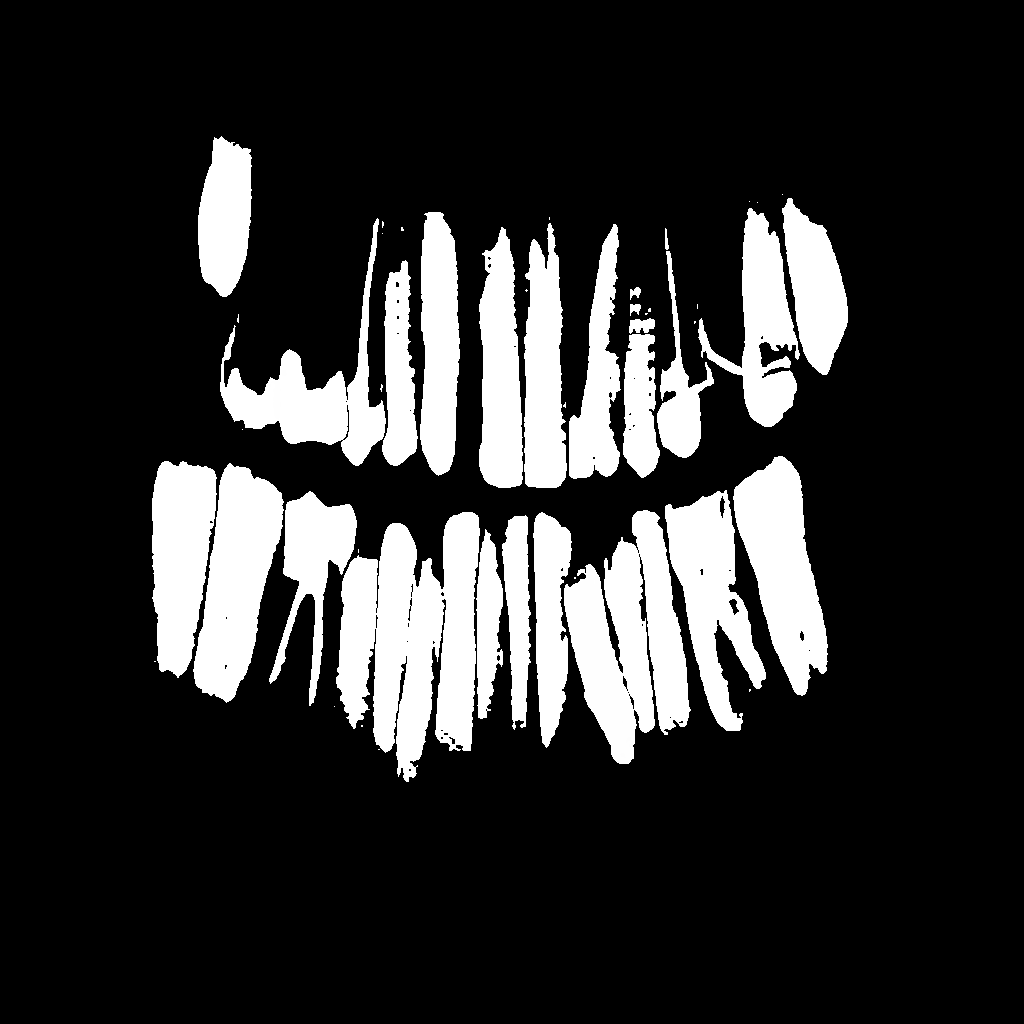

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  8%|▊         | 8/100 [00:50<09:35,  6.26s/it]

Loss: 0.07531052827835083

0: 288x640 31 tooths, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


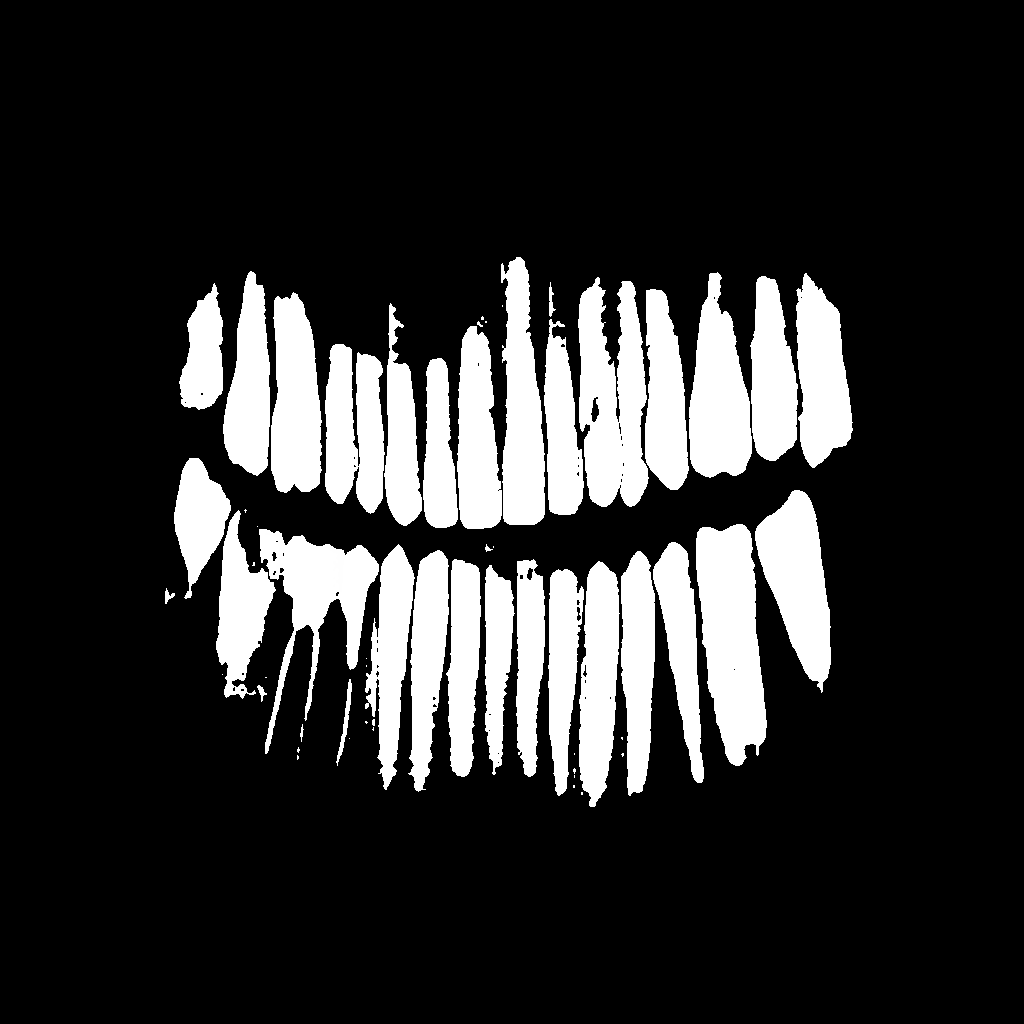

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


  9%|▉         | 9/100 [00:57<09:27,  6.24s/it]

Loss: 0.05458323284983635

0: 288x640 21 tooths, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


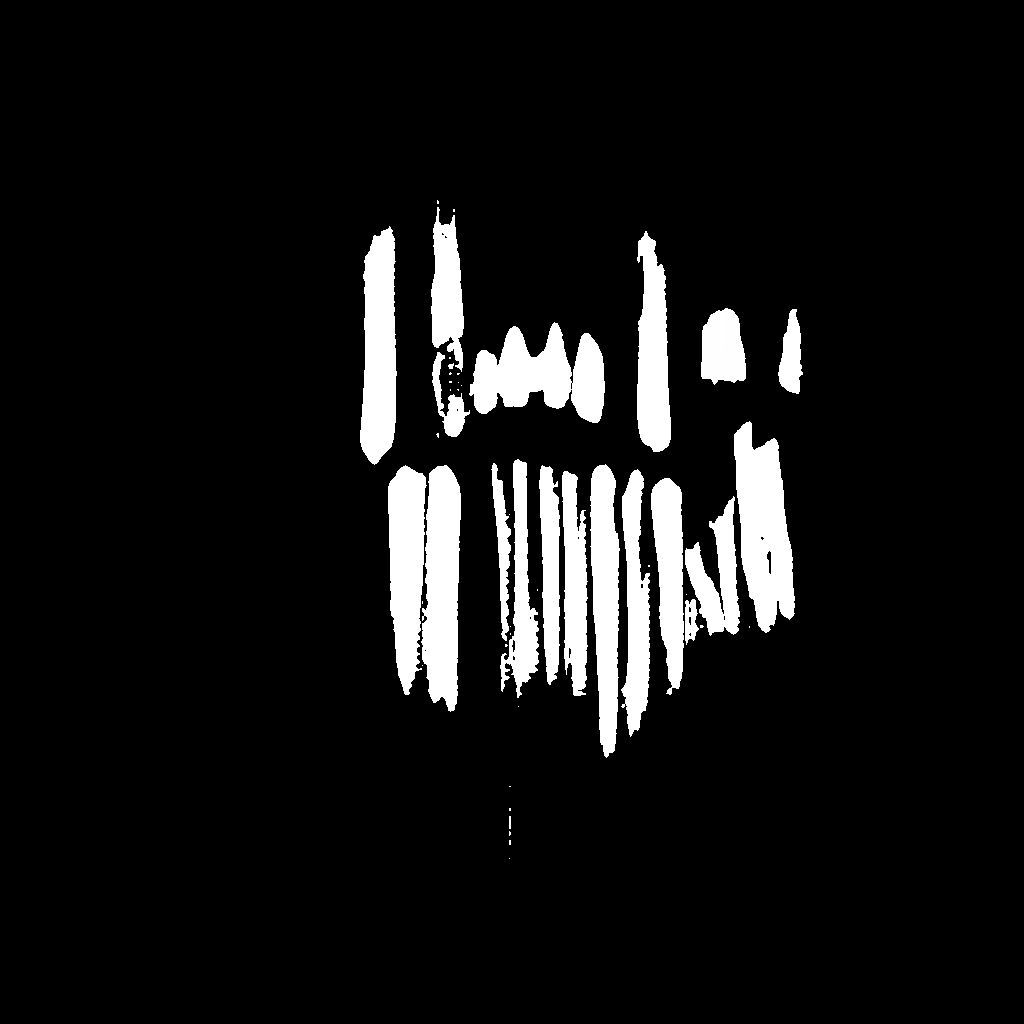

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 10%|█         | 10/100 [01:01<08:43,  5.82s/it]

Loss: 0.04169205576181412

0: 288x640 32 tooths, 20.4ms
Speed: 2.8ms preprocess, 20.4ms inference, 2.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


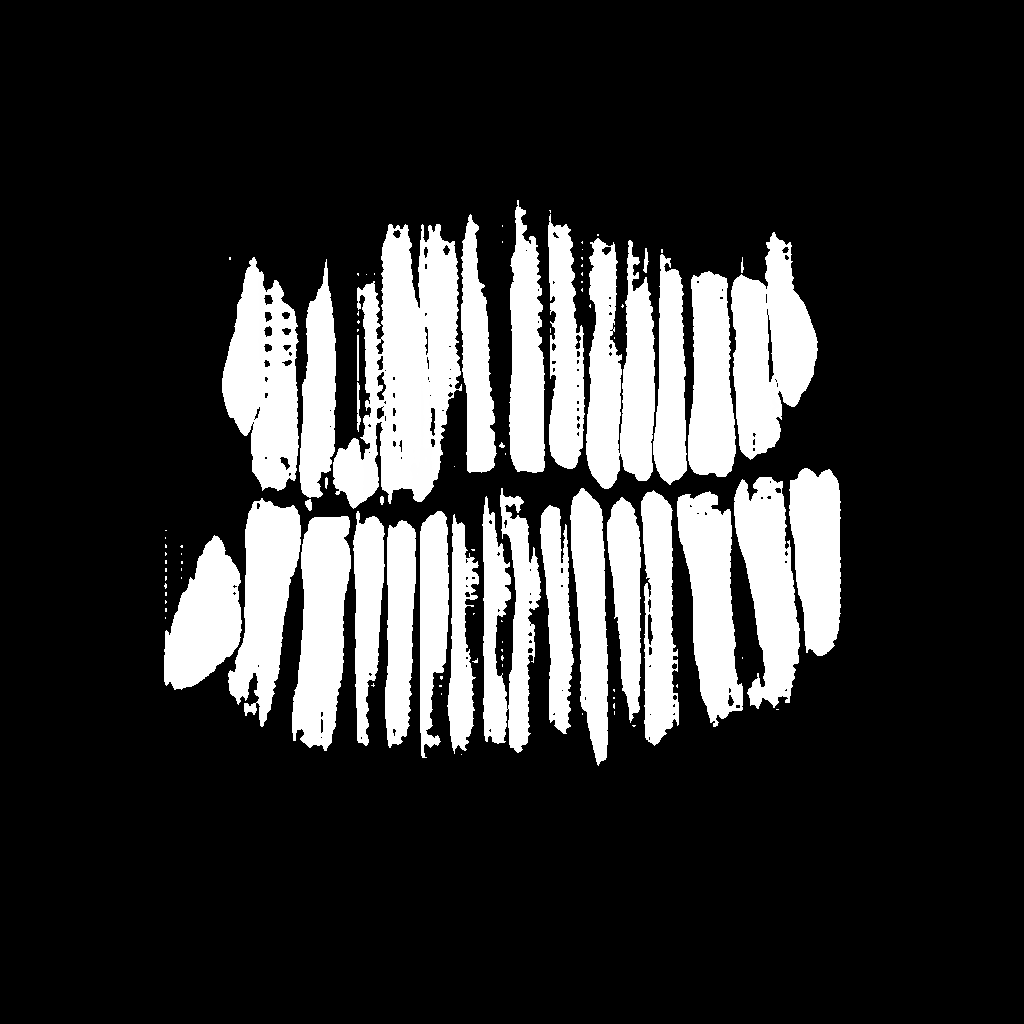

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 11%|█         | 11/100 [01:08<09:09,  6.18s/it]

Loss: 0.0701923817396164

0: 288x640 32 tooths, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


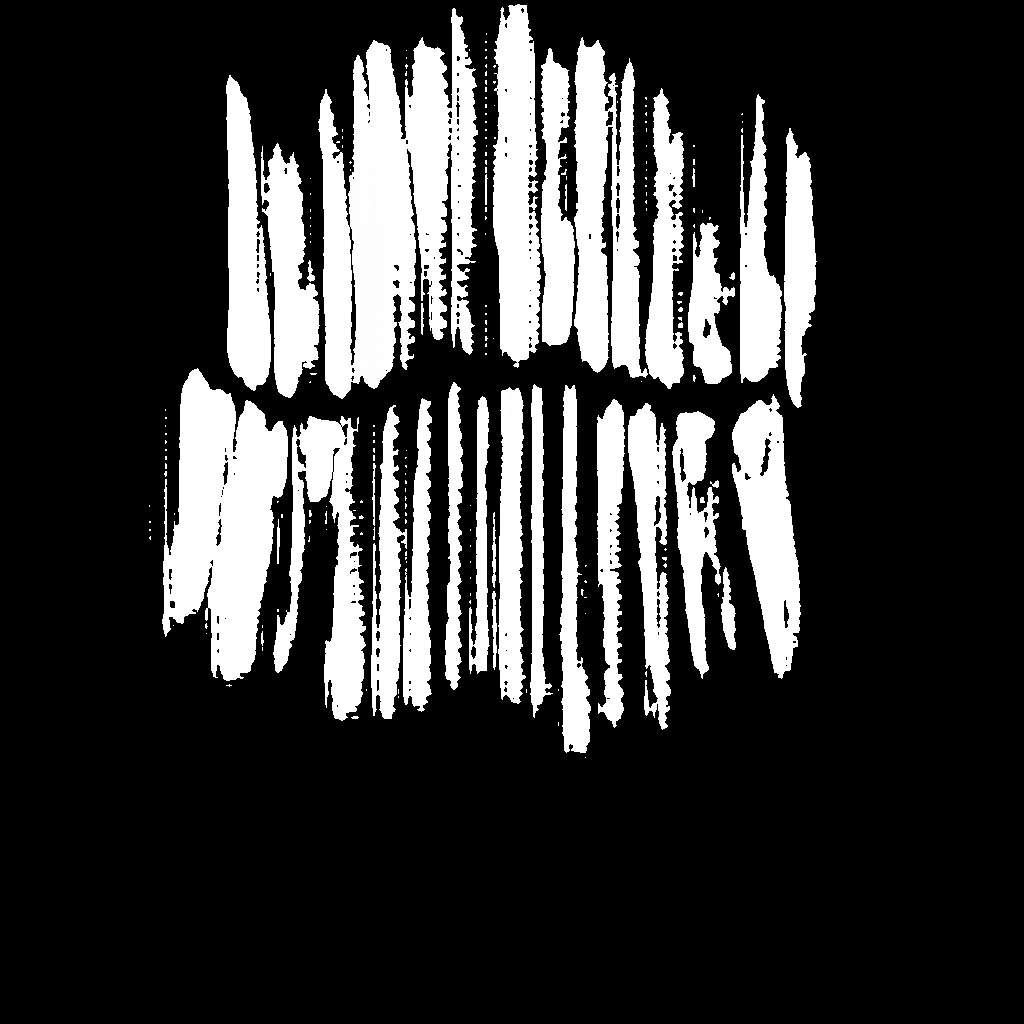

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 12%|█▏        | 12/100 [01:16<09:34,  6.53s/it]

Loss: 0.1604662835597992

0: 288x640 29 tooths, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


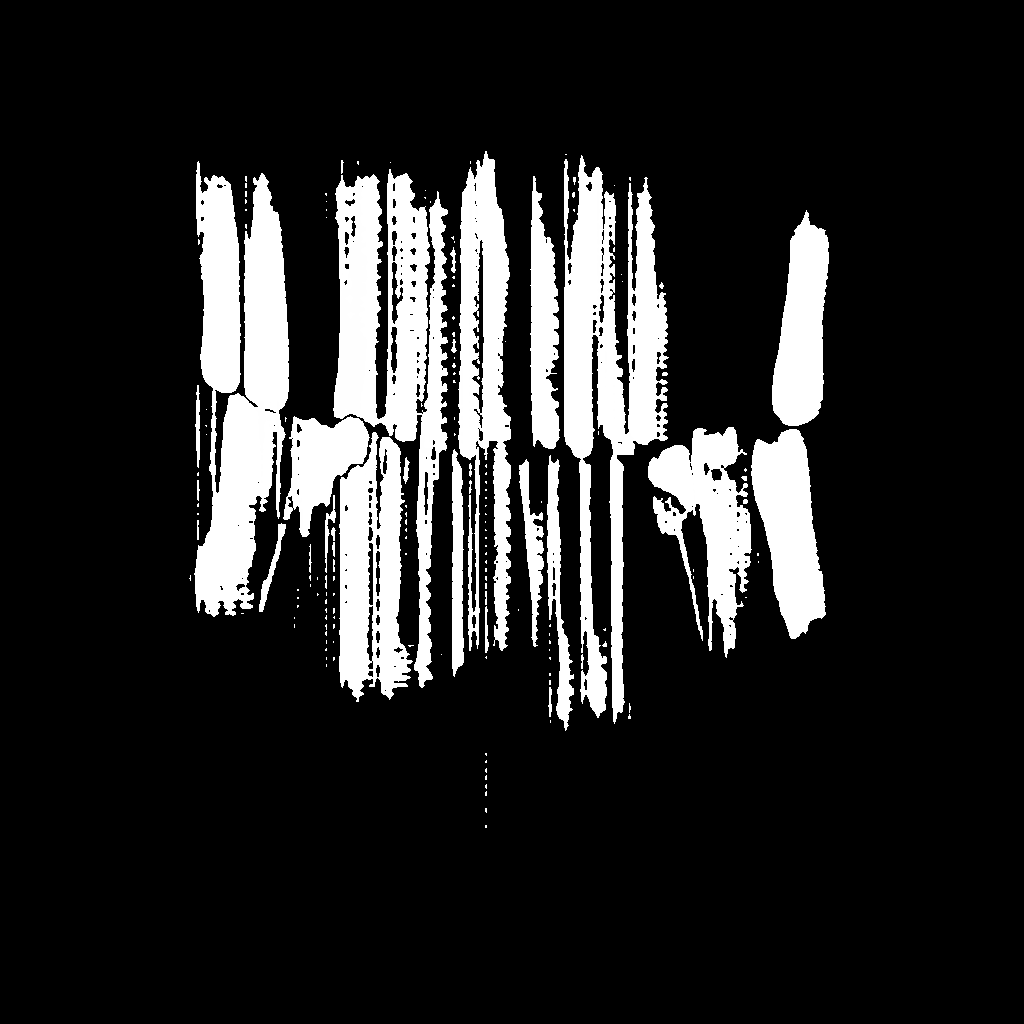

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 13%|█▎        | 13/100 [01:22<09:09,  6.31s/it]

Loss: 0.10448535531759262

0: 288x640 31 tooths, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


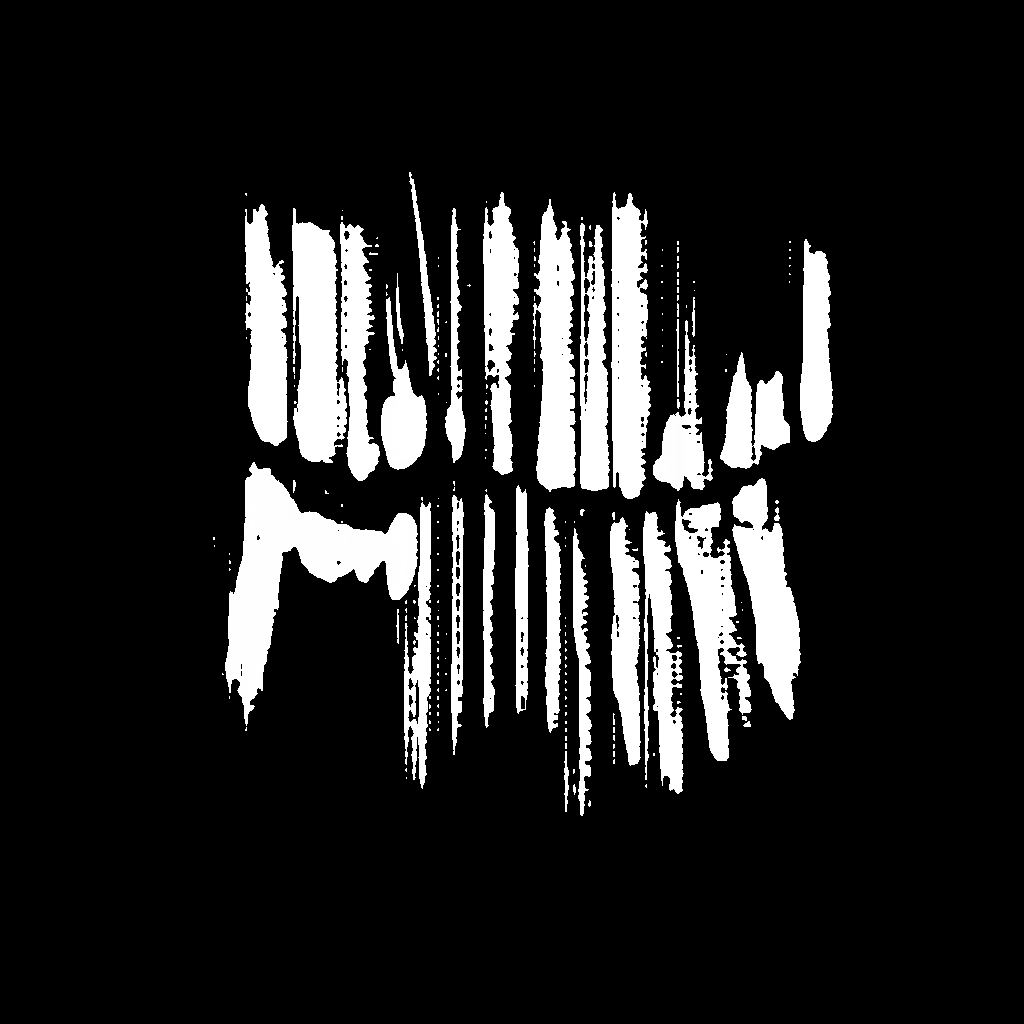

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 14%|█▍        | 14/100 [01:29<09:23,  6.55s/it]

Loss: 0.13758888840675354

0: 288x640 31 tooths, 13.1ms
Speed: 2.6ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


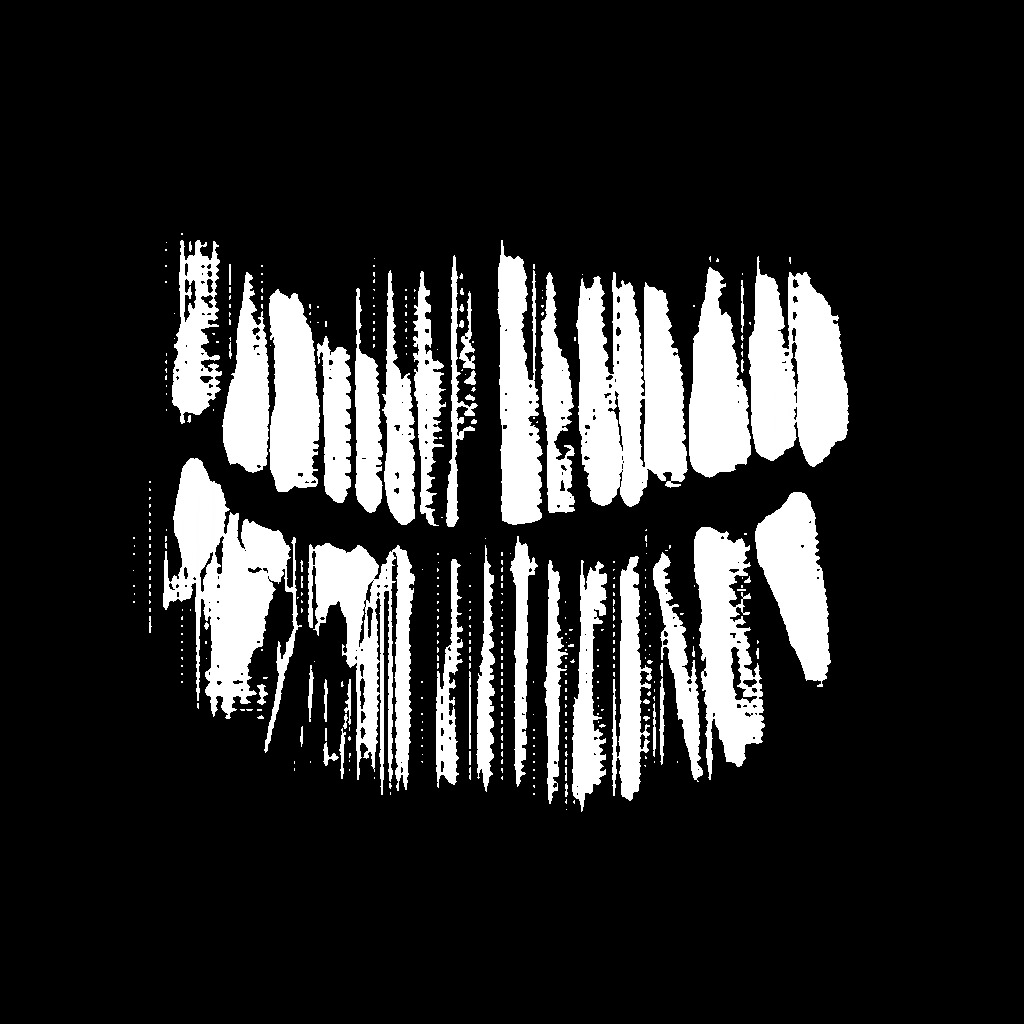

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 15%|█▌        | 15/100 [01:35<09:09,  6.46s/it]

Loss: 0.11299547553062439

0: 288x640 32 tooths, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


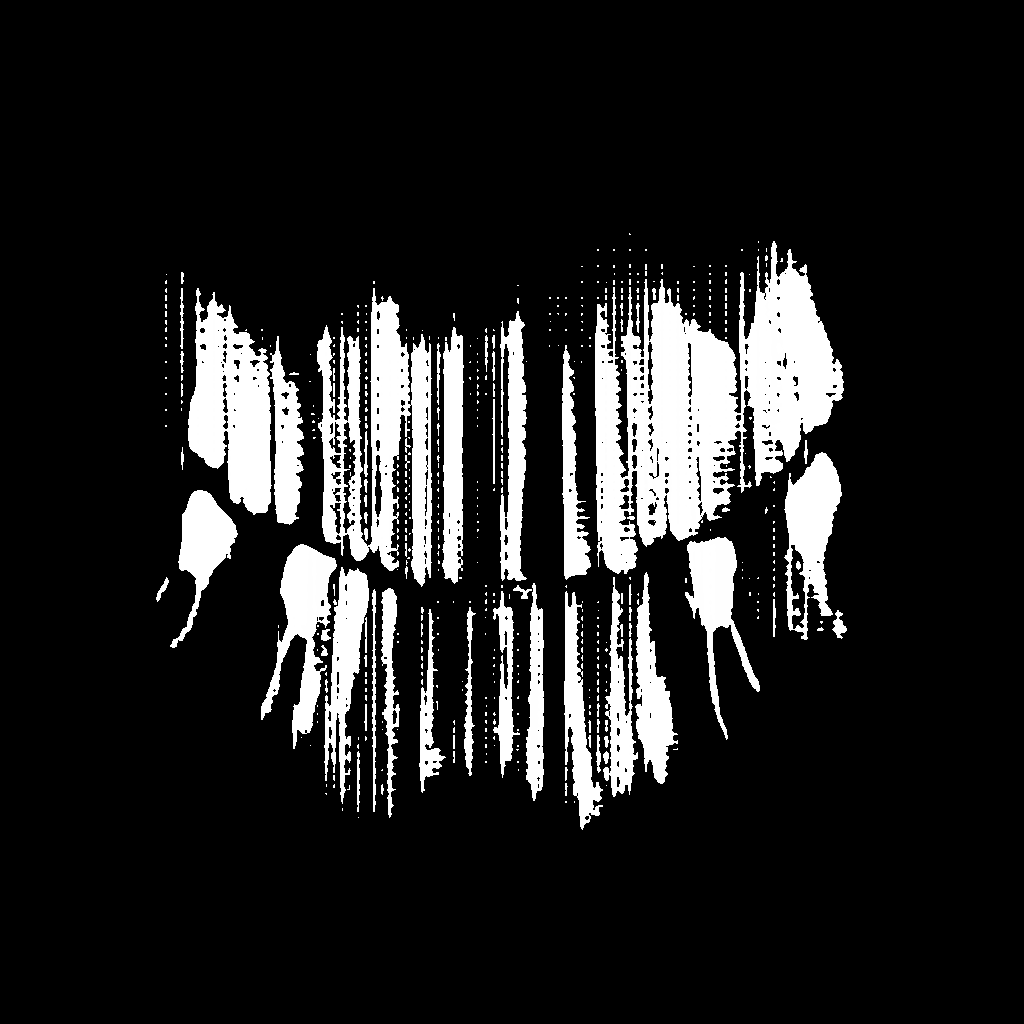

Max, min in prediction tensor(4., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 16%|█▌        | 16/100 [01:43<09:31,  6.80s/it]

Loss: 0.1539279669523239

0: 288x640 25 tooths, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


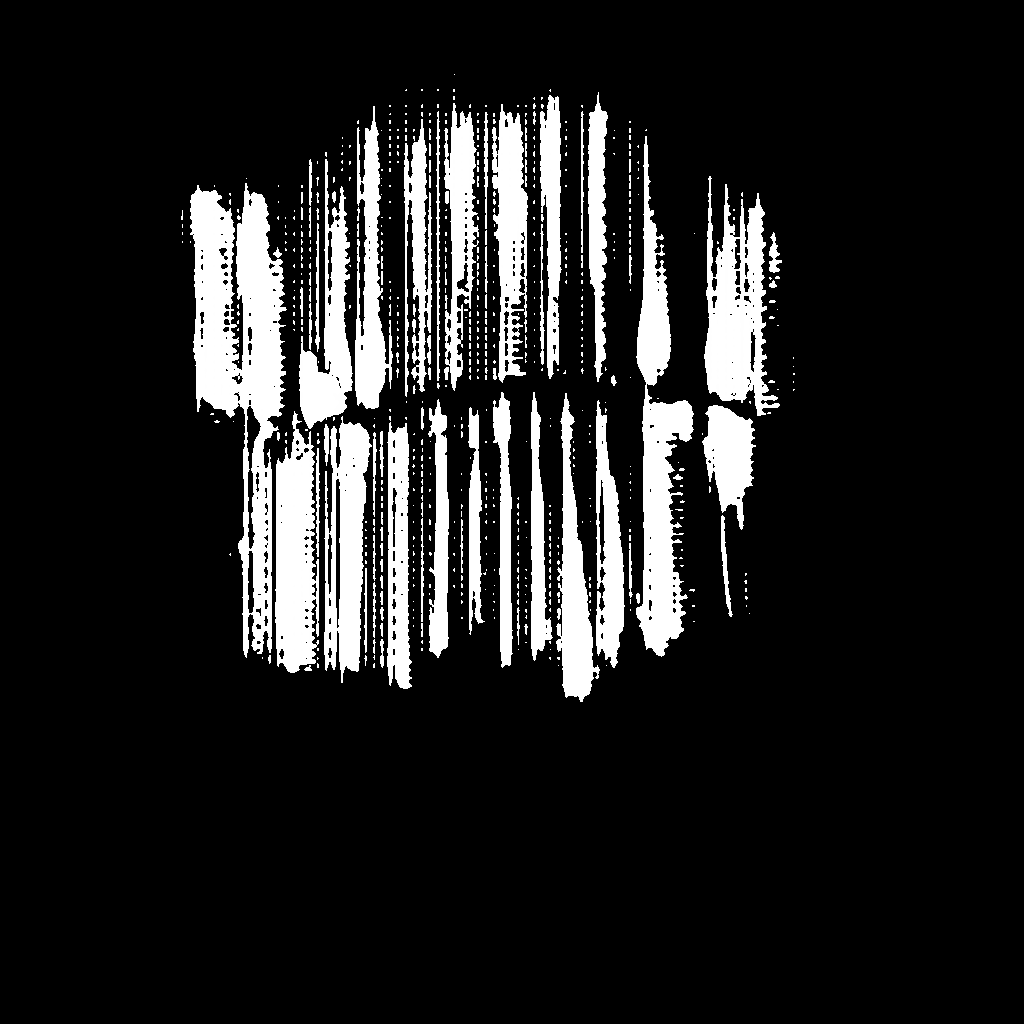

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 17%|█▋        | 17/100 [01:48<08:43,  6.30s/it]

Loss: 0.15181489288806915

0: 288x640 30 tooths, 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


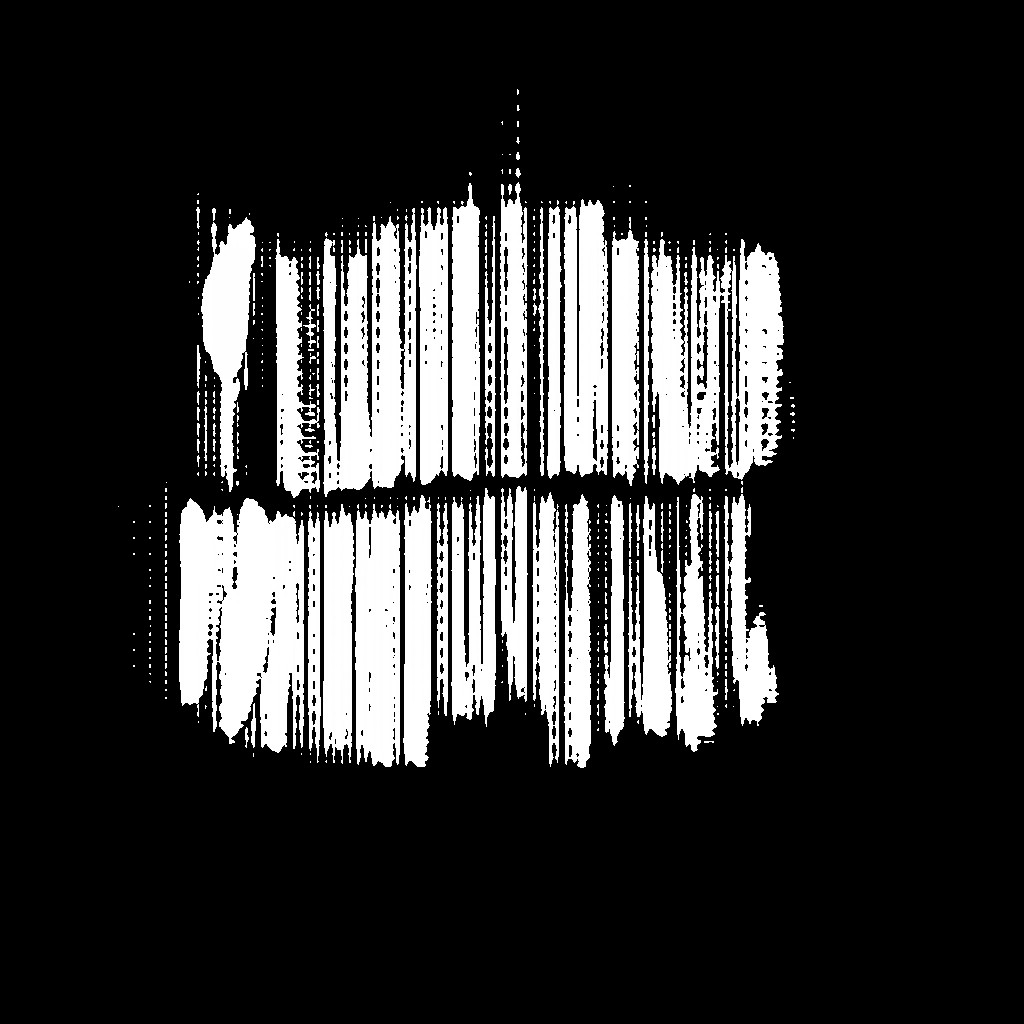

Max, min in prediction tensor(5., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 18%|█▊        | 18/100 [01:54<08:47,  6.43s/it]

Loss: 0.2043062448501587

0: 288x640 32 tooths, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


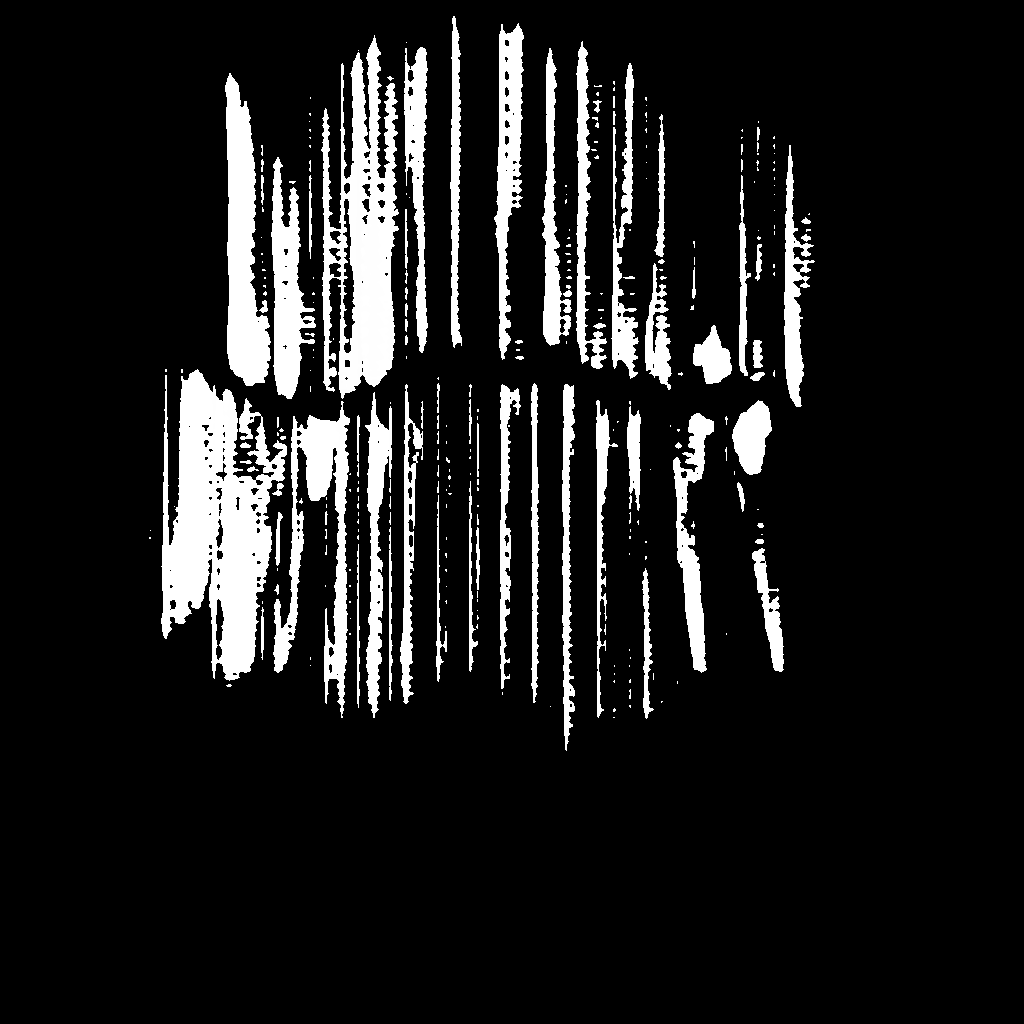

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 19%|█▉        | 19/100 [02:04<09:52,  7.31s/it]

Loss: 0.21702130138874054

0: 288x640 34 tooths, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


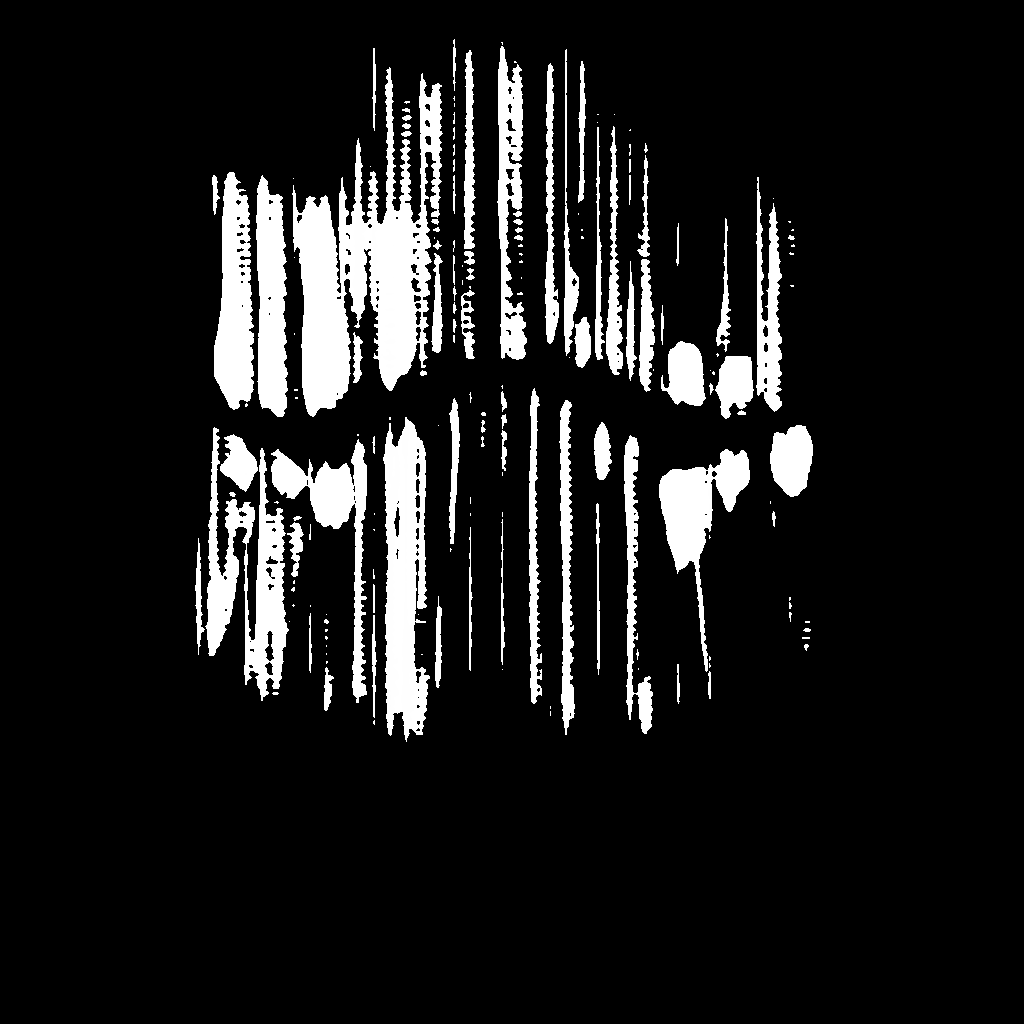

Max, min in prediction tensor(3., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 20%|██        | 20/100 [02:12<10:07,  7.60s/it]

Loss: 0.1796211451292038

0: 288x640 27 tooths, 10.7ms
Speed: 2.6ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


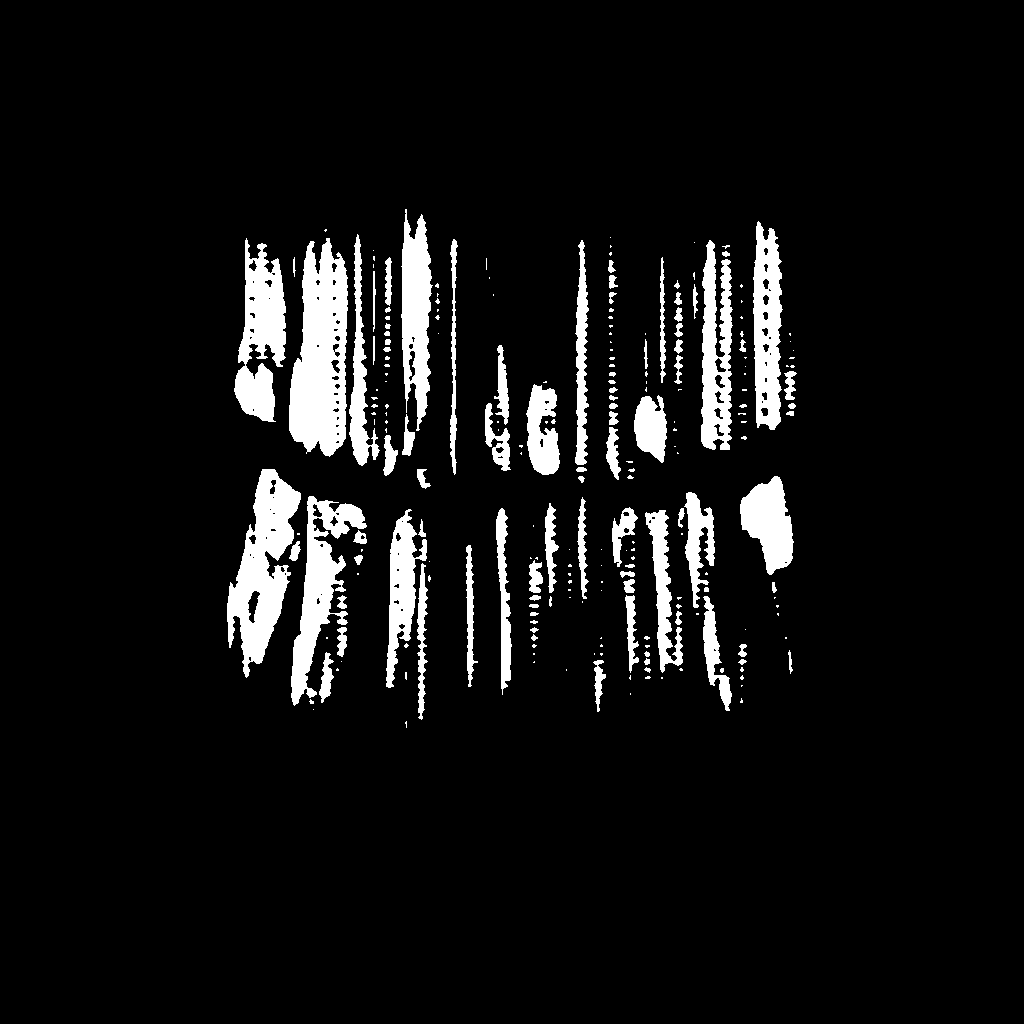

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 21%|██        | 21/100 [02:18<09:09,  6.96s/it]

Loss: 0.12250001728534698

0: 288x640 25 tooths, 10.7ms
Speed: 2.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


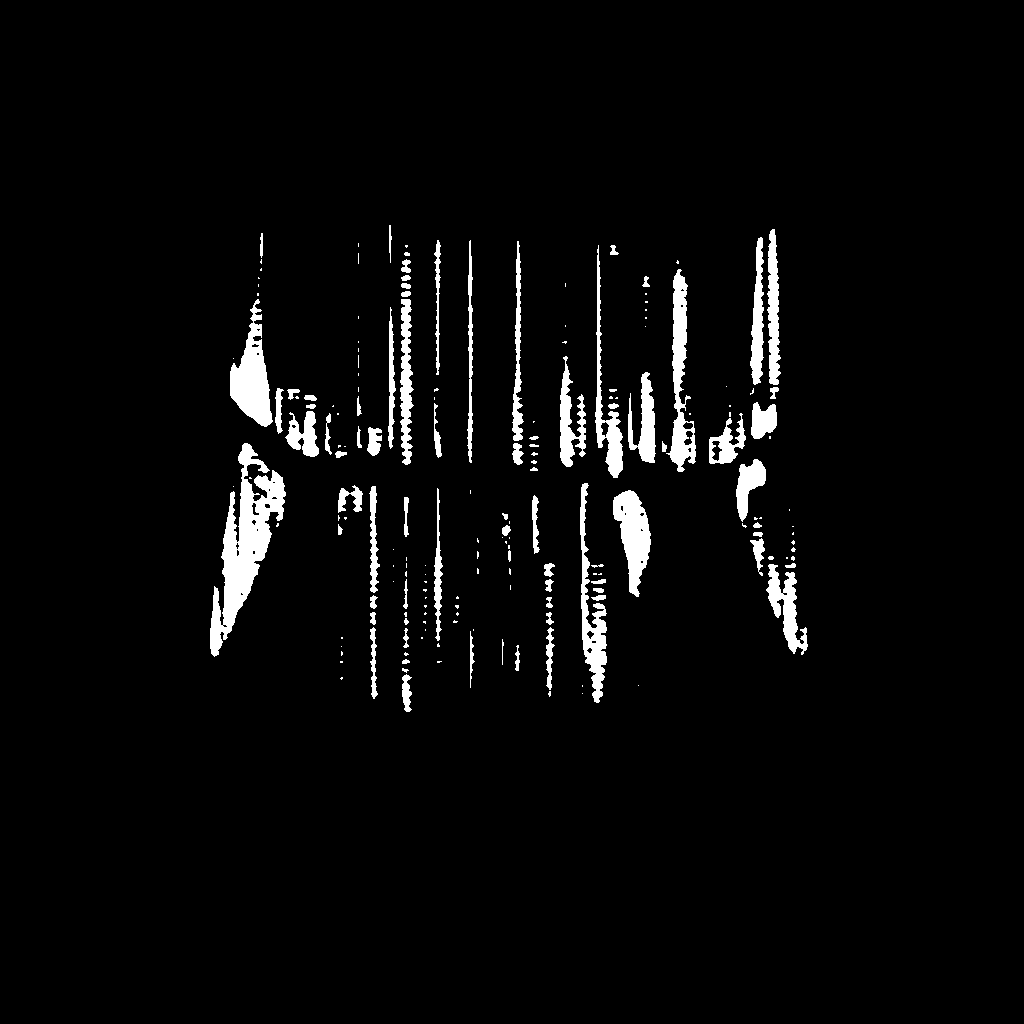

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 22%|██▏       | 22/100 [02:24<08:47,  6.76s/it]

Loss: 0.12577807903289795

0: 288x640 32 tooths, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 3.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


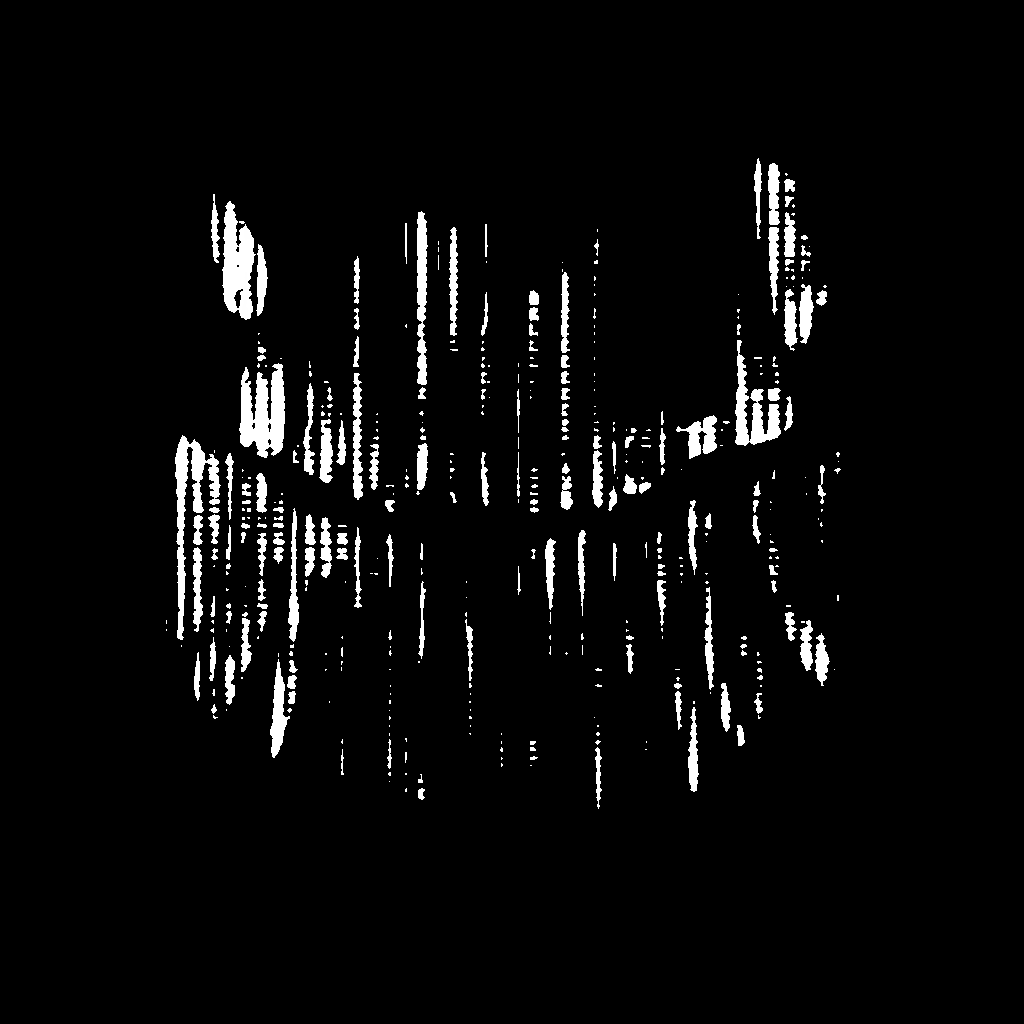

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 23%|██▎       | 23/100 [02:30<08:32,  6.65s/it]

Loss: 0.21009883284568787

0: 288x640 20 tooths, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


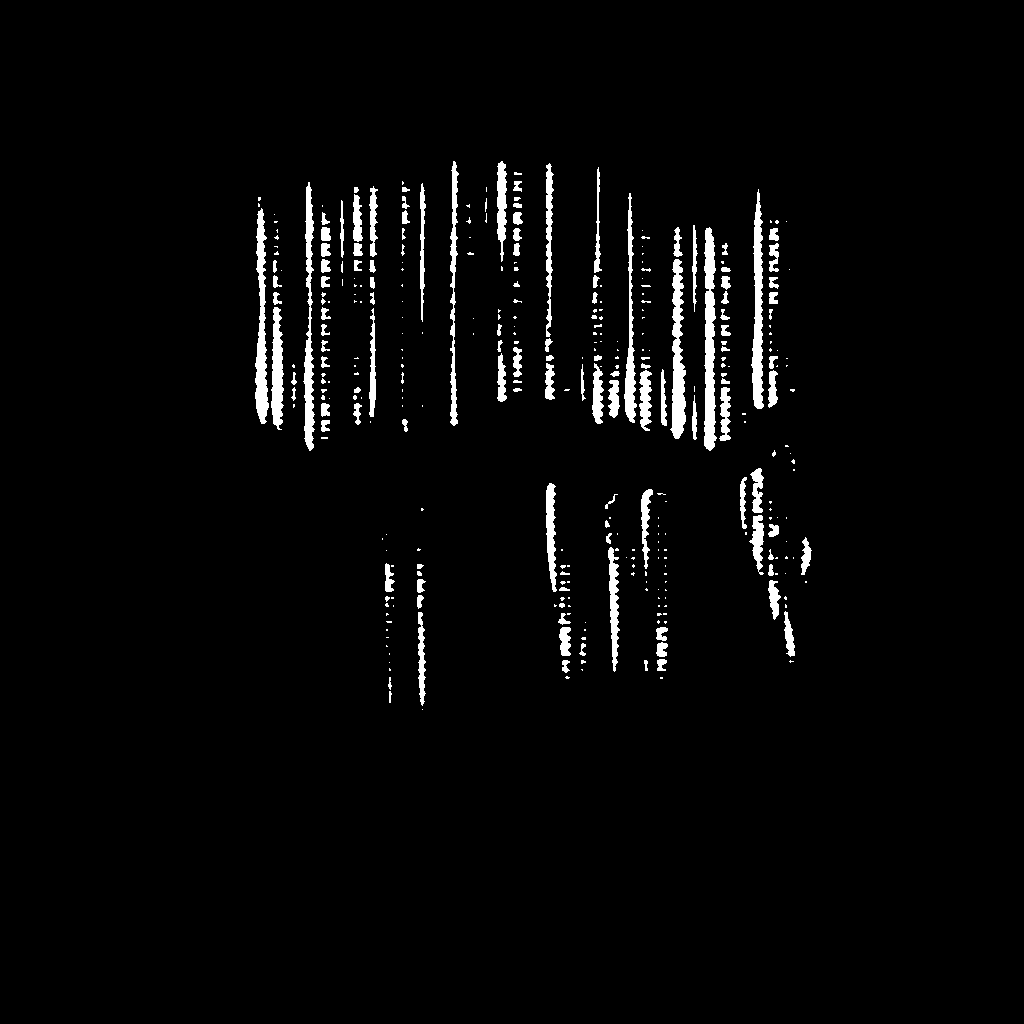

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 24%|██▍       | 24/100 [02:35<07:39,  6.05s/it]

Loss: 0.1163637638092041

0: 288x640 34 tooths, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


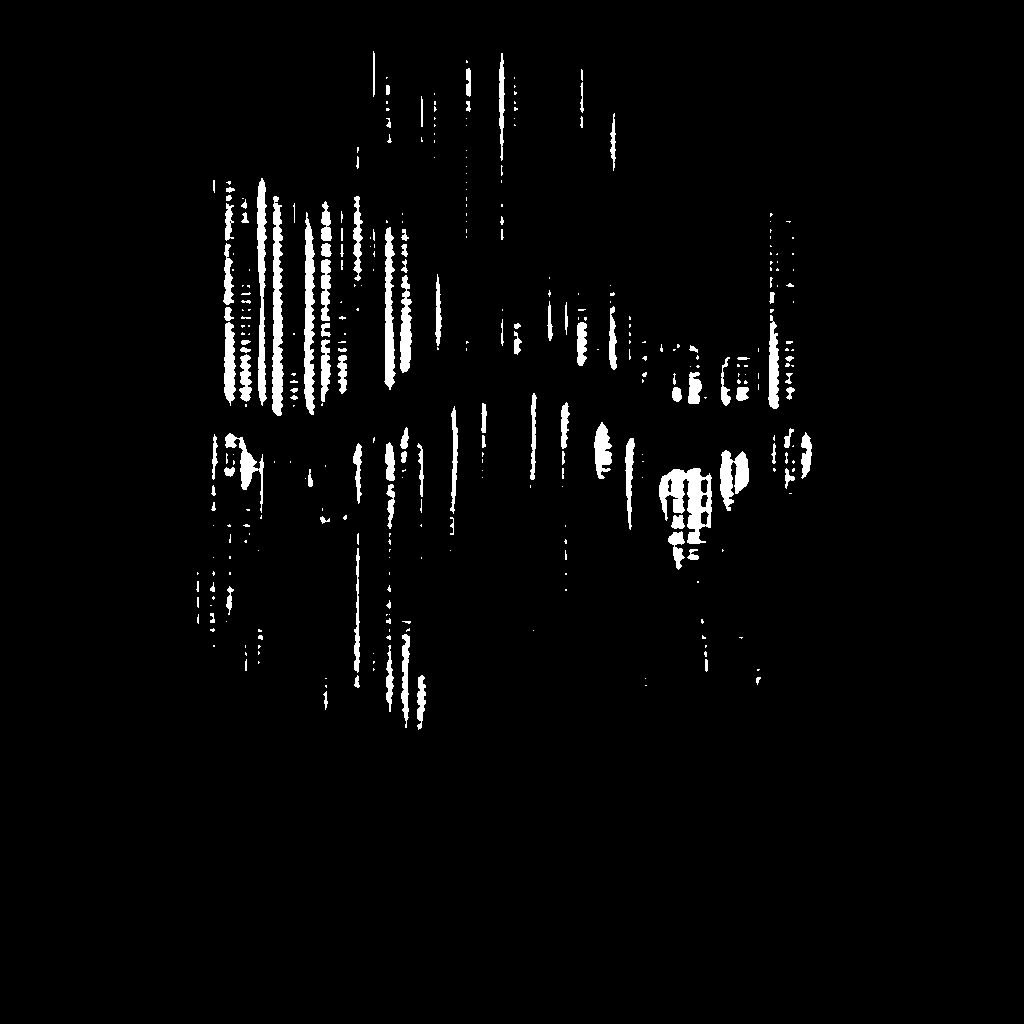

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 25%|██▌       | 25/100 [02:42<08:05,  6.47s/it]

Loss: 0.22708706557750702

0: 288x640 32 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


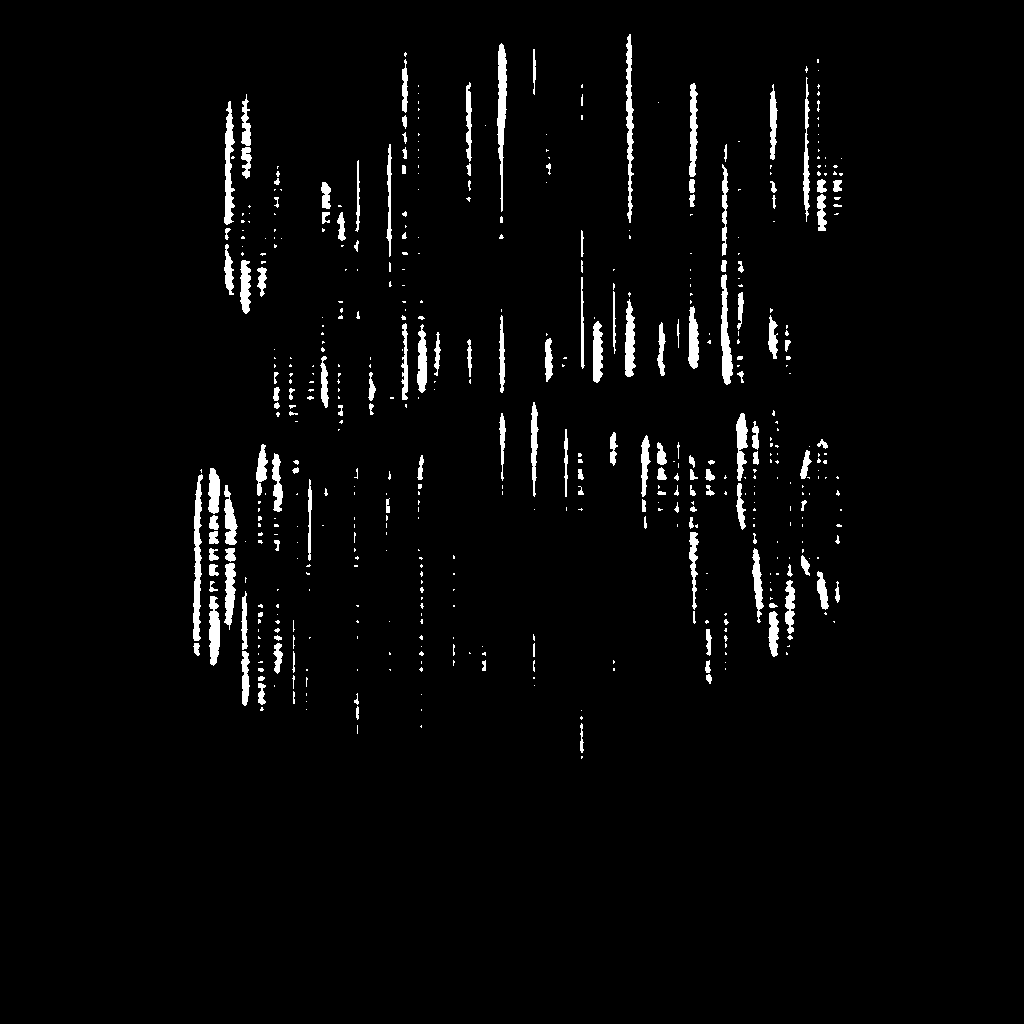

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 26%|██▌       | 26/100 [02:50<08:18,  6.73s/it]

Loss: 0.25086361169815063

0: 288x640 30 tooths, 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


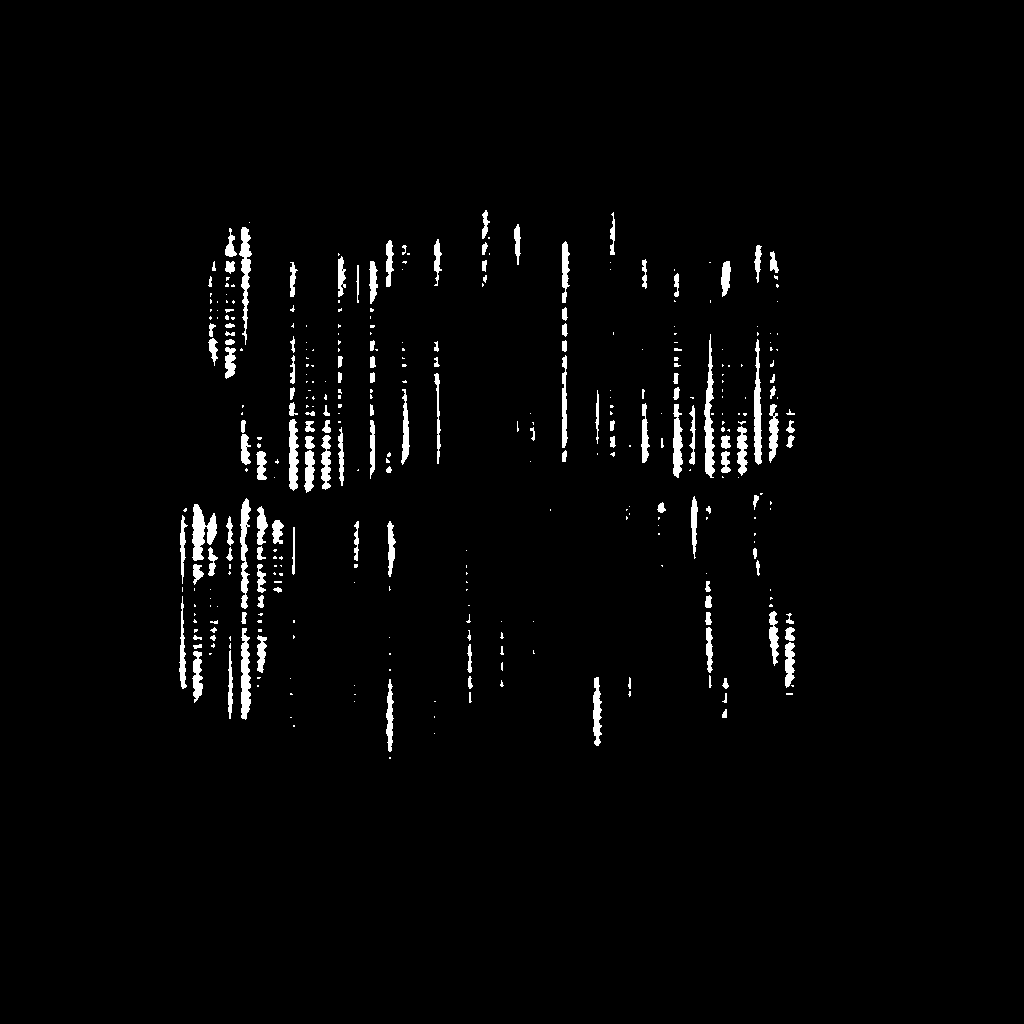

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 27%|██▋       | 27/100 [02:56<07:54,  6.51s/it]

Loss: 0.18326495587825775

0: 288x640 30 tooths, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


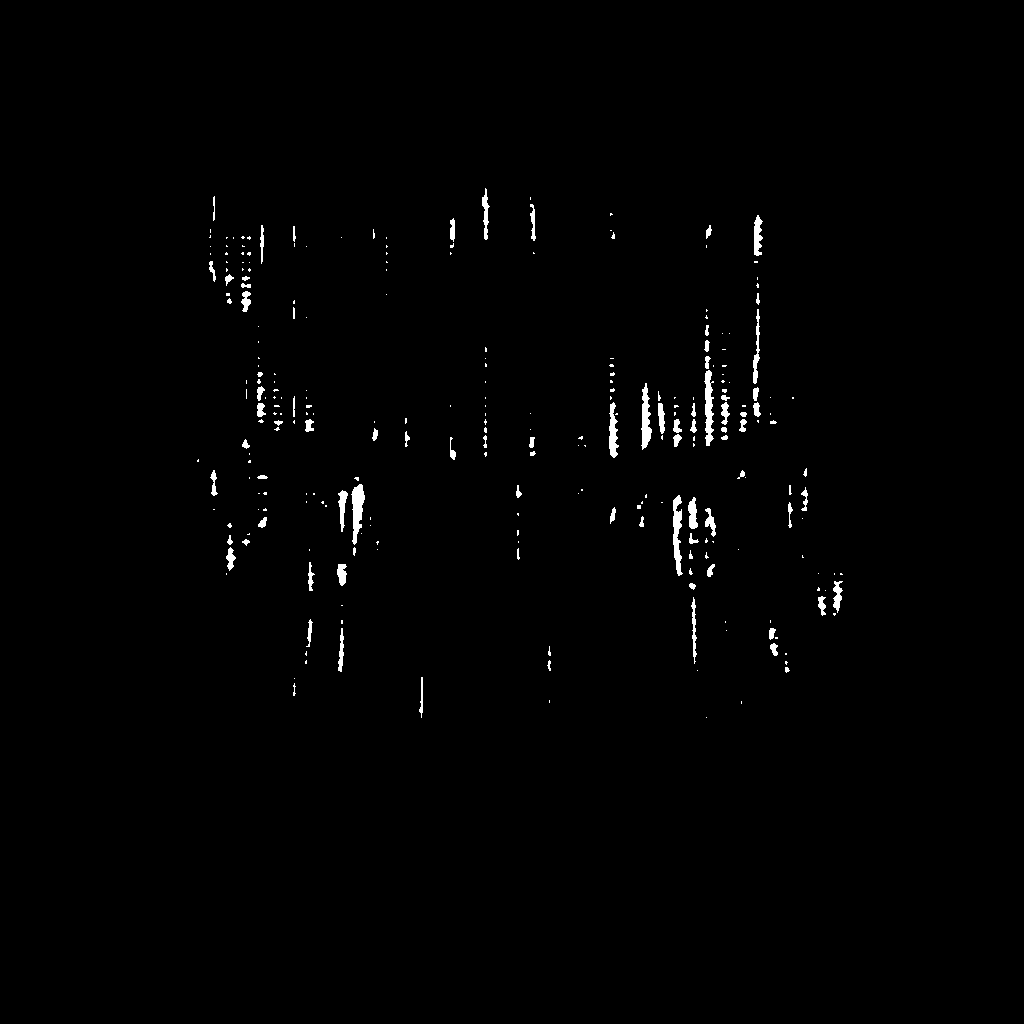

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 28%|██▊       | 28/100 [03:03<07:56,  6.62s/it]

Loss: 0.18612082302570343

0: 288x640 19 tooths, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


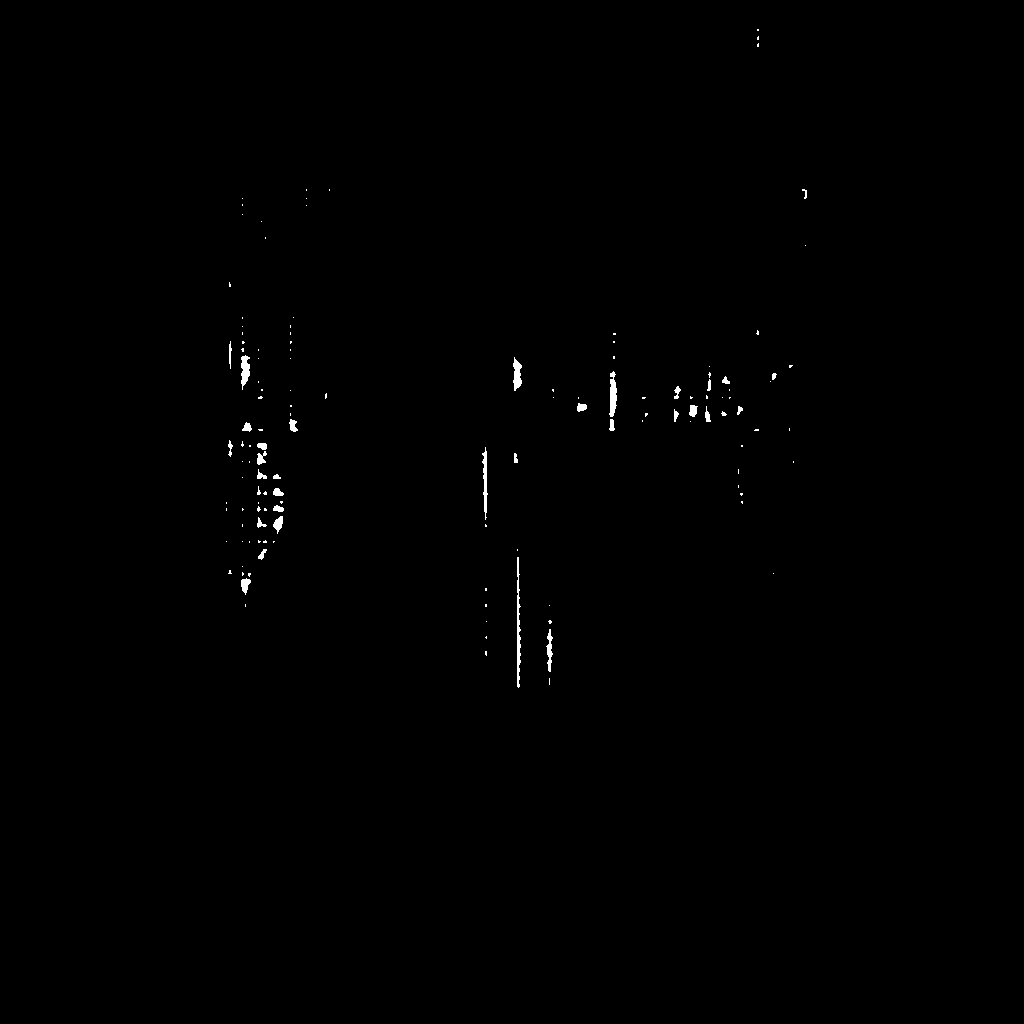

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 29%|██▉       | 29/100 [03:07<06:55,  5.85s/it]

Loss: 0.16286028921604156

0: 288x640 20 tooths, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


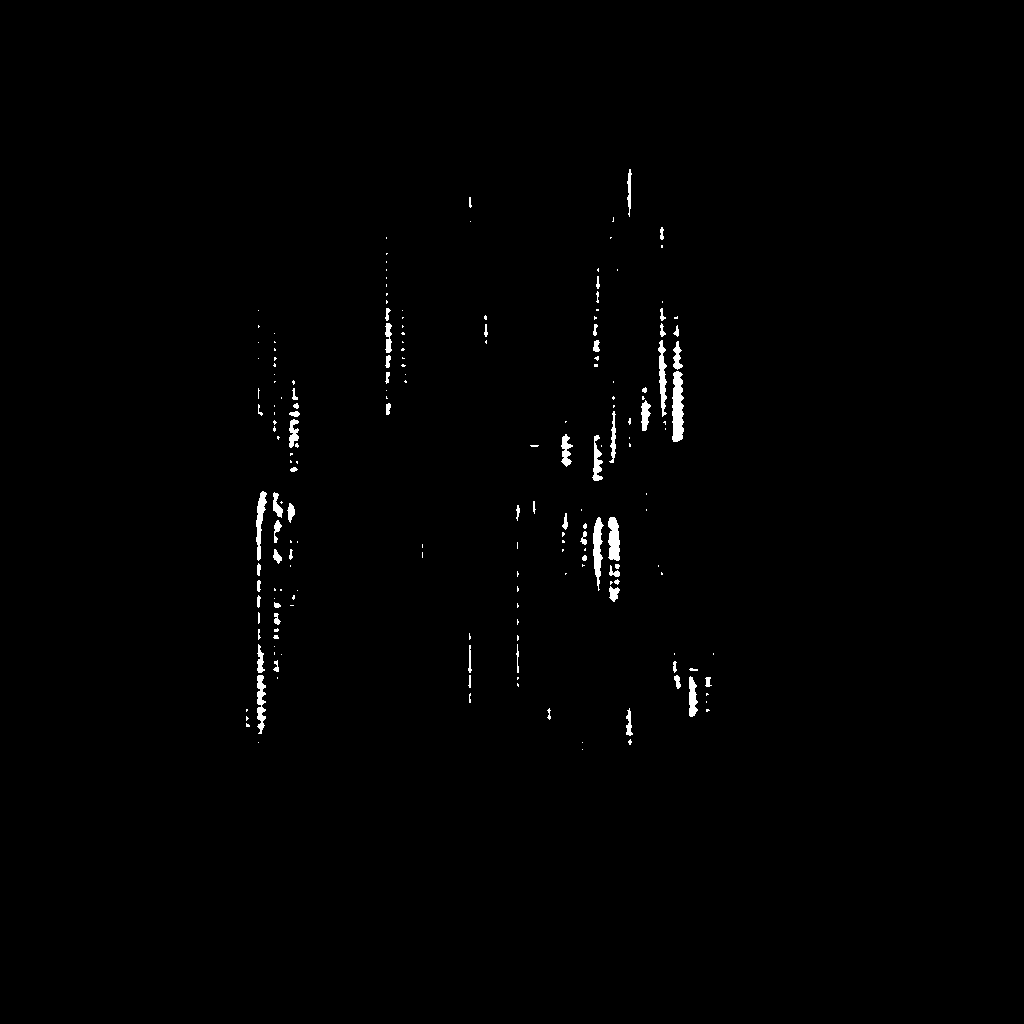

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 30%|███       | 30/100 [03:11<06:15,  5.36s/it]

Loss: 0.1336505115032196

0: 288x640 27 tooths, 12.6ms
Speed: 2.8ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


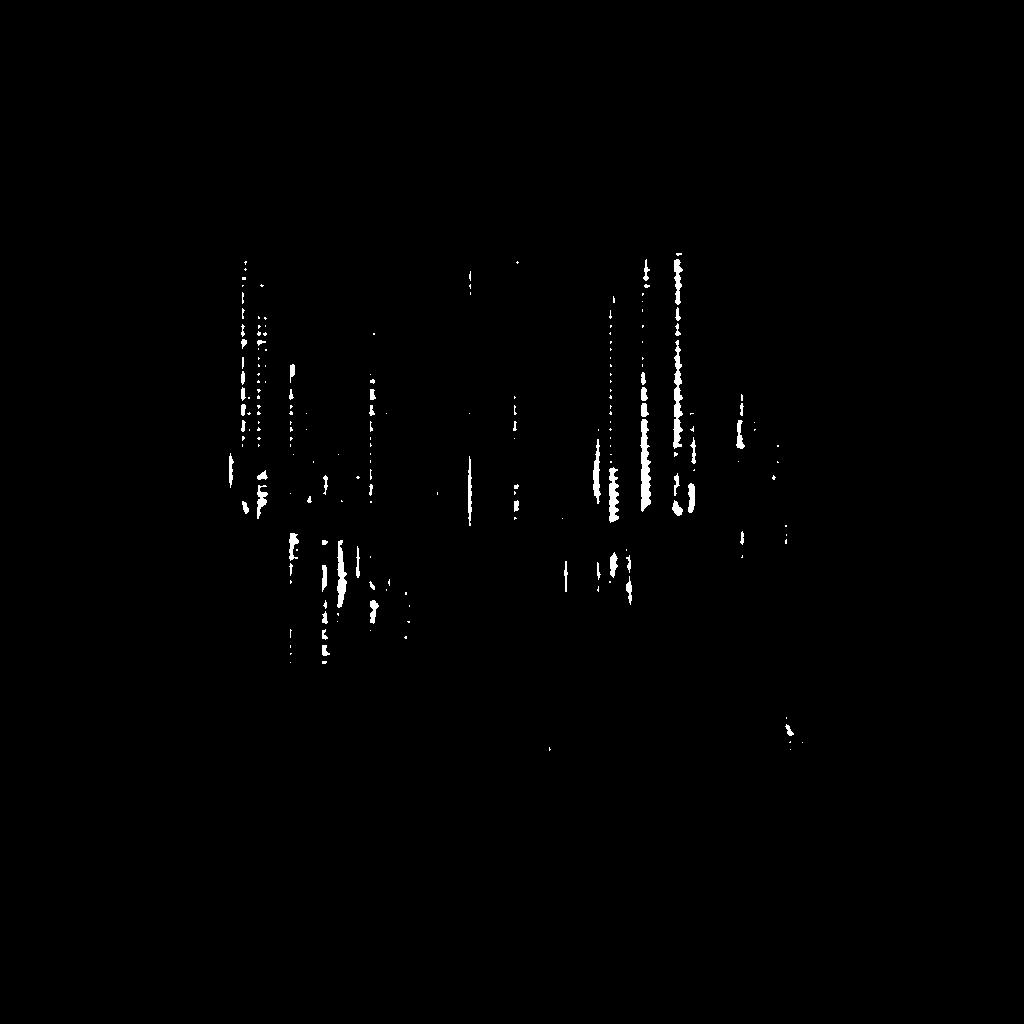

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 31%|███       | 31/100 [03:18<06:42,  5.83s/it]

Loss: 0.18569959700107574

0: 288x640 32 tooths, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


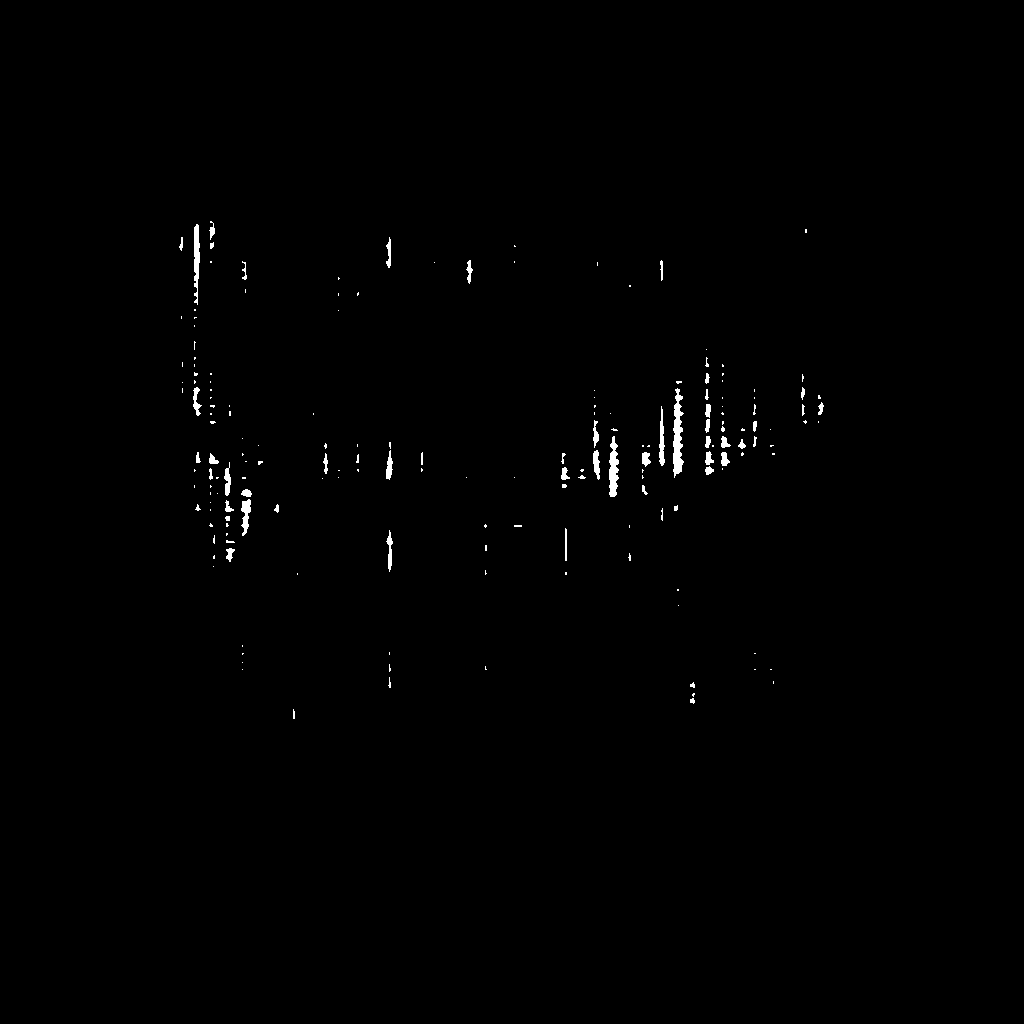

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 32%|███▏      | 32/100 [03:24<06:47,  6.00s/it]

Loss: 0.2053968757390976

0: 288x640 30 tooths, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


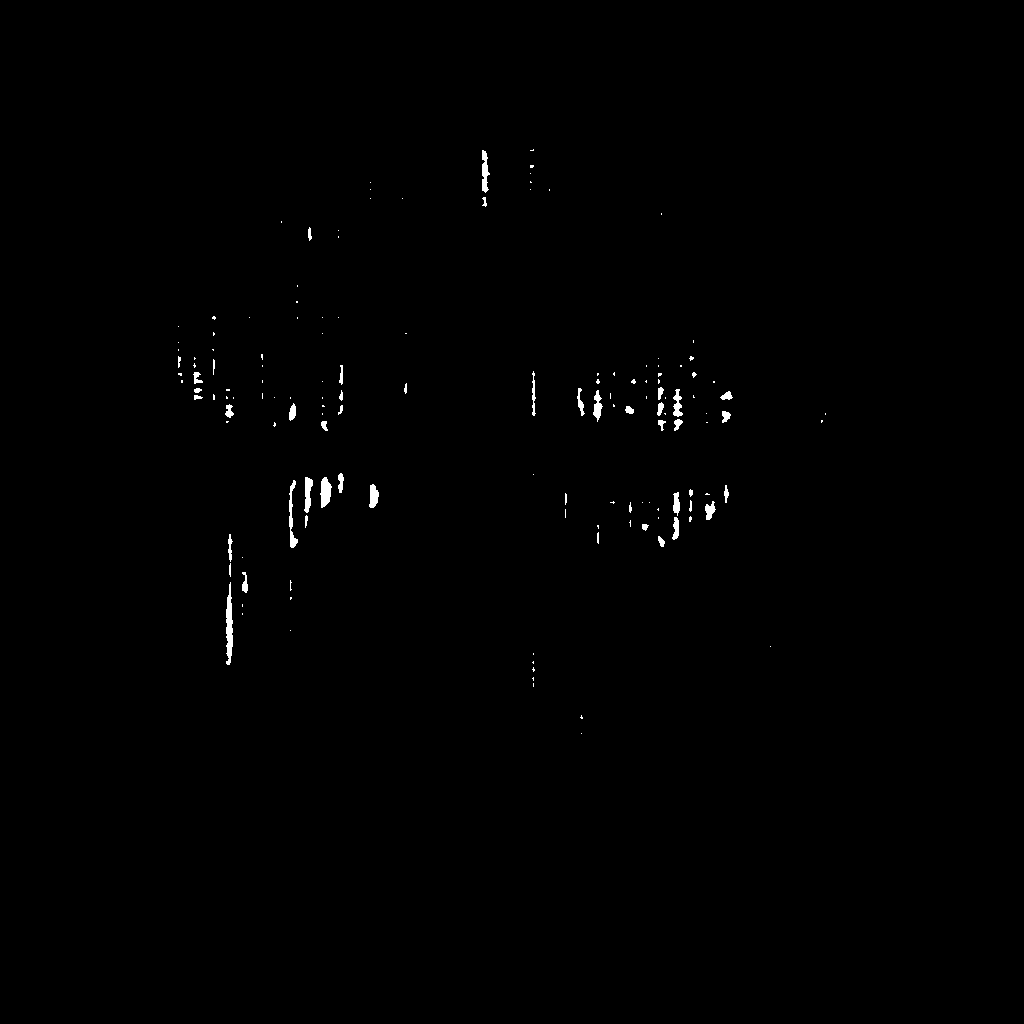

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 33%|███▎      | 33/100 [03:32<07:13,  6.46s/it]

Loss: 0.21486541628837585

0: 288x640 30 tooths, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


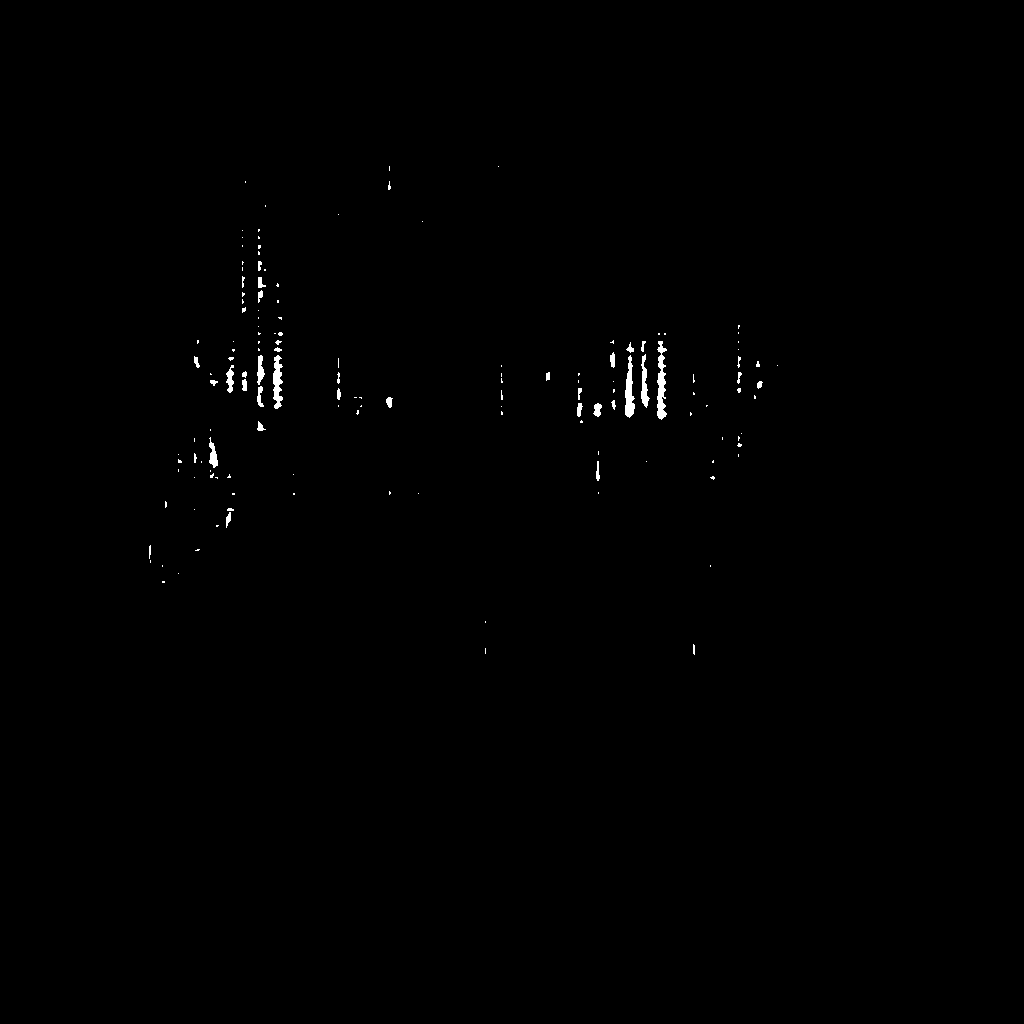

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 34%|███▍      | 34/100 [03:38<06:58,  6.34s/it]

Loss: 0.2218254953622818

0: 288x640 20 tooths, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


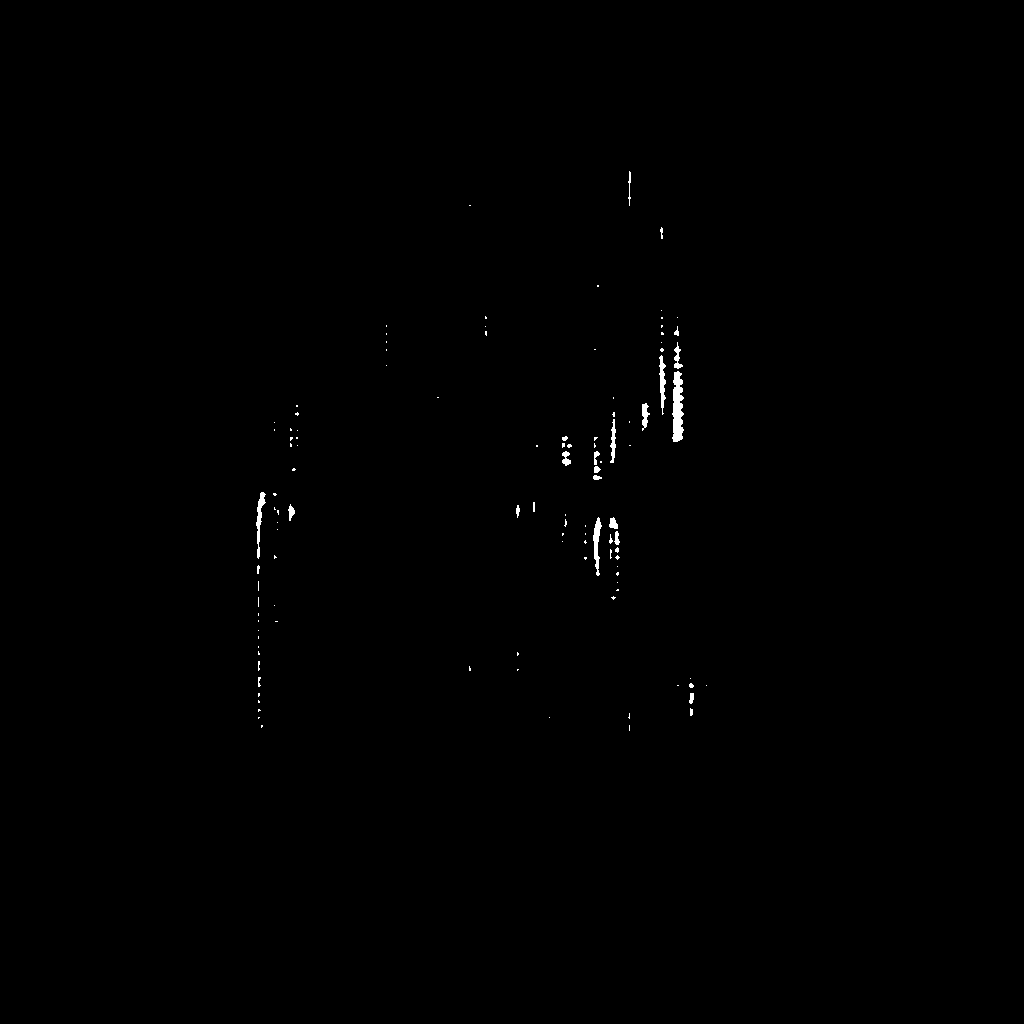

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 35%|███▌      | 35/100 [03:43<06:39,  6.14s/it]

Loss: 0.1375695914030075

0: 288x640 28 tooths, 10.5ms
Speed: 4.0ms preprocess, 10.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


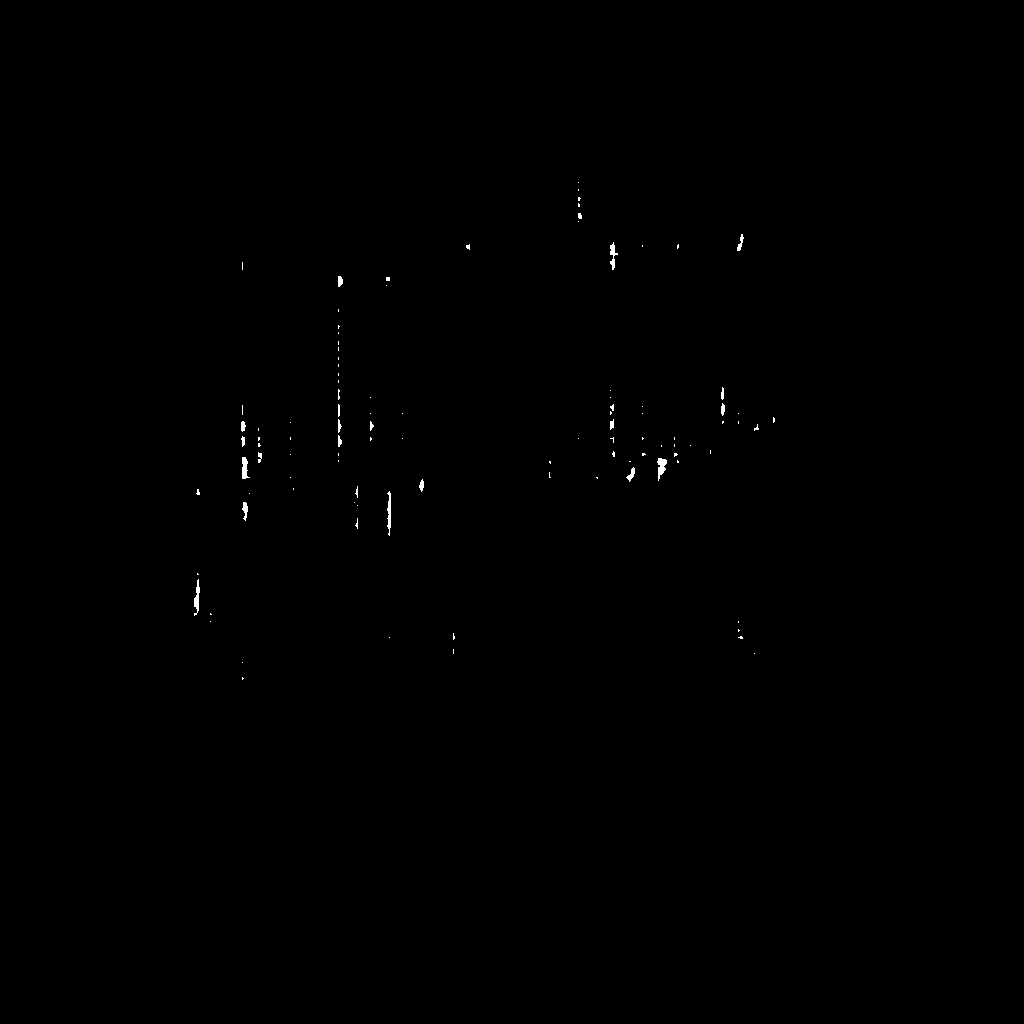

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 36%|███▌      | 36/100 [03:49<06:21,  5.97s/it]

Loss: 0.15986154973506927

0: 288x640 25 tooths, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


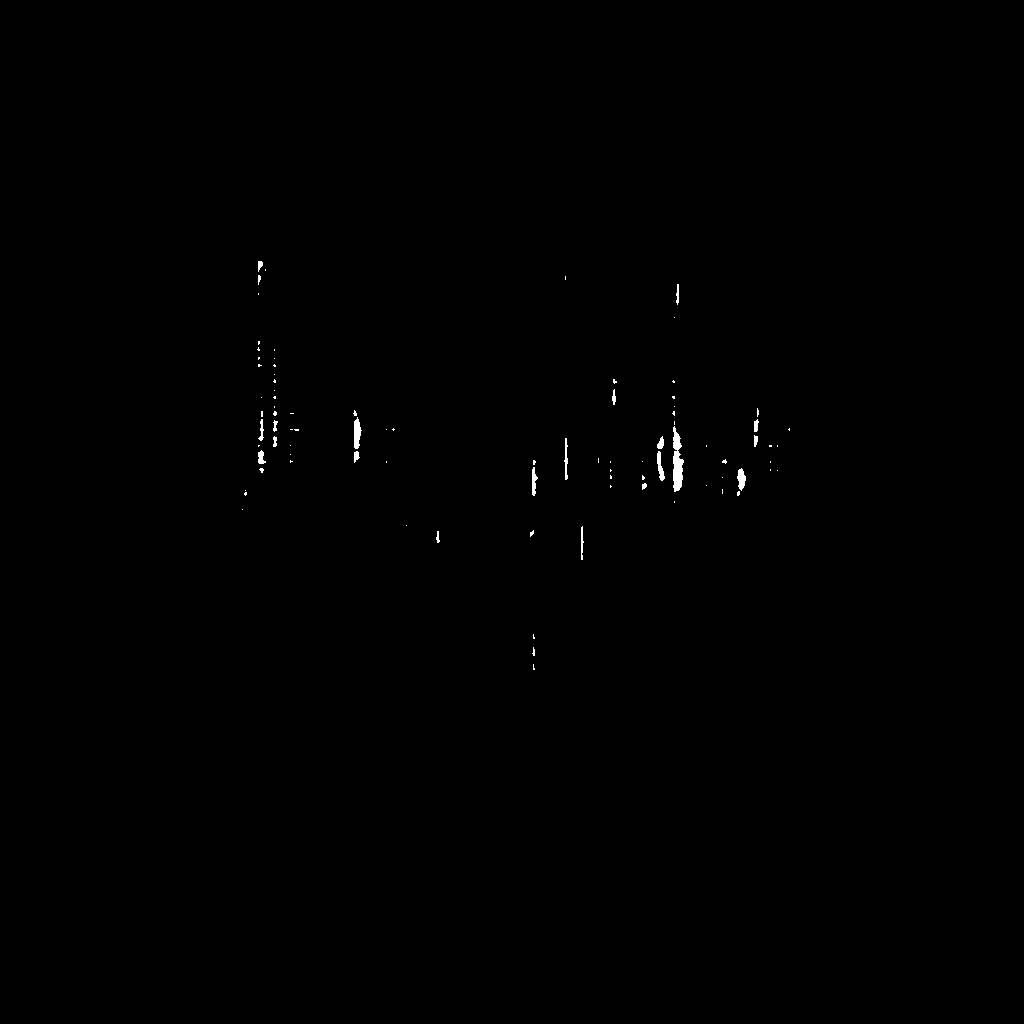

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 37%|███▋      | 37/100 [03:55<06:20,  6.04s/it]

Loss: 0.1372707635164261

0: 288x640 28 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


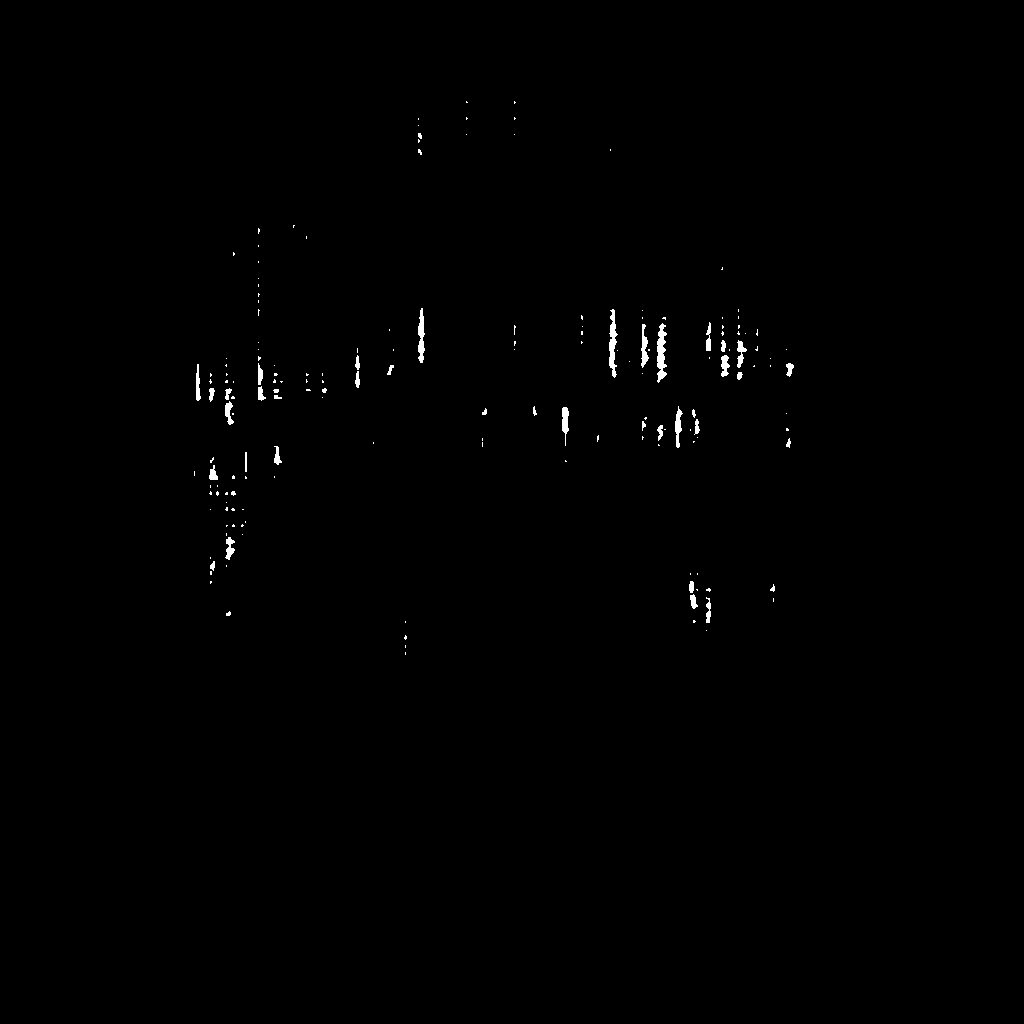

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 38%|███▊      | 38/100 [04:01<06:06,  5.91s/it]

Loss: 0.19345751404762268

0: 288x640 29 tooths, 11.6ms
Speed: 2.5ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


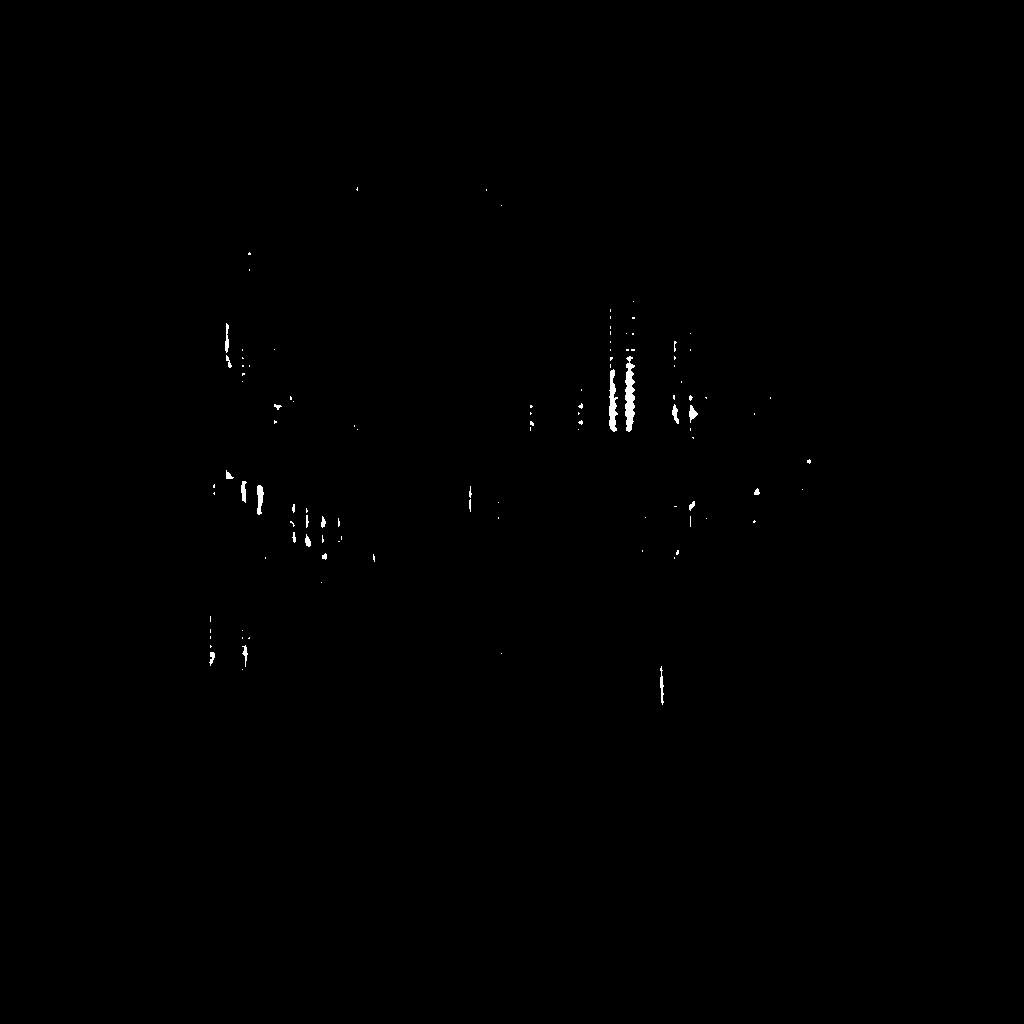

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 39%|███▉      | 39/100 [04:07<06:11,  6.09s/it]

Loss: 0.2219099998474121

0: 288x640 30 tooths, 12.8ms
Speed: 3.2ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


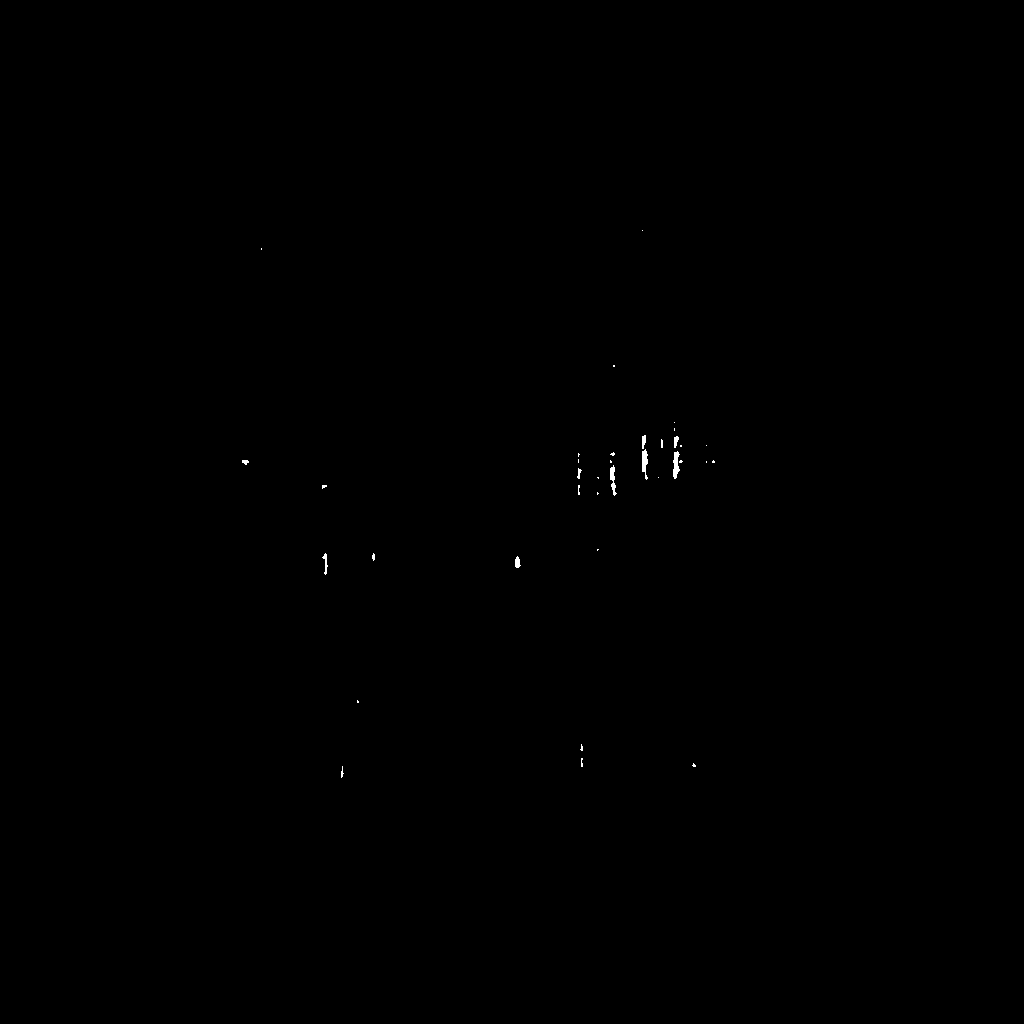

Max, min in prediction tensor(2., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 40%|████      | 40/100 [04:13<06:06,  6.10s/it]

Loss: 0.22186008095741272

0: 288x640 29 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


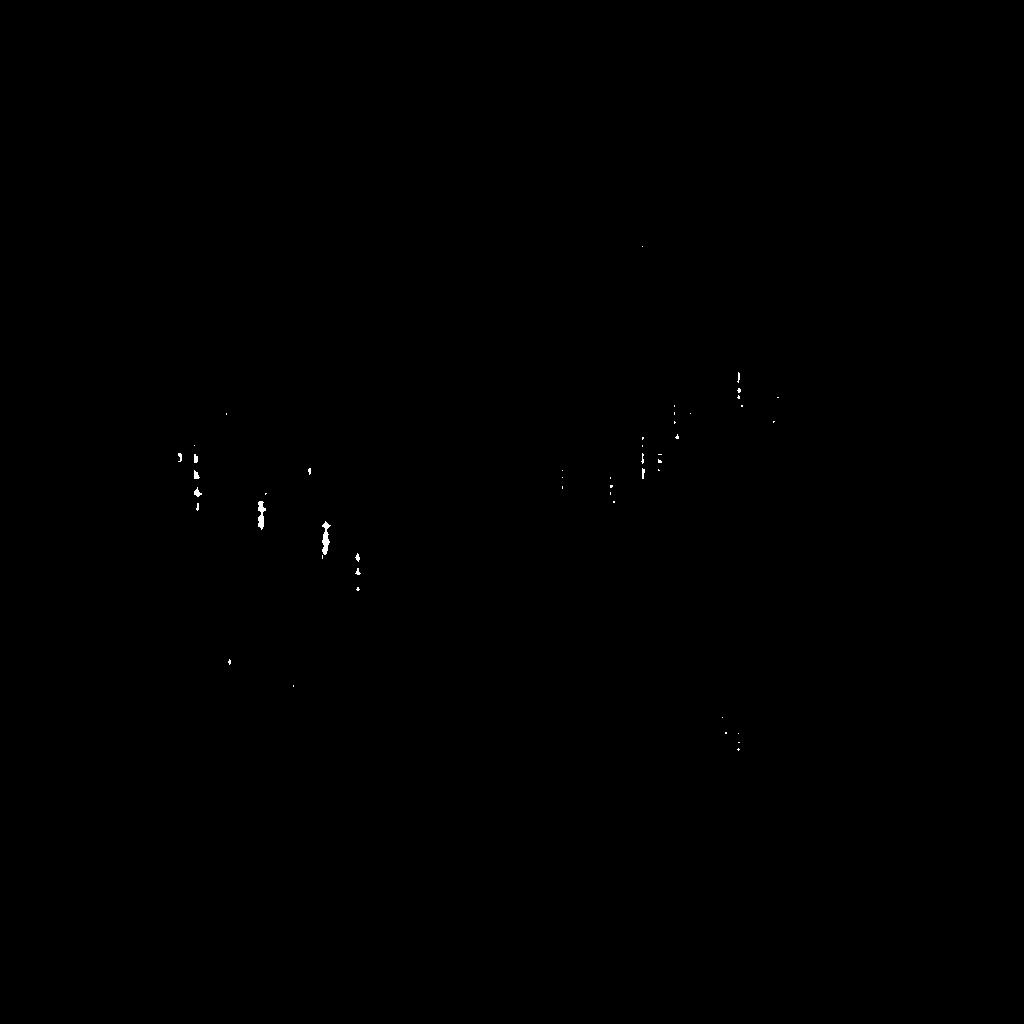

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 41%|████      | 41/100 [04:20<06:01,  6.13s/it]

Loss: 0.2363251894712448

0: 288x640 20 tooths, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


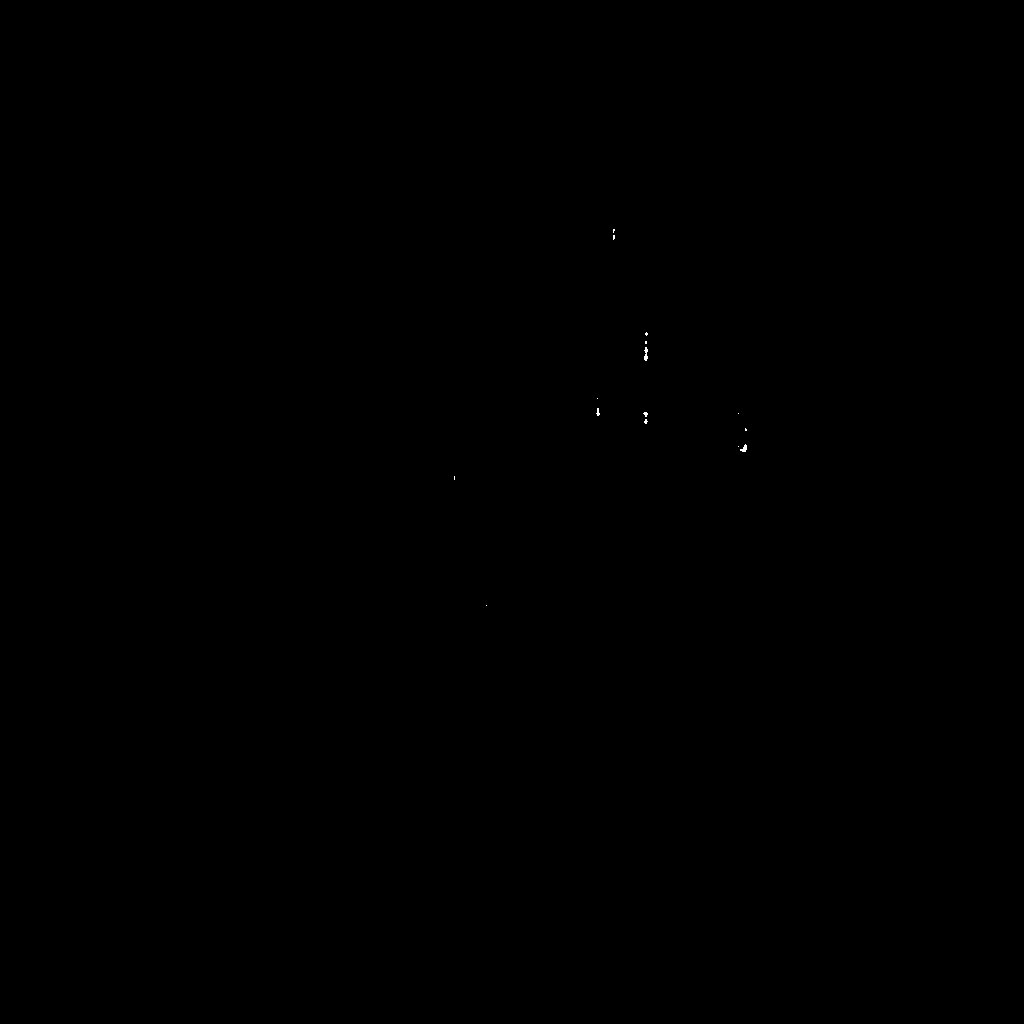

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 42%|████▏     | 42/100 [04:24<05:30,  5.69s/it]

Loss: 0.12323971092700958

0: 288x640 29 tooths, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


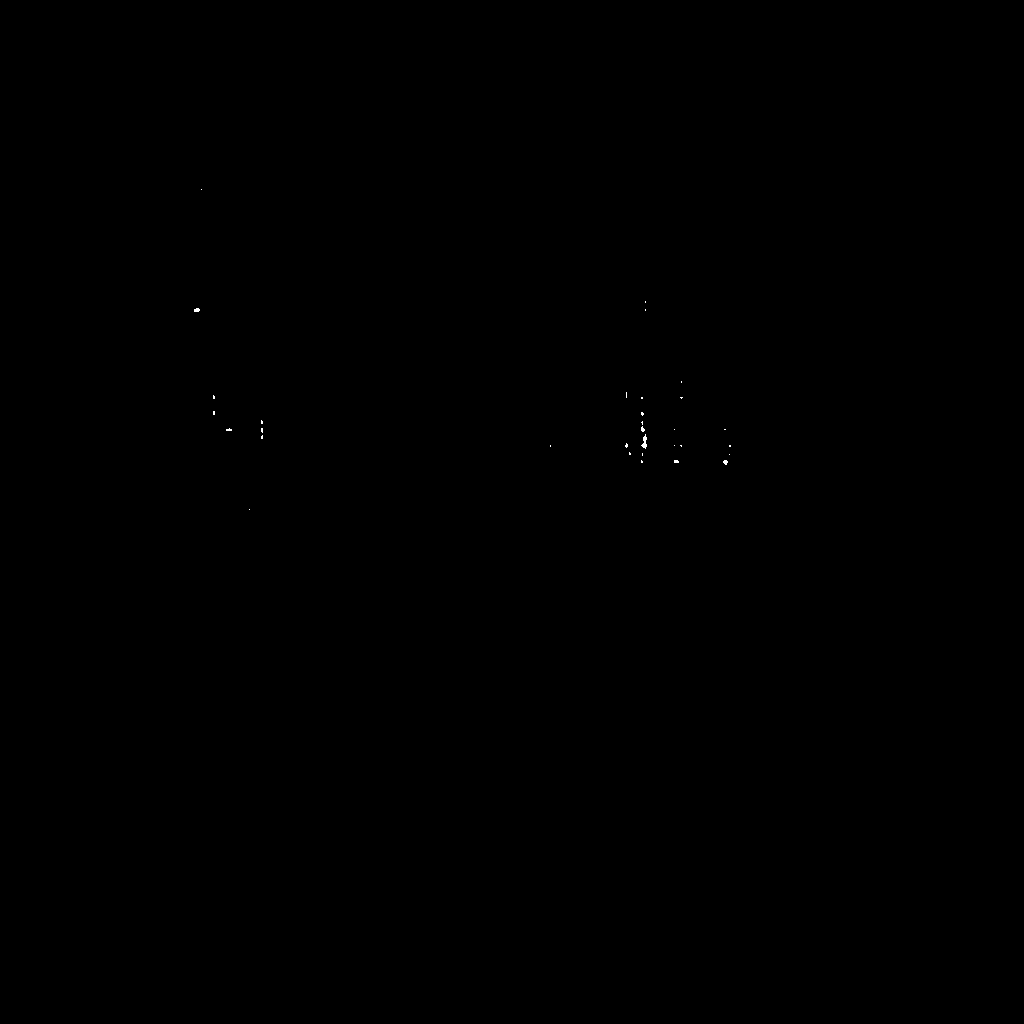

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 43%|████▎     | 43/100 [04:30<05:26,  5.72s/it]

Loss: 0.20022067427635193

0: 288x640 20 tooths, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


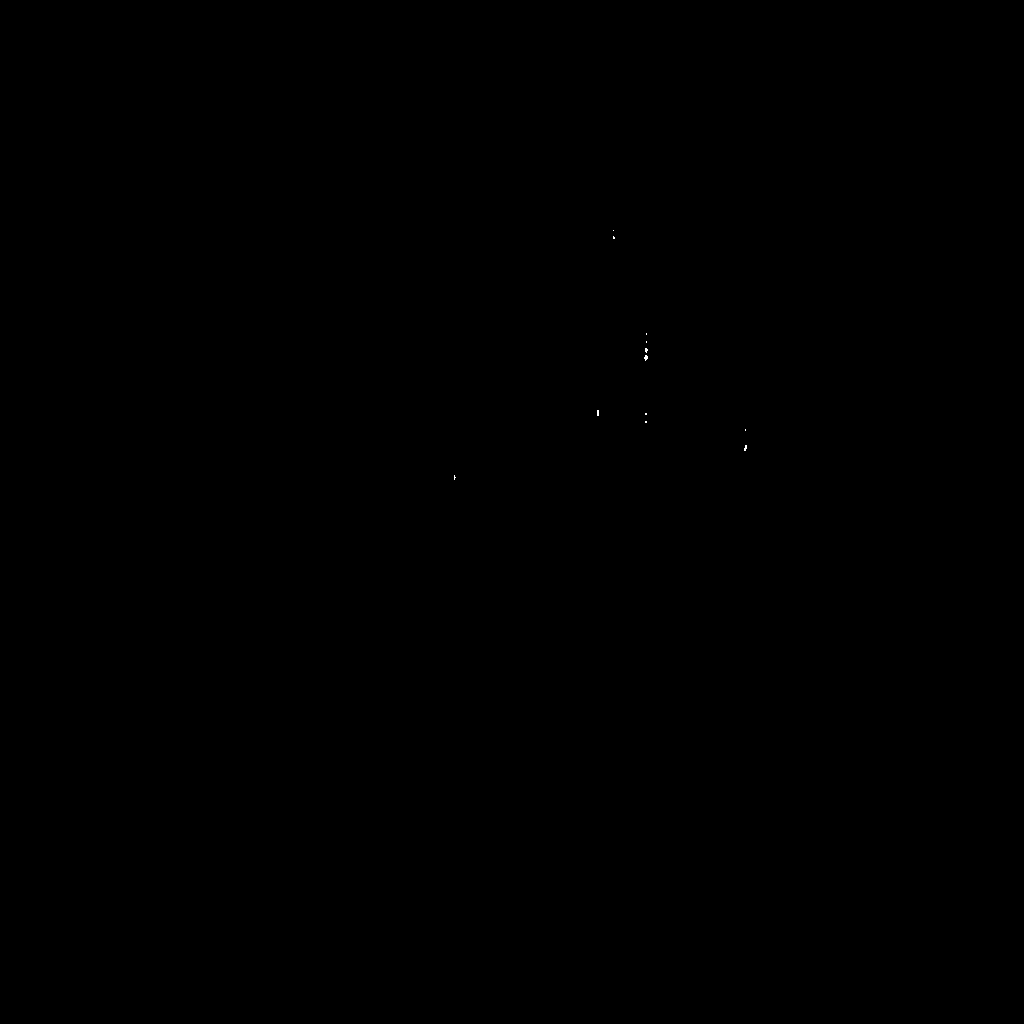

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 44%|████▍     | 44/100 [04:36<05:20,  5.73s/it]

Loss: 0.12331113964319229

0: 288x640 32 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


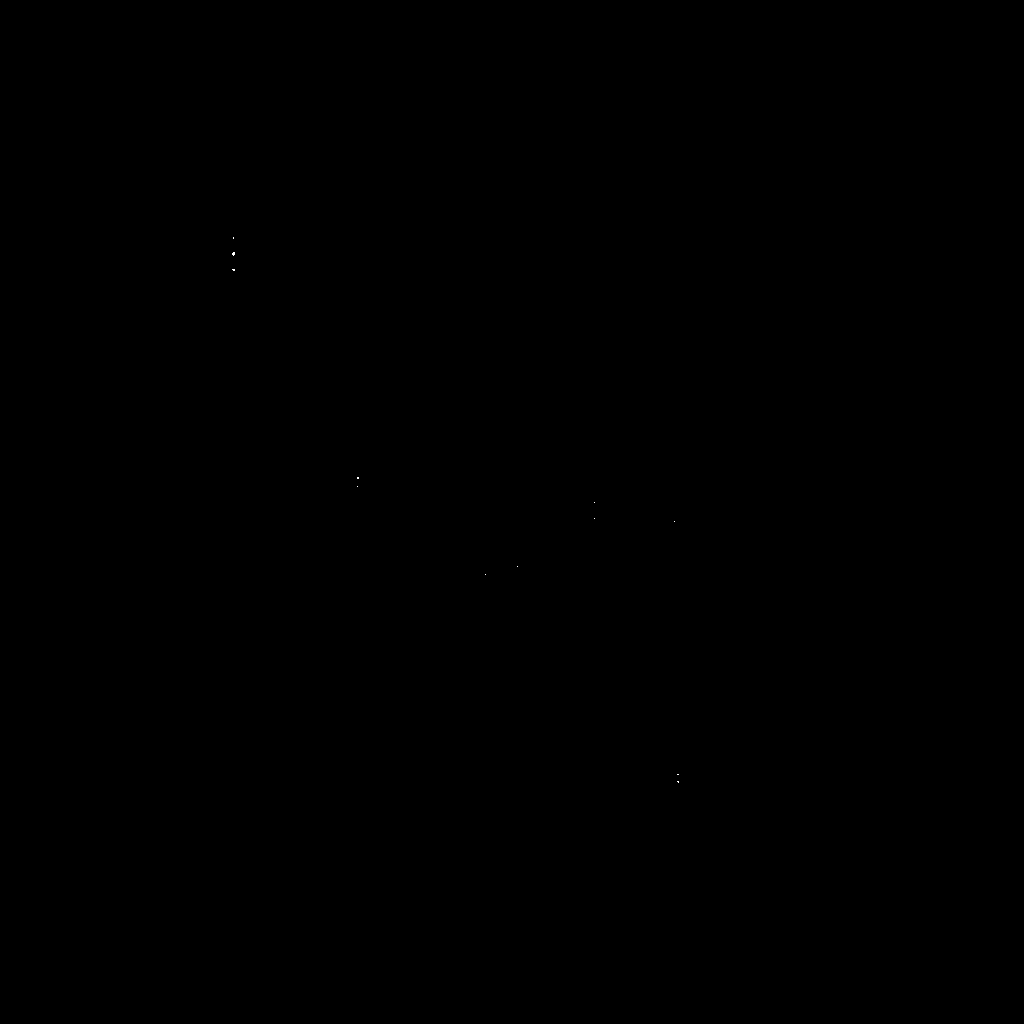

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 45%|████▌     | 45/100 [04:42<05:25,  5.91s/it]

Loss: 0.25641193985939026

0: 288x640 29 tooths, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


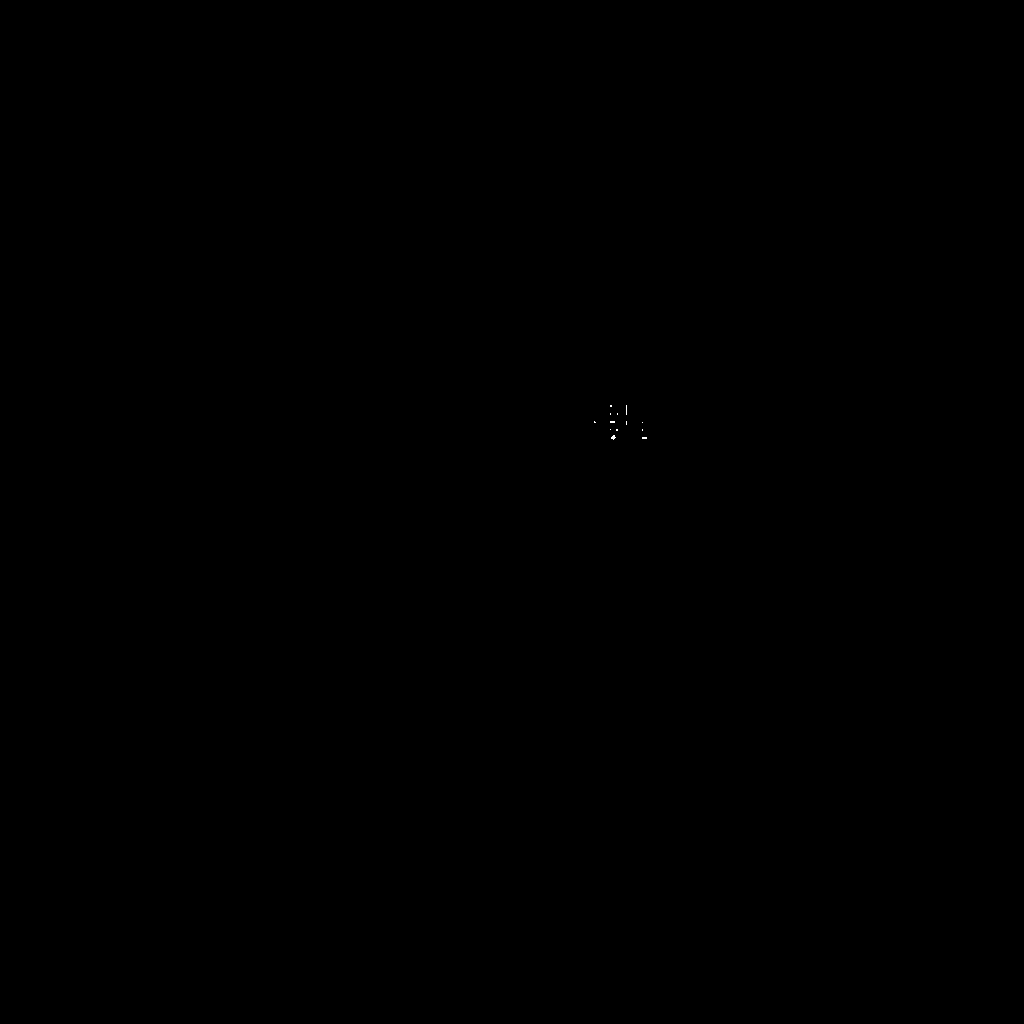

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 46%|████▌     | 46/100 [04:50<05:43,  6.36s/it]

Loss: 0.2160312831401825

0: 288x640 19 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


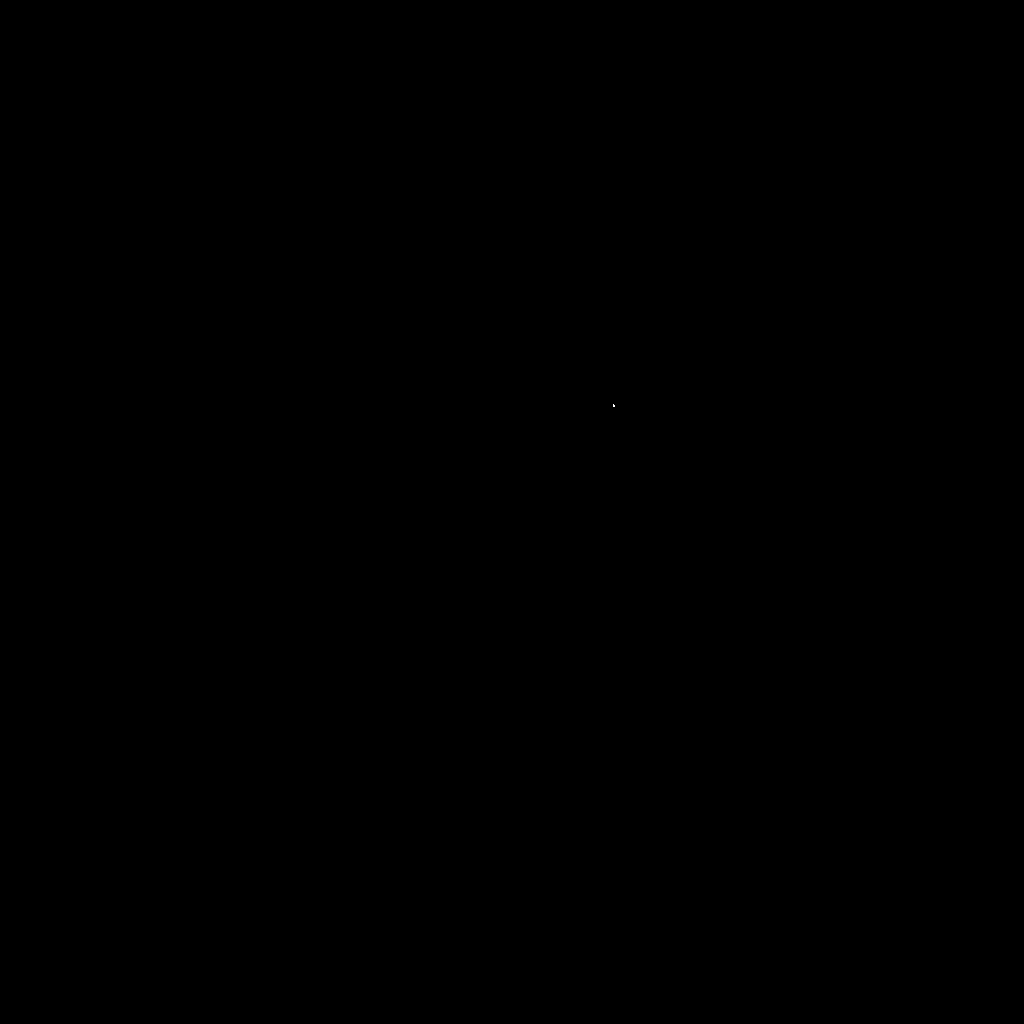

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 47%|████▋     | 47/100 [04:54<05:01,  5.68s/it]

Loss: 0.16556689143180847

0: 288x640 20 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


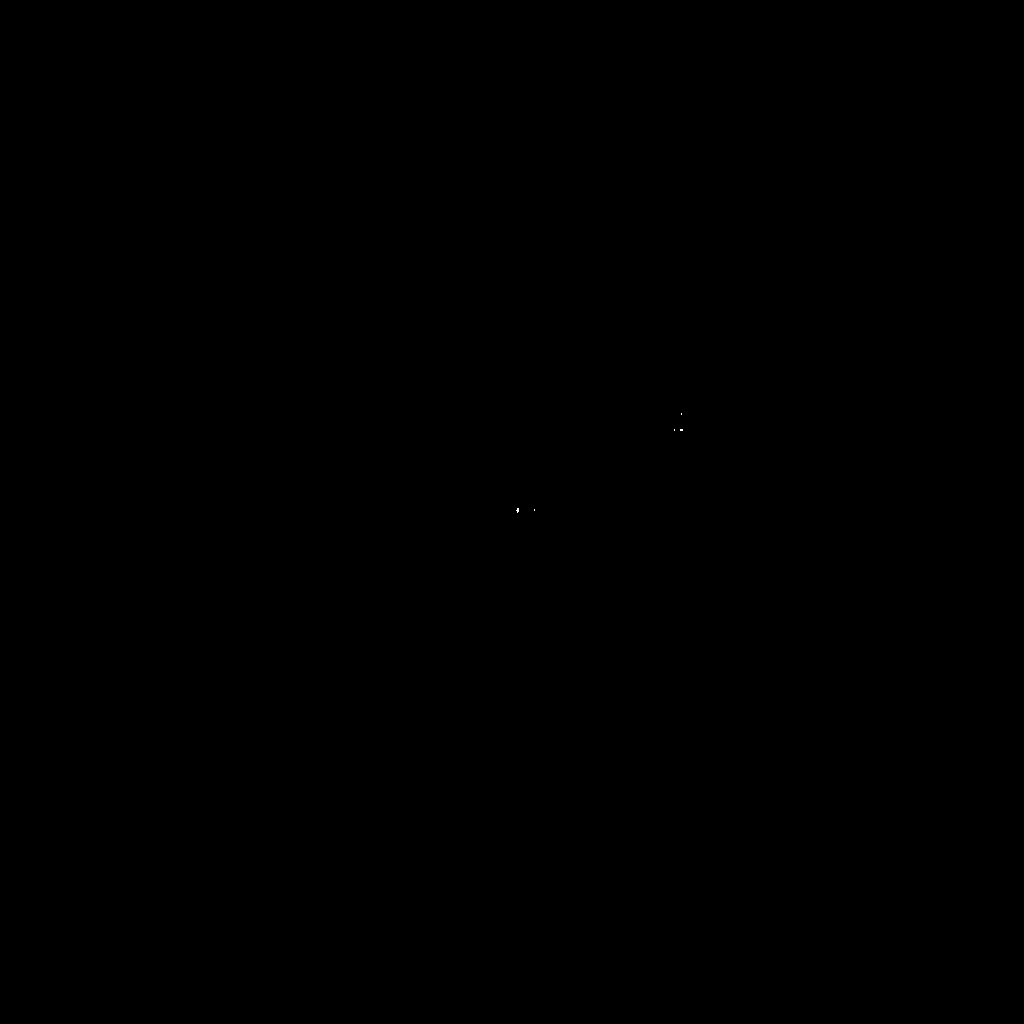

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 48%|████▊     | 48/100 [04:58<04:33,  5.26s/it]

Loss: 0.1401306837797165

0: 288x640 31 tooths, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


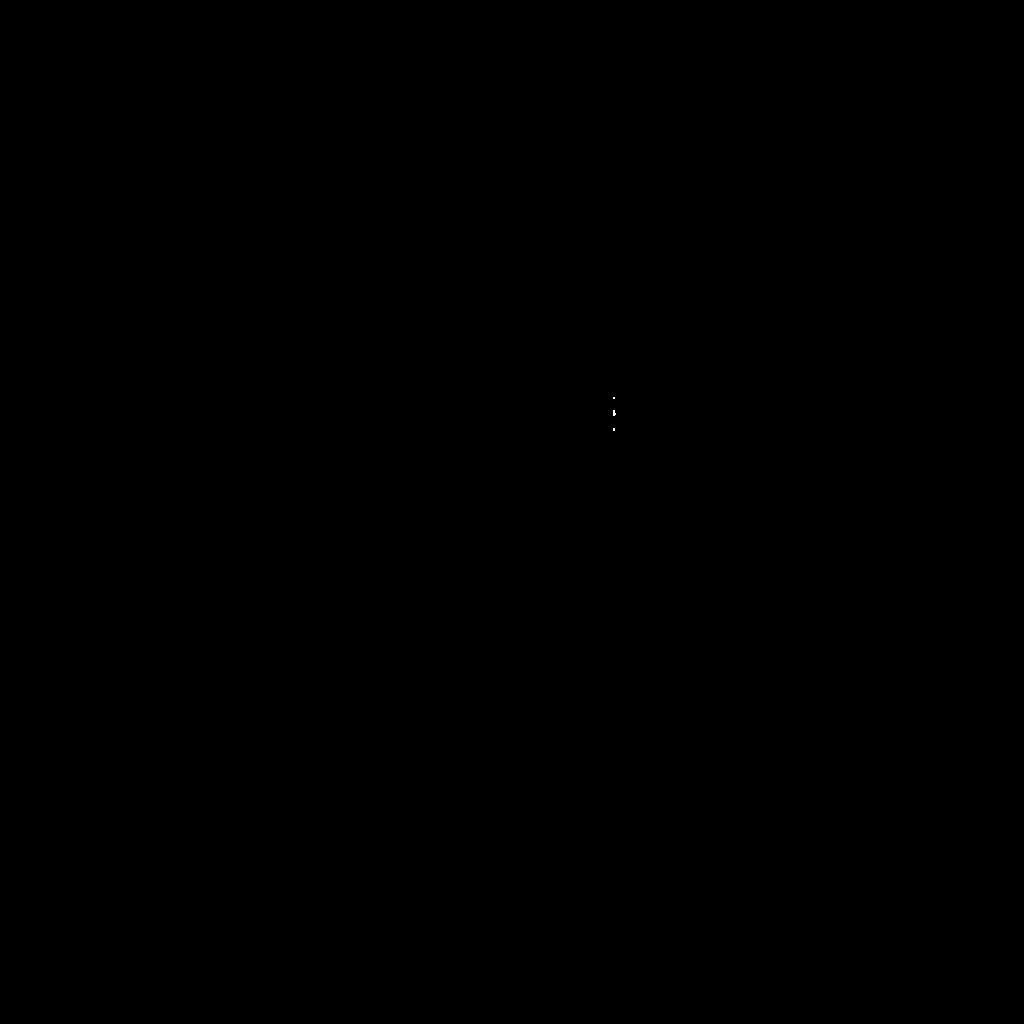

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 49%|████▉     | 49/100 [05:05<04:57,  5.84s/it]

Loss: 0.23035219311714172

0: 288x640 33 tooths, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


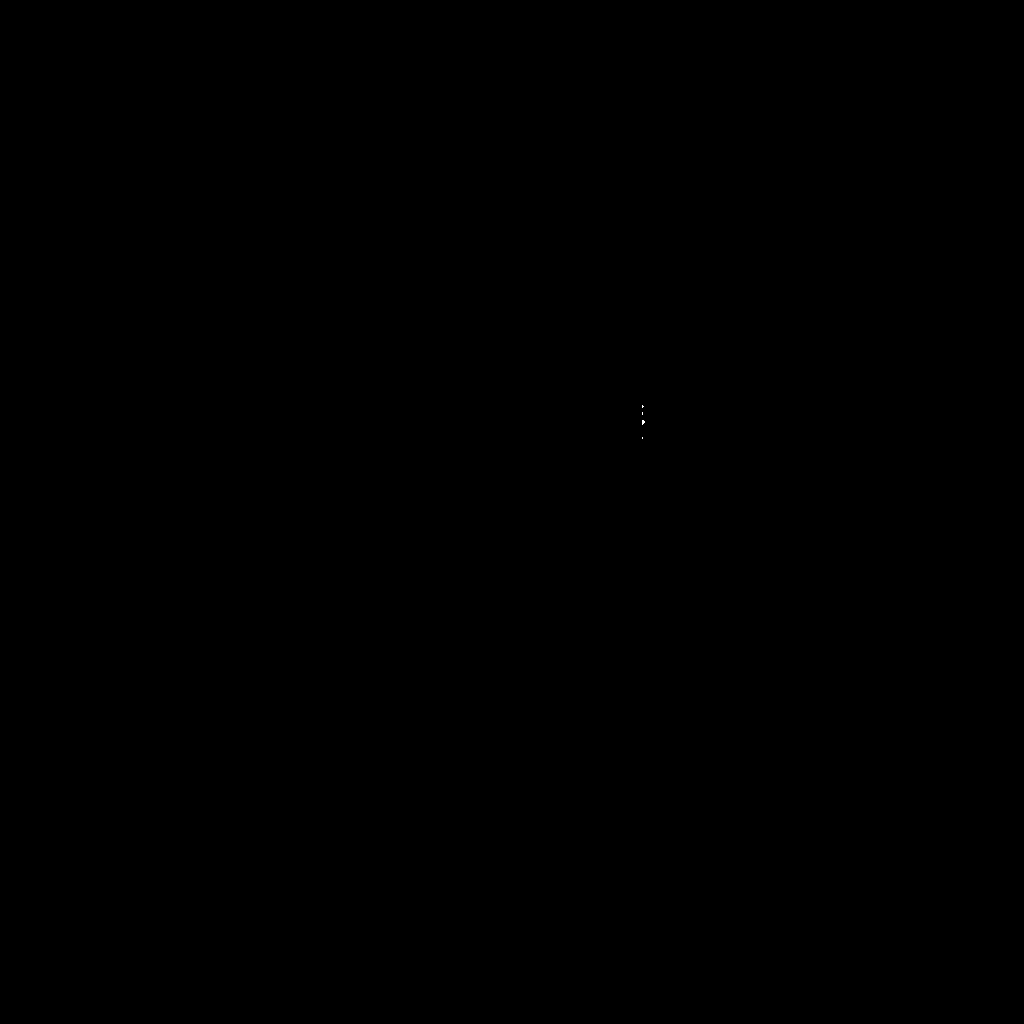

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 50%|█████     | 50/100 [05:12<05:09,  6.19s/it]

Loss: 0.22762924432754517

0: 288x640 29 tooths, 19.3ms
Speed: 2.5ms preprocess, 19.3ms inference, 8.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


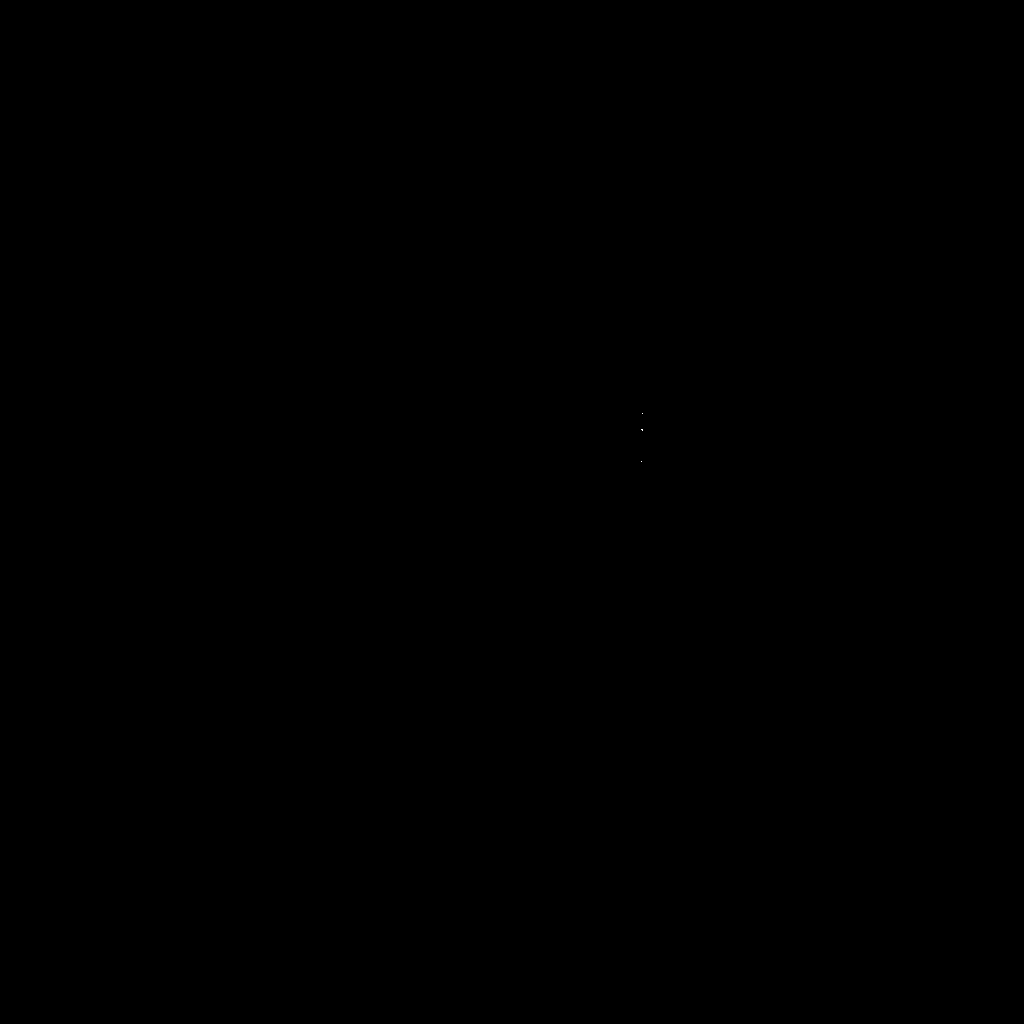

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 51%|█████     | 51/100 [05:18<05:03,  6.19s/it]

Loss: 0.20043280720710754

0: 288x640 32 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


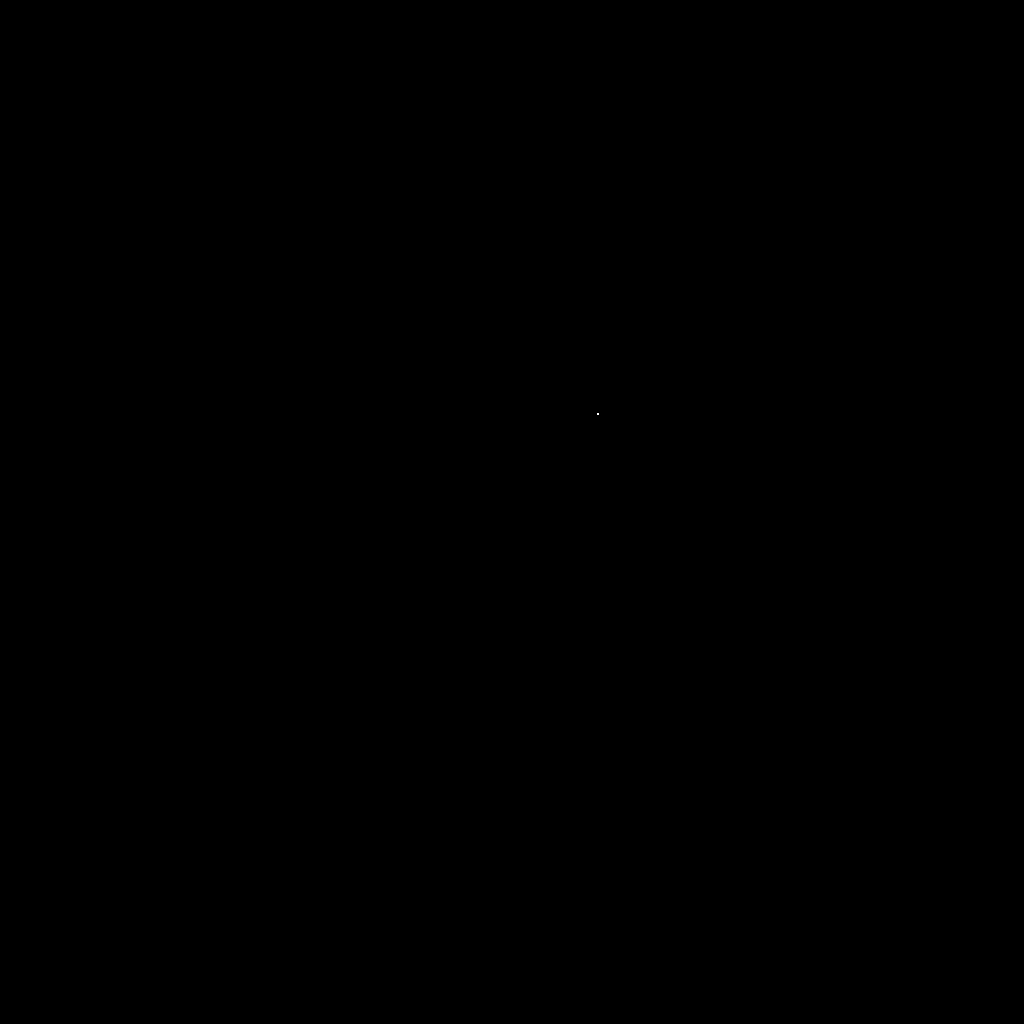

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 52%|█████▏    | 52/100 [05:25<05:05,  6.37s/it]

Loss: 0.24055932462215424

0: 288x640 32 tooths, 13.8ms
Speed: 3.8ms preprocess, 13.8ms inference, 2.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


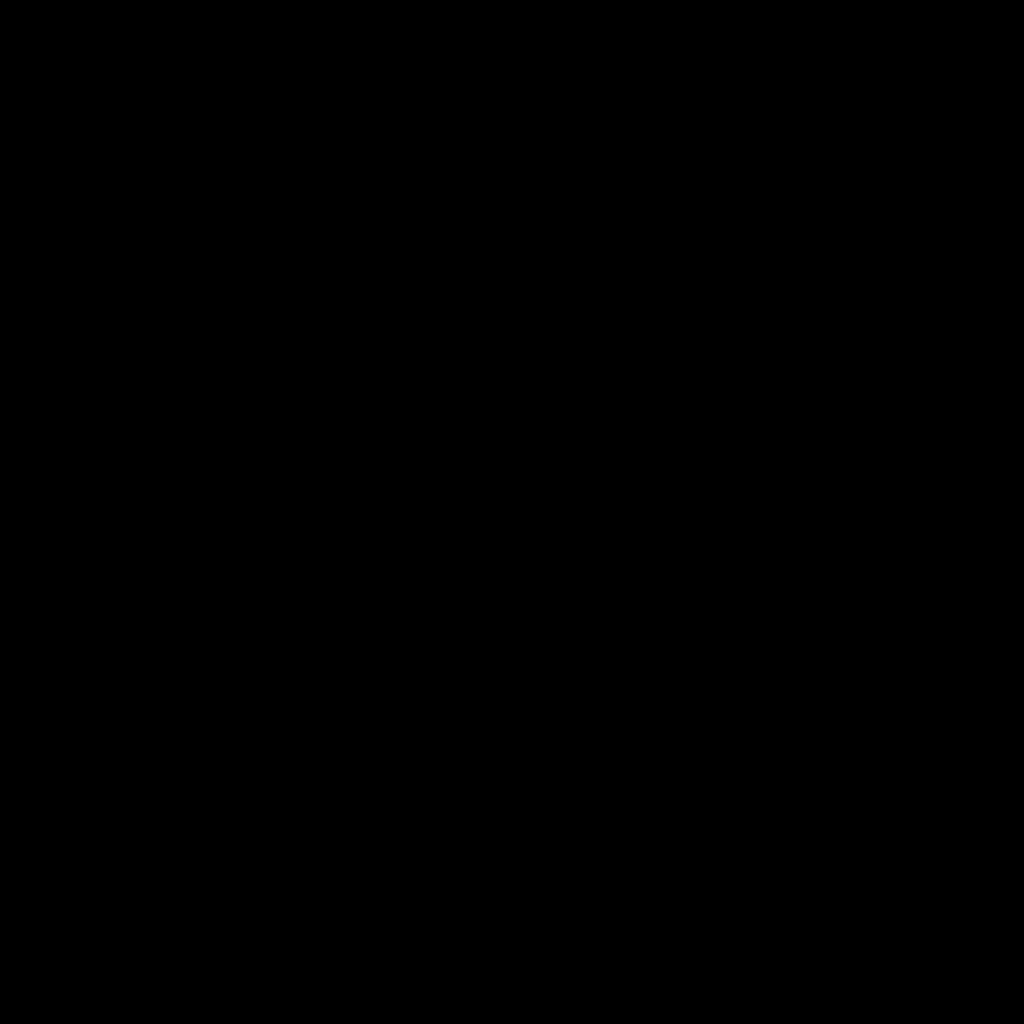

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 53%|█████▎    | 53/100 [05:33<05:26,  6.95s/it]

Loss: 0.256389319896698

0: 288x640 28 tooths, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


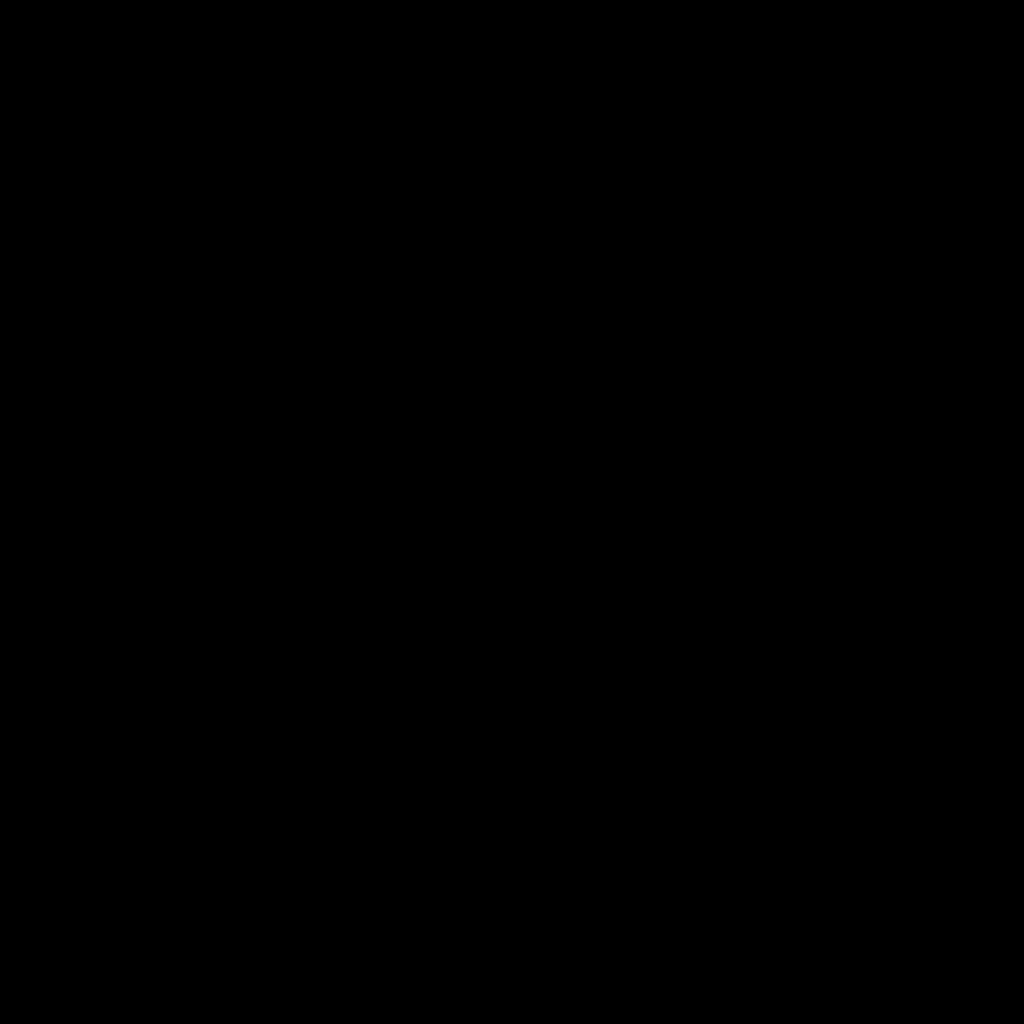

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 54%|█████▍    | 54/100 [05:40<05:15,  6.86s/it]

Loss: 0.1809464693069458

0: 288x640 29 tooths, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


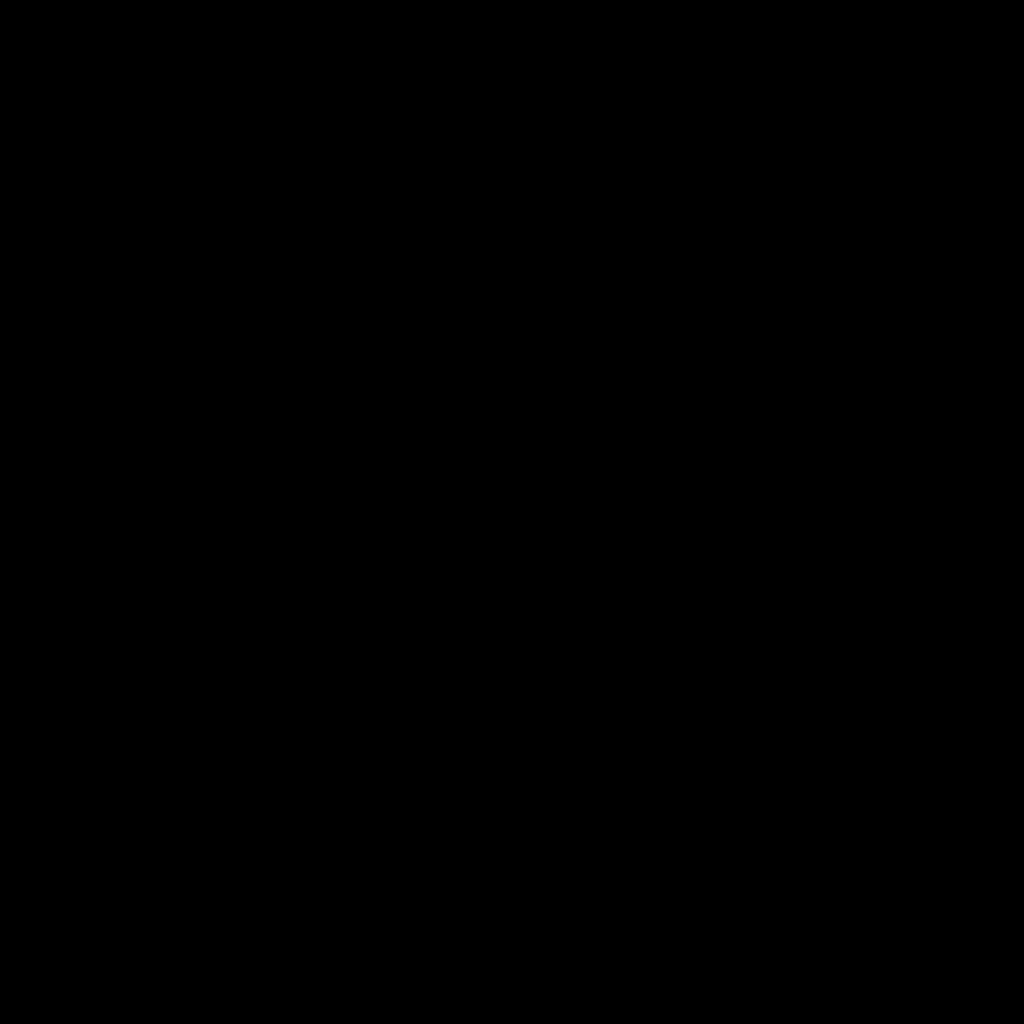

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 55%|█████▌    | 55/100 [05:46<04:54,  6.54s/it]

Loss: 0.23700128495693207

0: 288x640 28 tooths, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


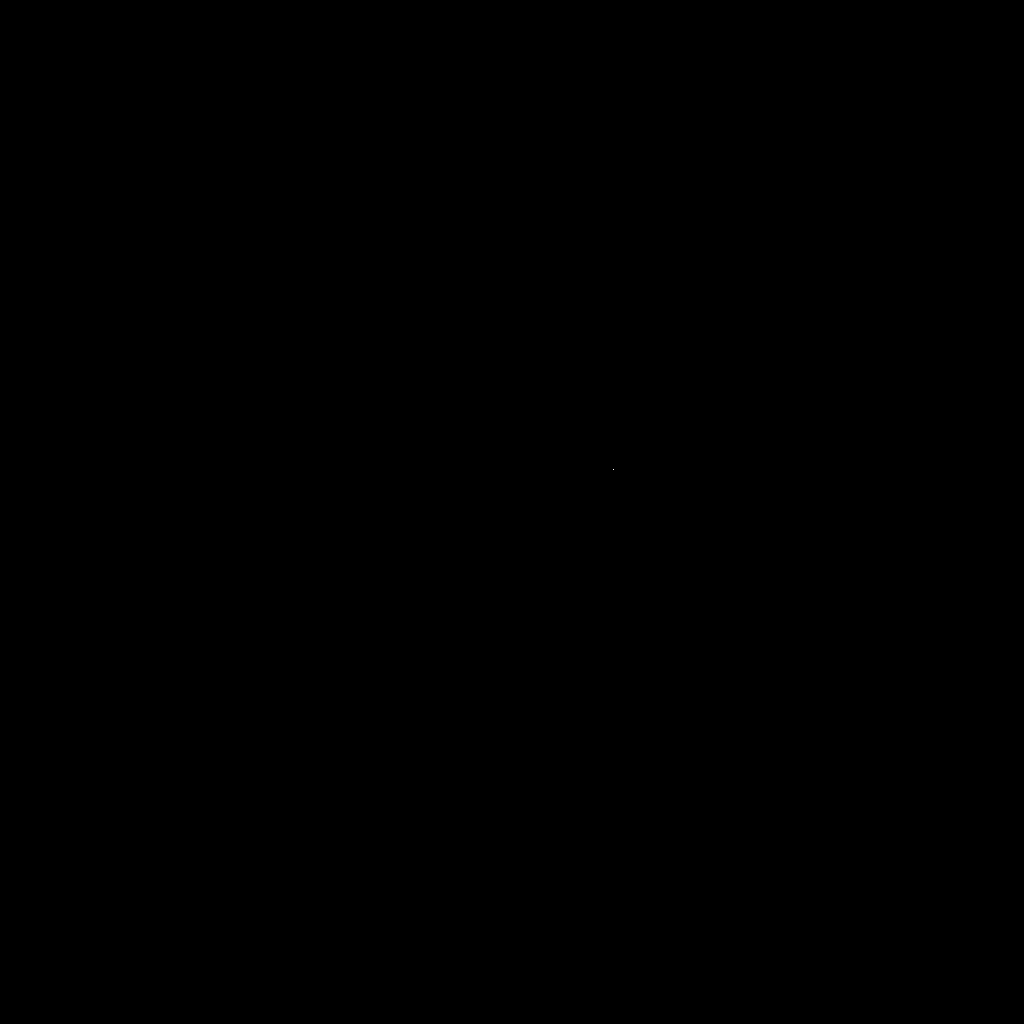

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 56%|█████▌    | 56/100 [05:52<04:40,  6.37s/it]

Loss: 0.2200895994901657

0: 288x640 29 tooths, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


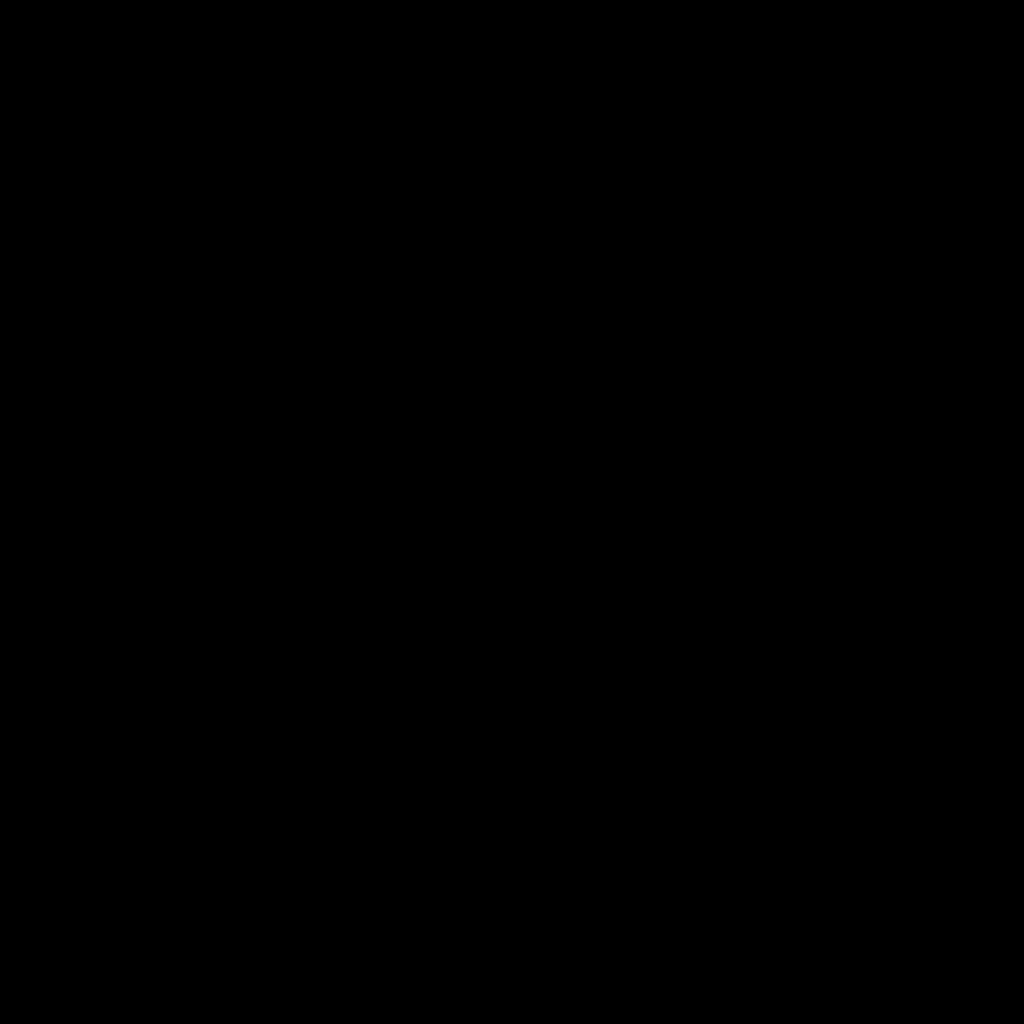

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 57%|█████▋    | 57/100 [05:58<04:32,  6.33s/it]

Loss: 0.21461129188537598

0: 288x640 28 tooths, 11.1ms
Speed: 3.8ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


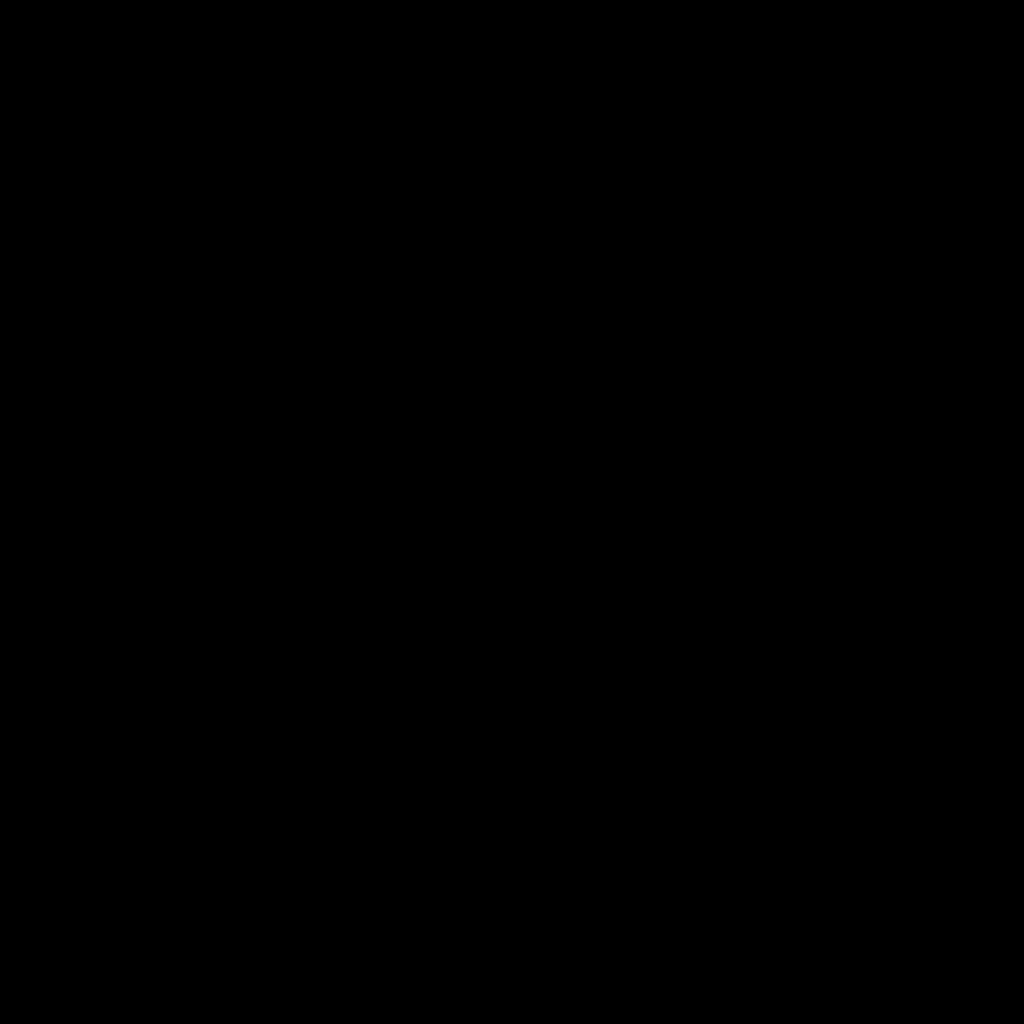

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 58%|█████▊    | 58/100 [06:04<04:18,  6.15s/it]

Loss: 0.1838648021221161

0: 288x640 28 tooths, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


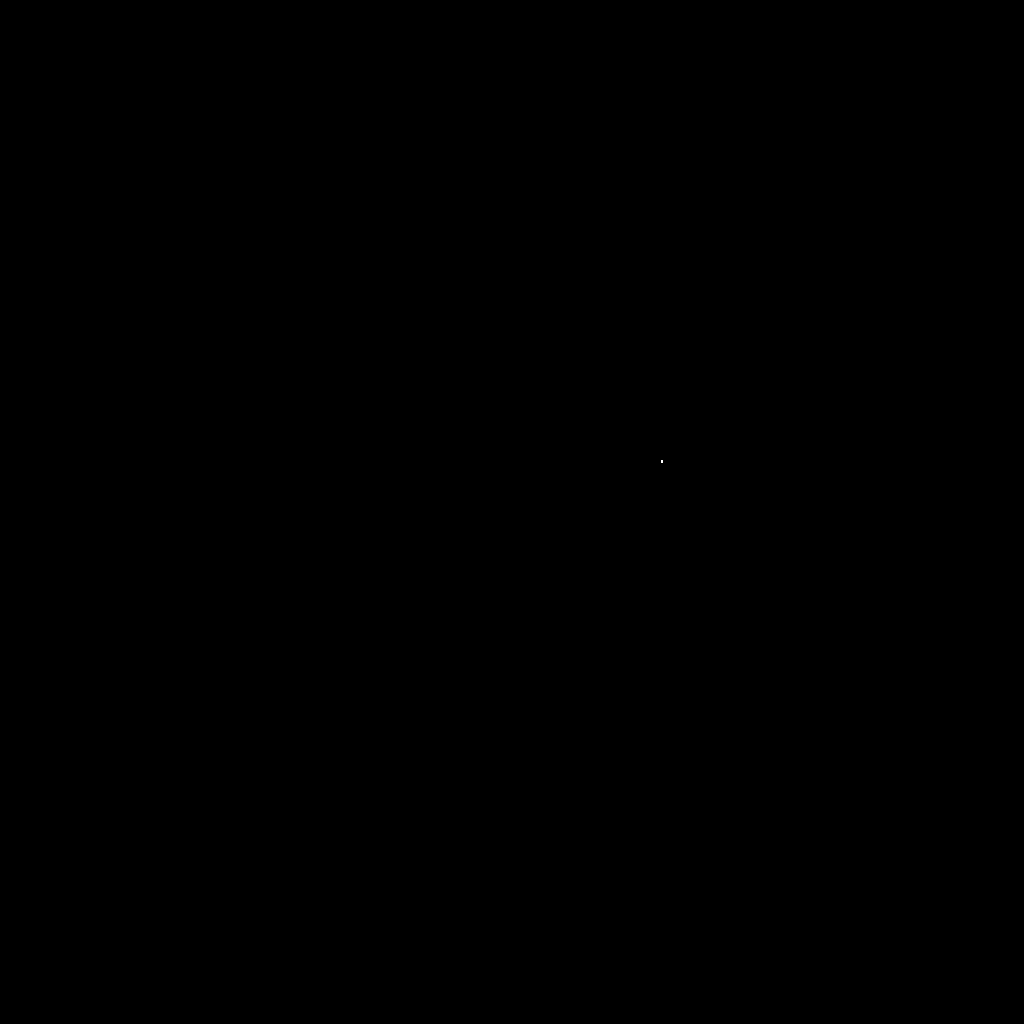

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 59%|█████▉    | 59/100 [06:10<04:17,  6.29s/it]

Loss: 0.18994291126728058

0: 288x640 30 tooths, 12.7ms
Speed: 2.6ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


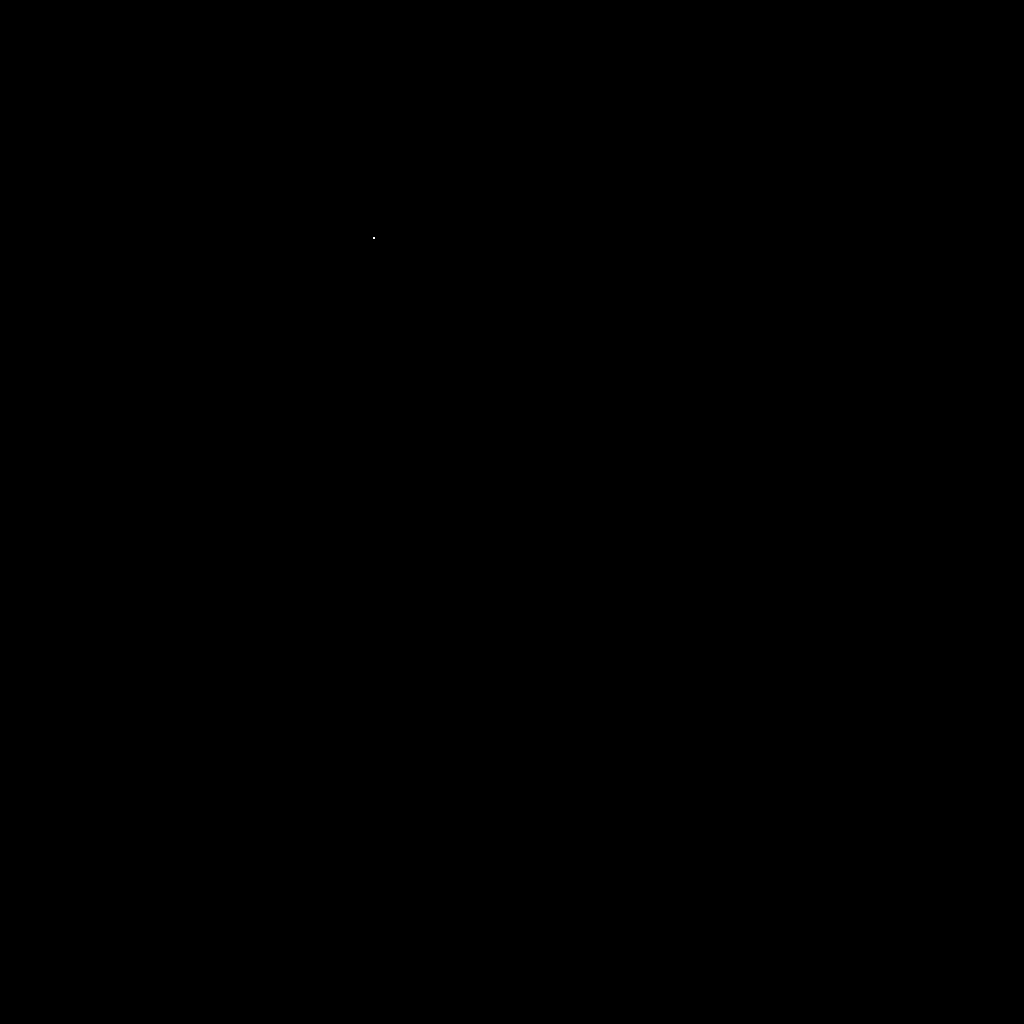

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 60%|██████    | 60/100 [06:17<04:09,  6.23s/it]

Loss: 0.22713571786880493

0: 288x640 23 tooths, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


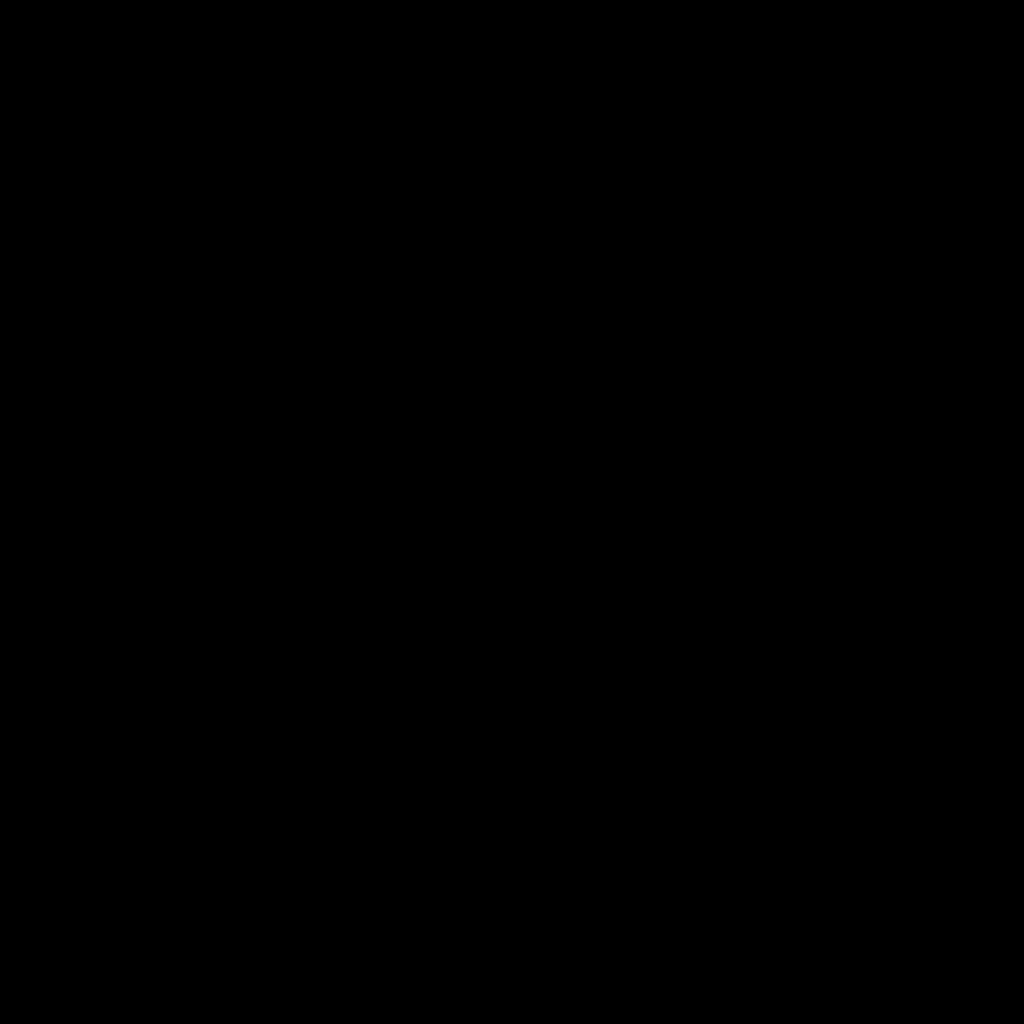

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 61%|██████    | 61/100 [06:23<04:00,  6.18s/it]

Loss: 0.18826542794704437

0: 288x640 29 tooths, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


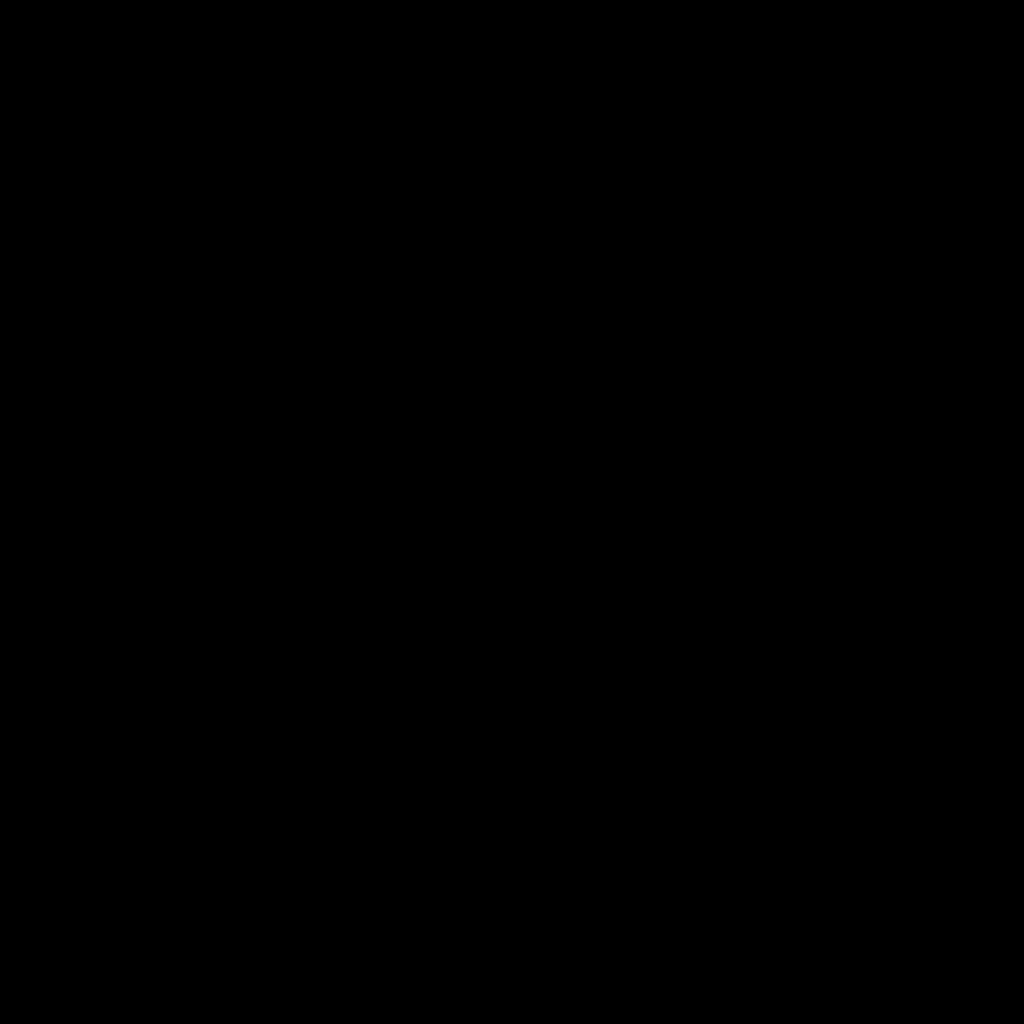

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 62%|██████▏   | 62/100 [06:28<03:50,  6.07s/it]

Loss: 0.23227325081825256

0: 288x640 27 tooths, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


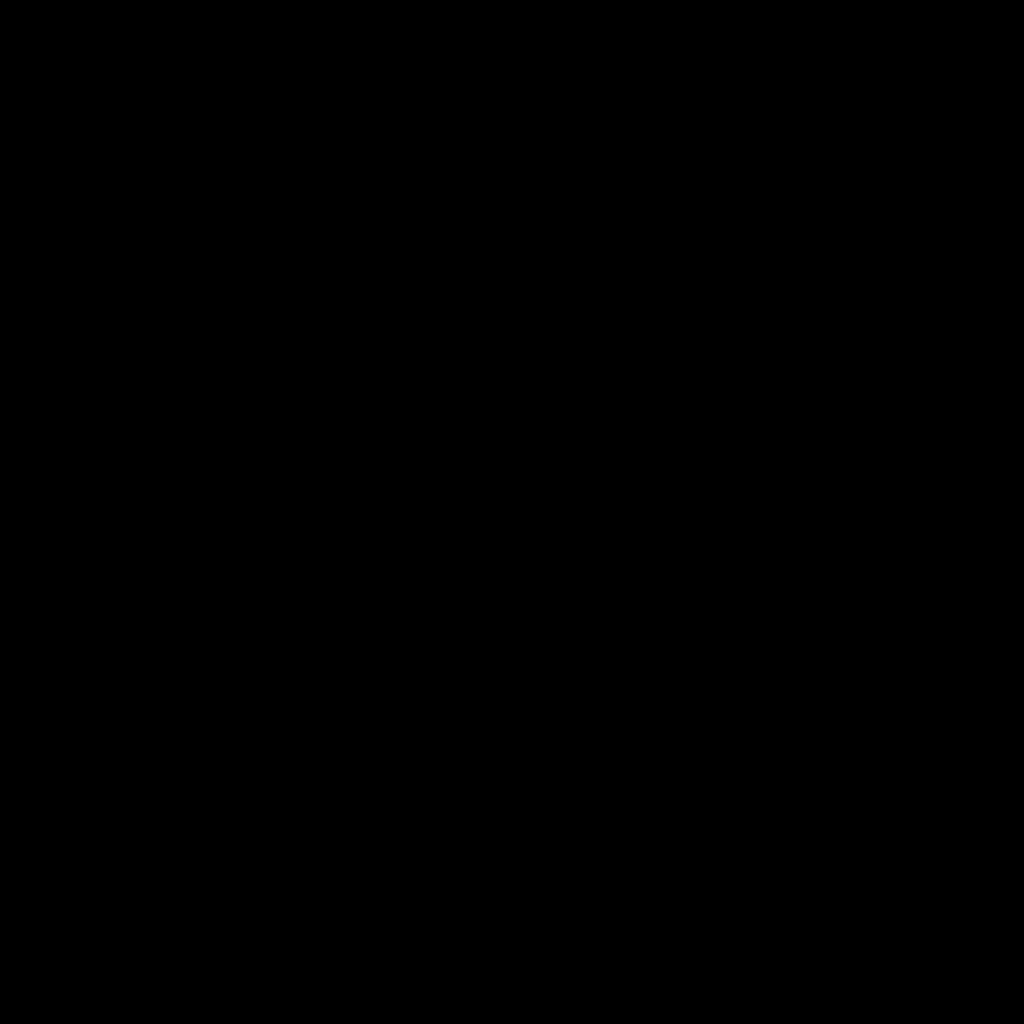

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 63%|██████▎   | 63/100 [06:35<03:55,  6.37s/it]

Loss: 0.2037794291973114

0: 288x640 25 tooths, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


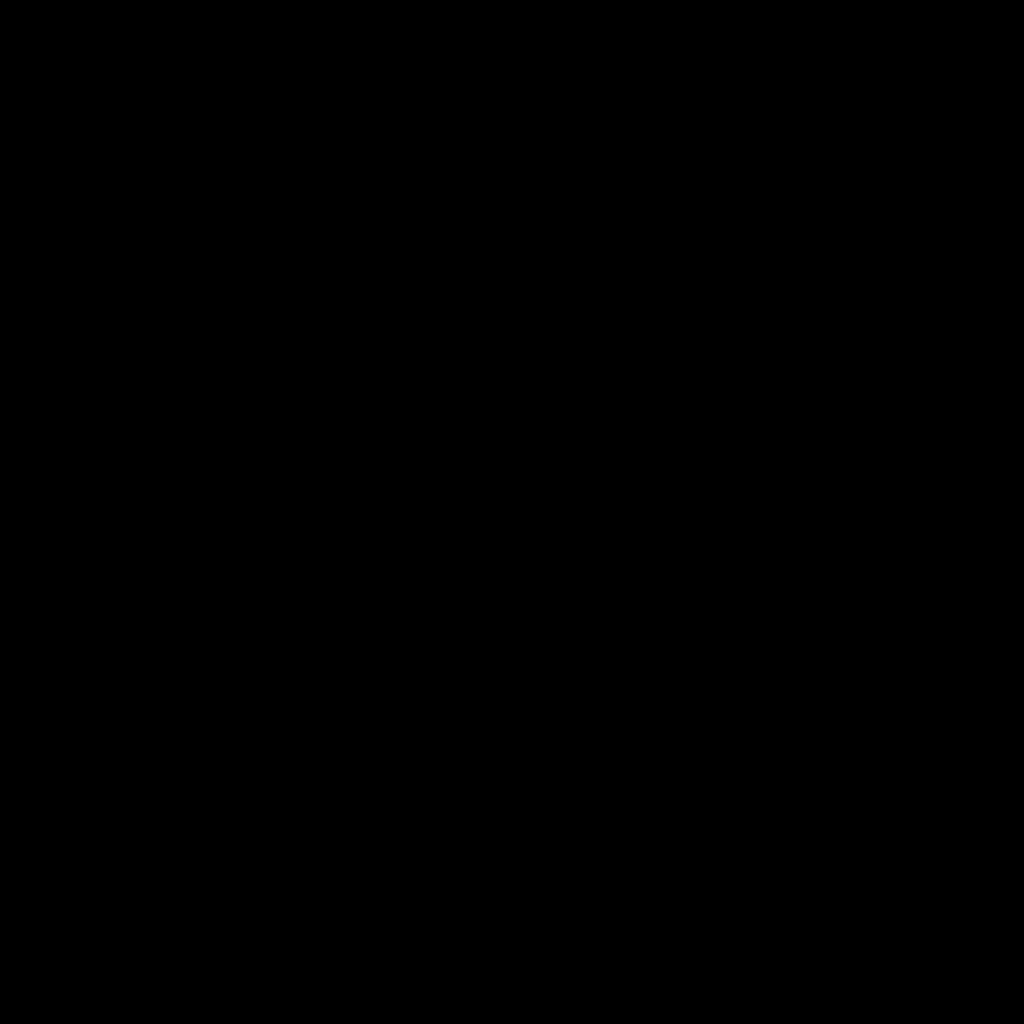

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 64%|██████▍   | 64/100 [06:41<03:35,  6.00s/it]

Loss: 0.13392630219459534

0: 288x640 29 tooths, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


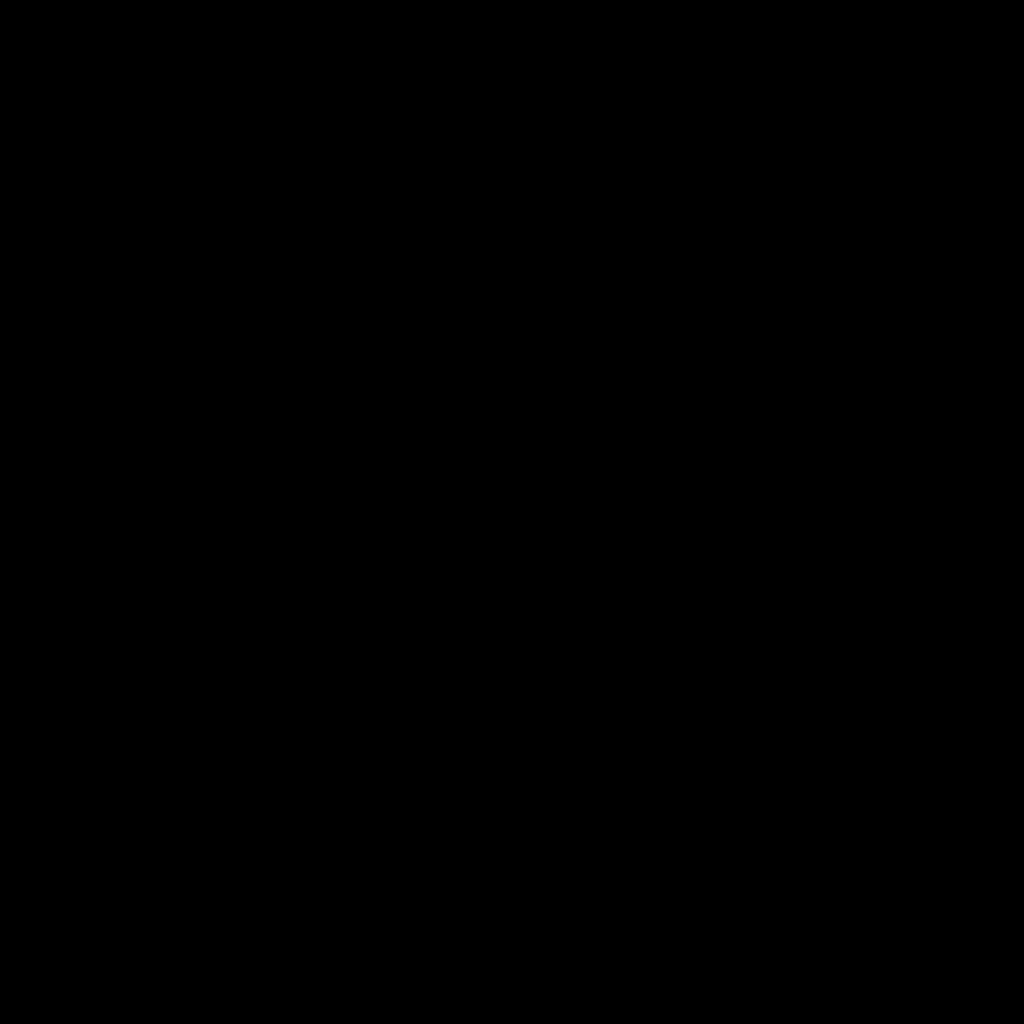

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 65%|██████▌   | 65/100 [06:48<03:44,  6.41s/it]

Loss: 0.18918122351169586

0: 288x640 32 tooths, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


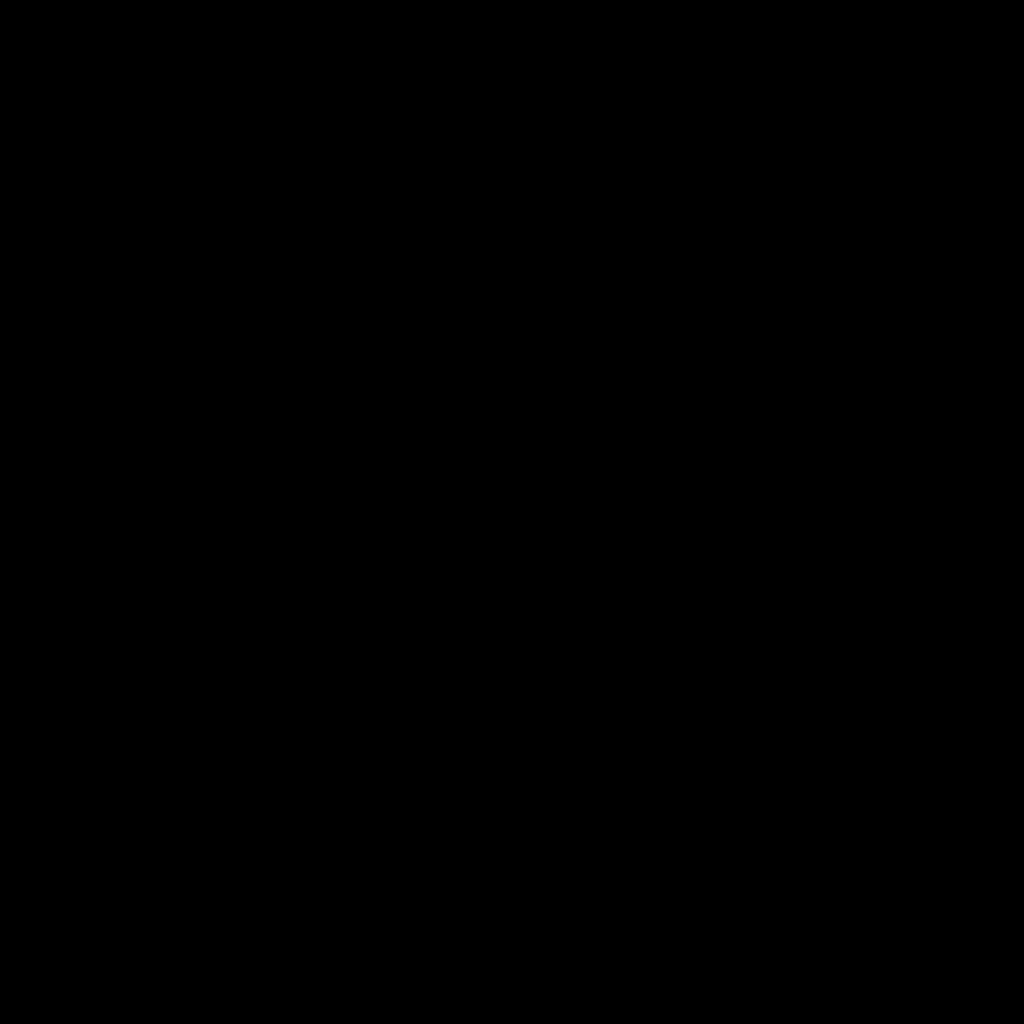

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 66%|██████▌   | 66/100 [06:54<03:37,  6.39s/it]

Loss: 0.25792309641838074

0: 288x640 29 tooths, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


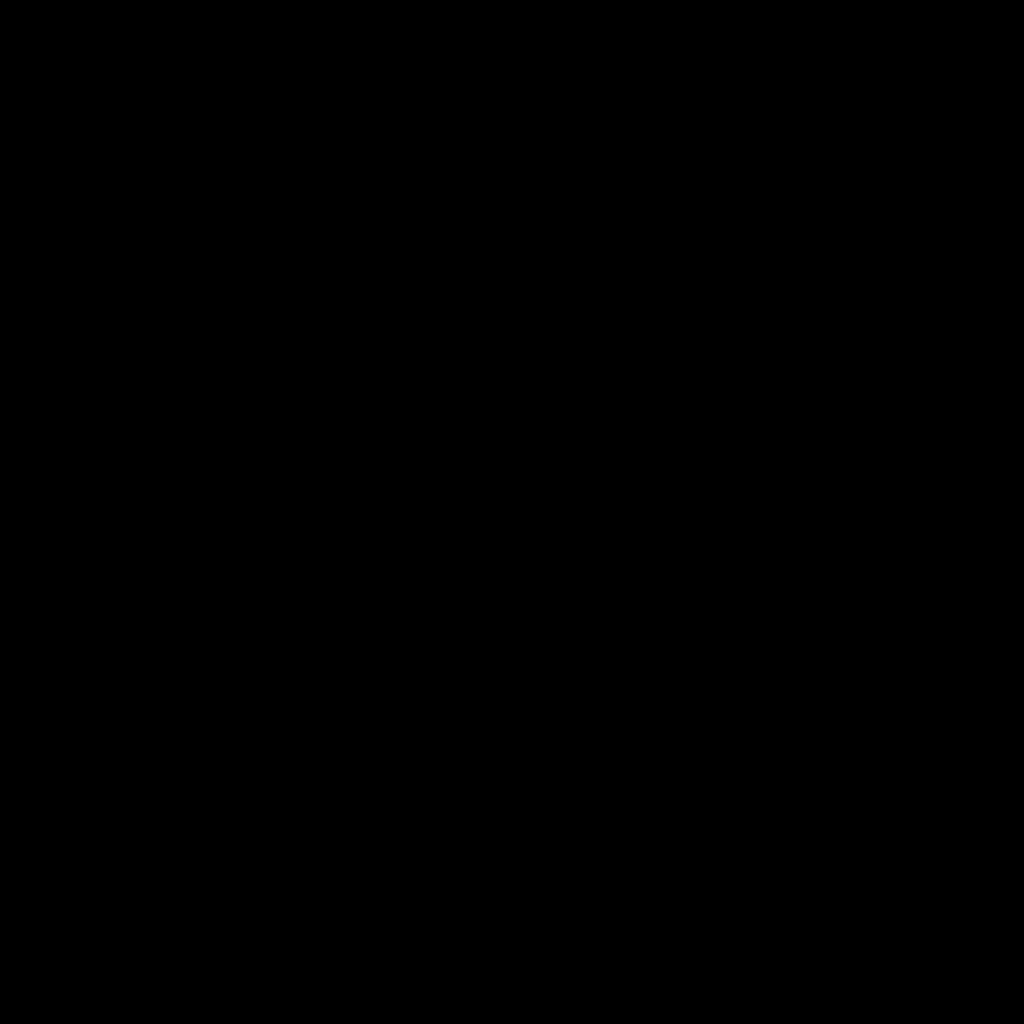

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 67%|██████▋   | 67/100 [07:02<03:39,  6.66s/it]

Loss: 0.23227325081825256

0: 288x640 31 tooths, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


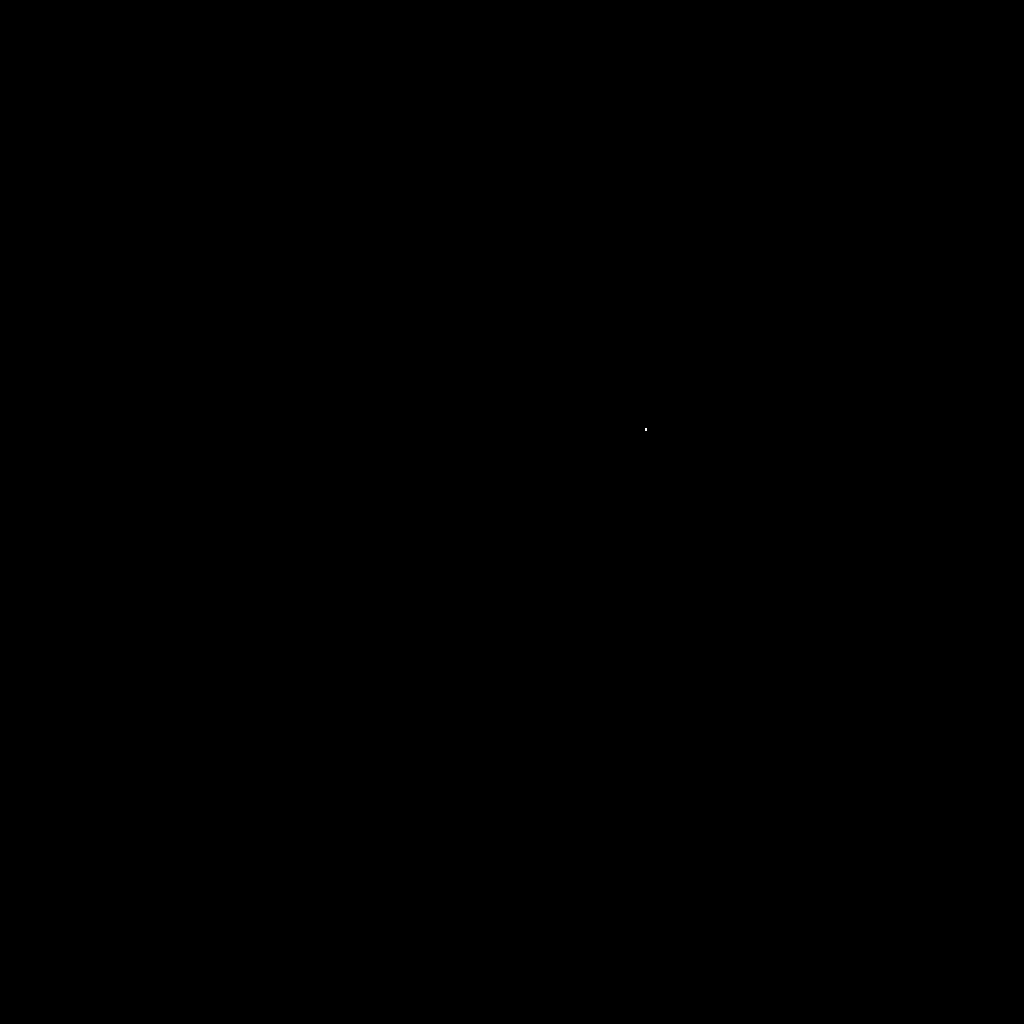

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 68%|██████▊   | 68/100 [07:08<03:30,  6.56s/it]

Loss: 0.20052798092365265

0: 288x640 28 tooths, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


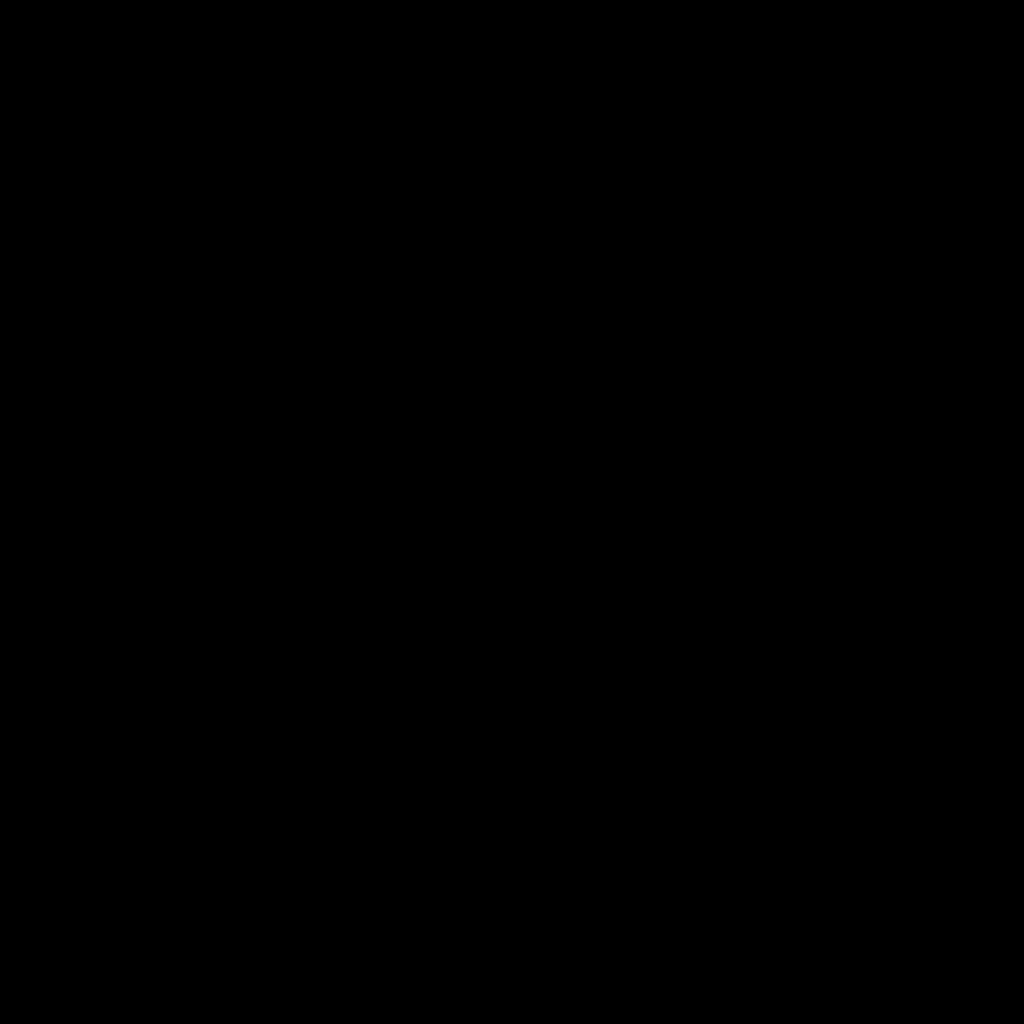

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 69%|██████▉   | 69/100 [07:15<03:28,  6.73s/it]

Loss: 0.1809464693069458

0: 288x640 33 tooths, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


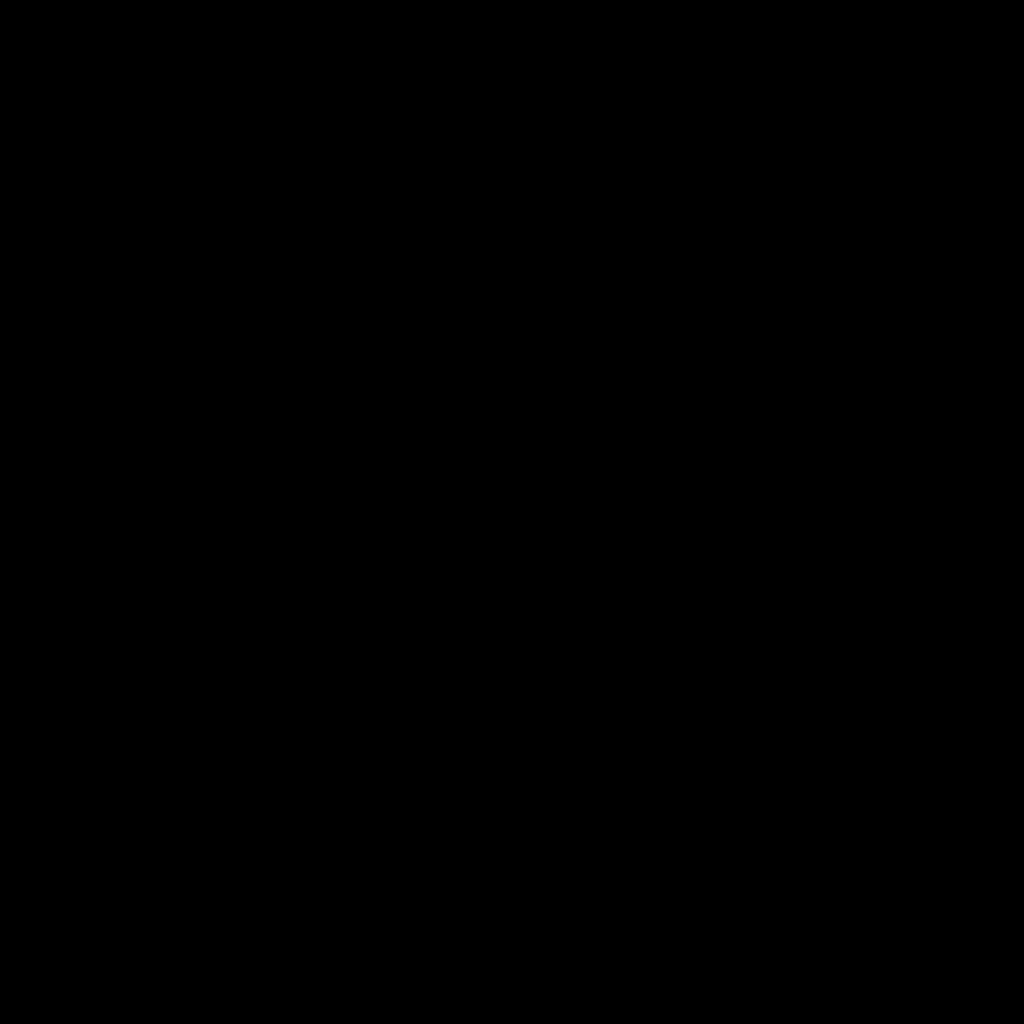

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 70%|███████   | 70/100 [07:22<03:19,  6.67s/it]

Loss: 0.23532341420650482

0: 288x640 28 tooths, 11.3ms
Speed: 2.1ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


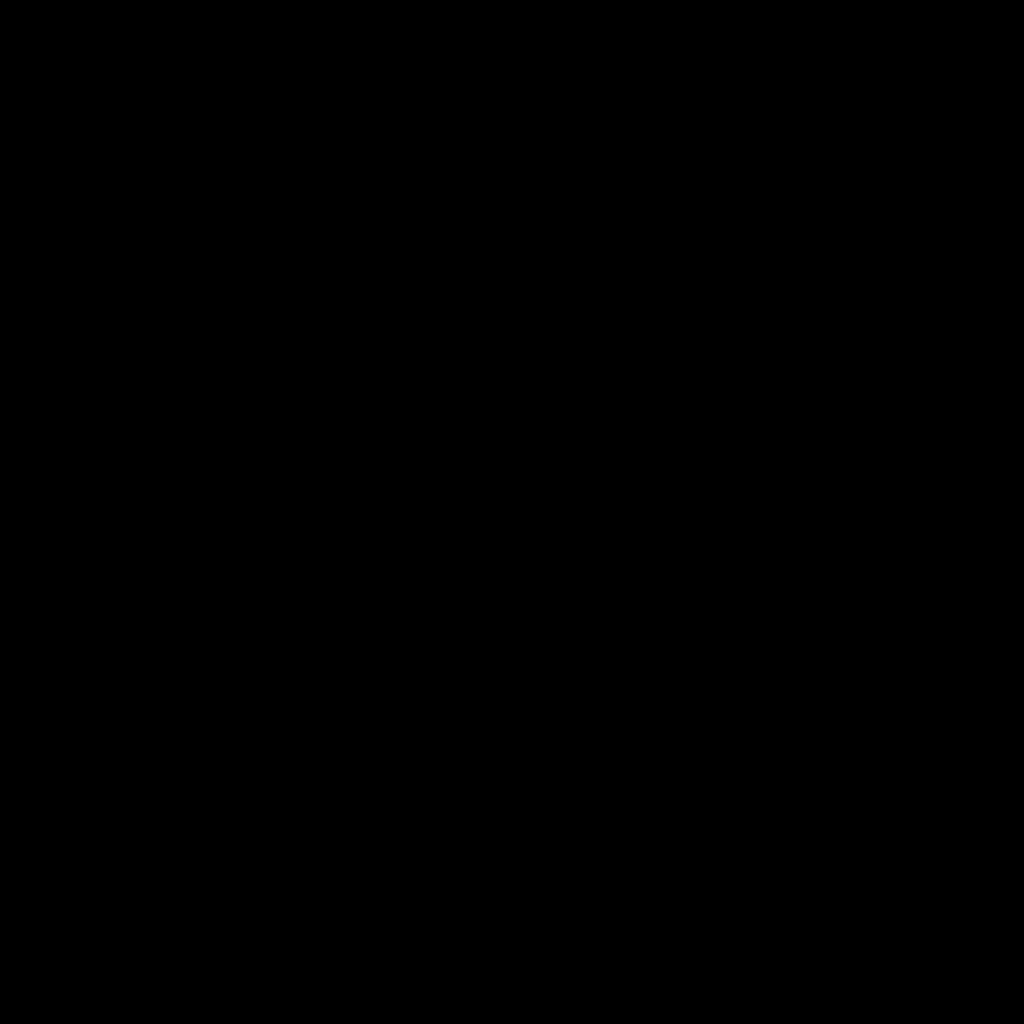

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 71%|███████   | 71/100 [07:29<03:17,  6.81s/it]

Loss: 0.1809464693069458

0: 288x640 29 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


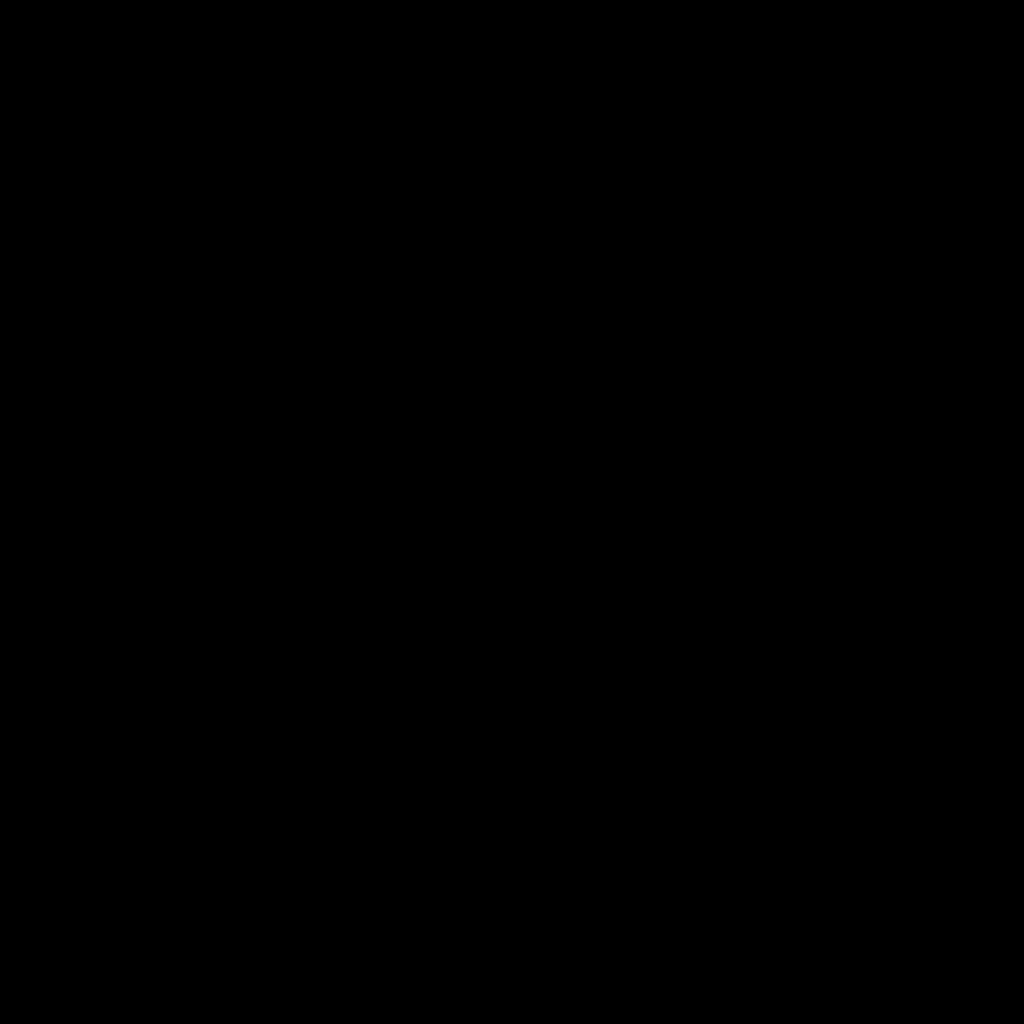

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 72%|███████▏  | 72/100 [07:35<03:02,  6.52s/it]

Loss: 0.23700128495693207

0: 288x640 (no detections), 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)


 73%|███████▎  | 73/100 [07:35<02:07,  4.74s/it]


0: 288x640 30 tooths, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


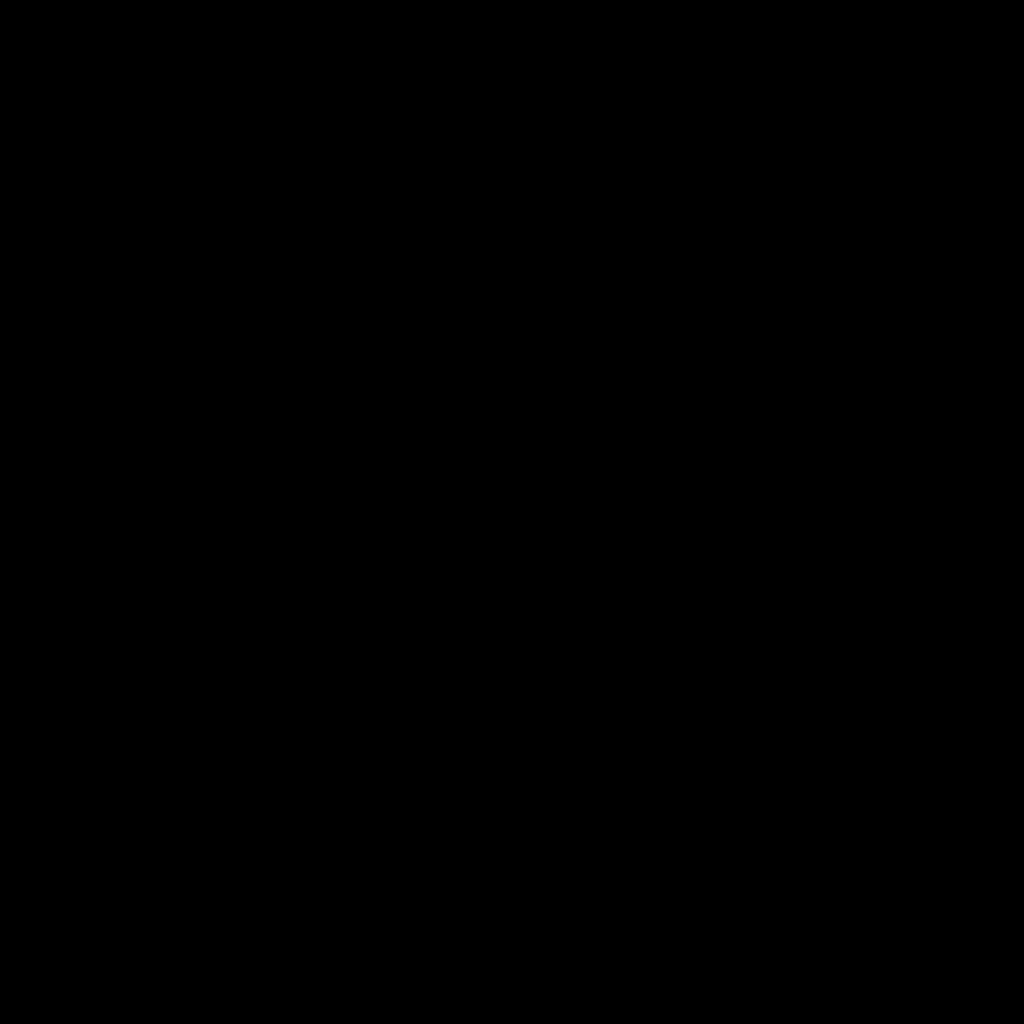

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 74%|███████▍  | 74/100 [07:42<02:22,  5.48s/it]

Loss: 0.15461641550064087

0: 288x640 29 tooths, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


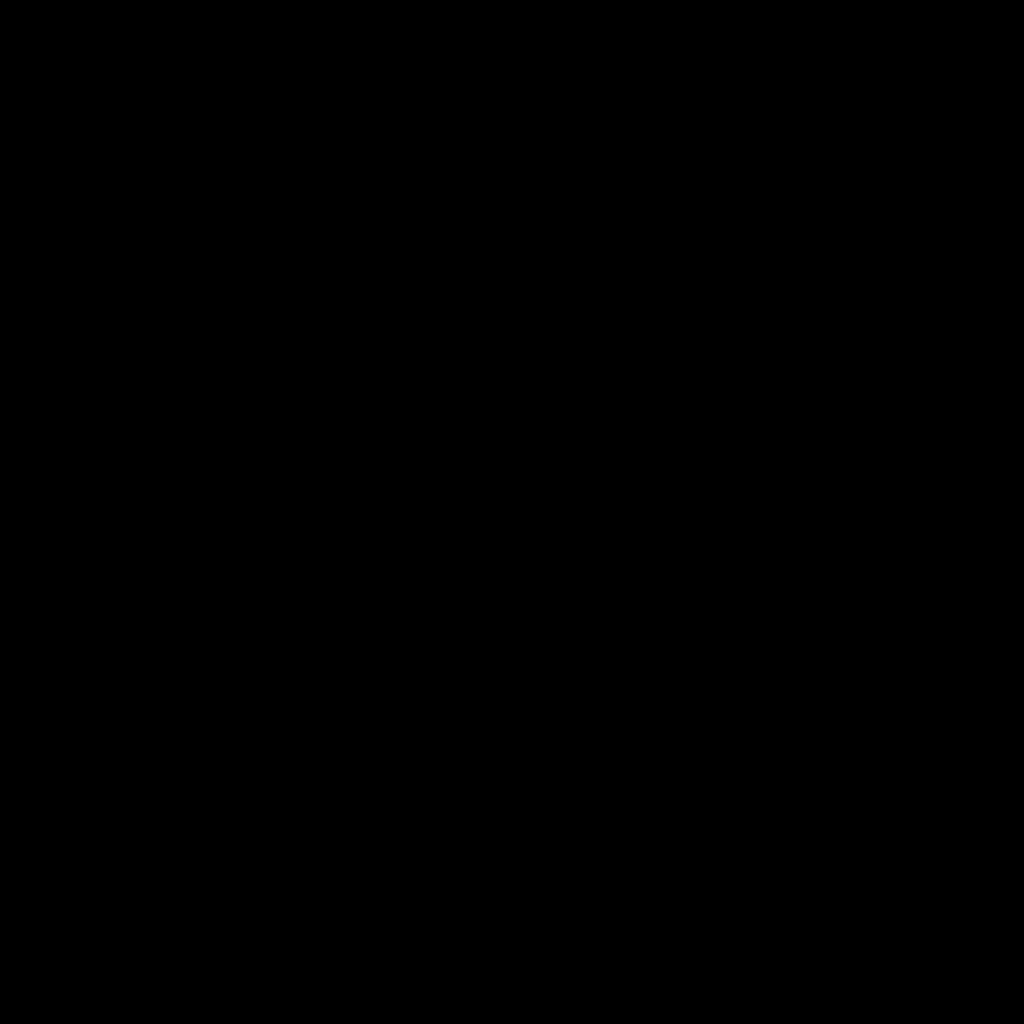

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 75%|███████▌  | 75/100 [07:48<02:19,  5.58s/it]

Loss: 0.18918122351169586

0: 288x640 16 tooths, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


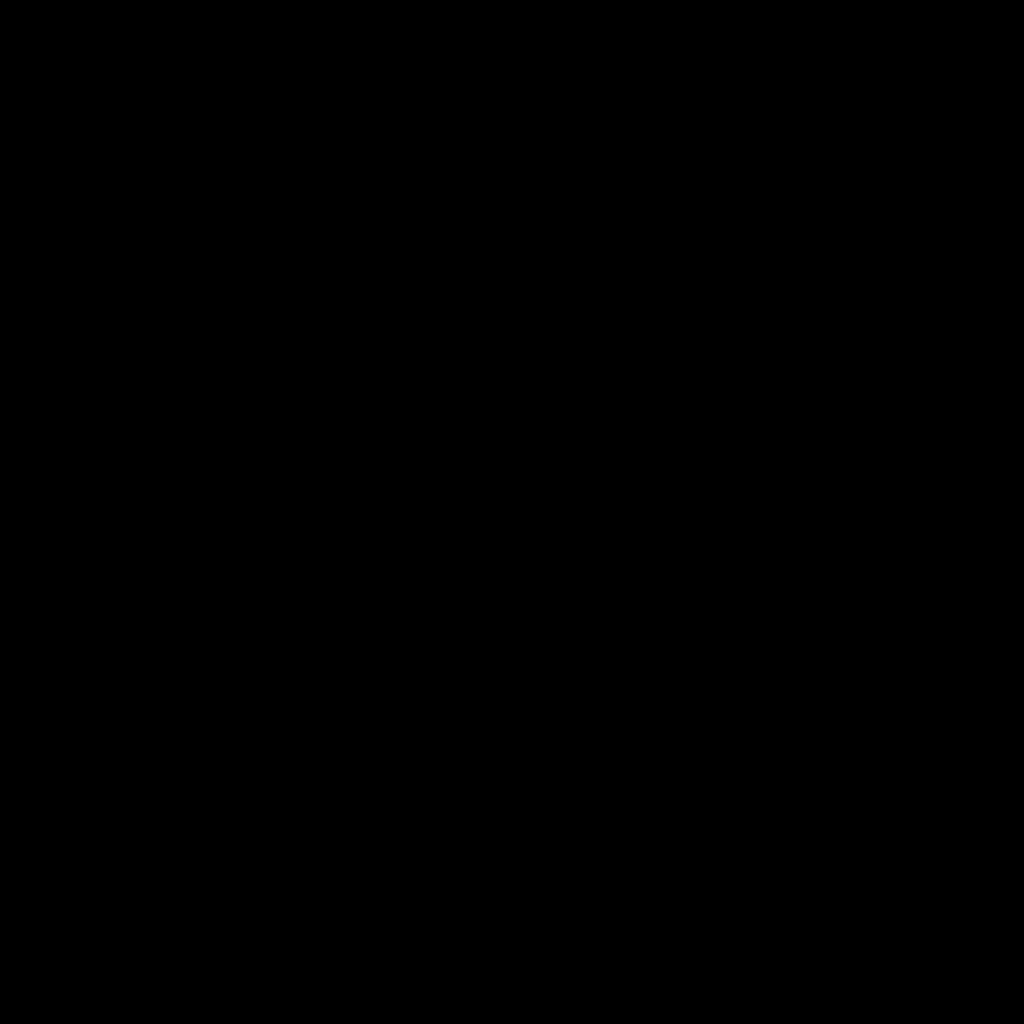

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 76%|███████▌  | 76/100 [07:53<02:09,  5.38s/it]

Loss: 0.09450368583202362

0: 288x640 31 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


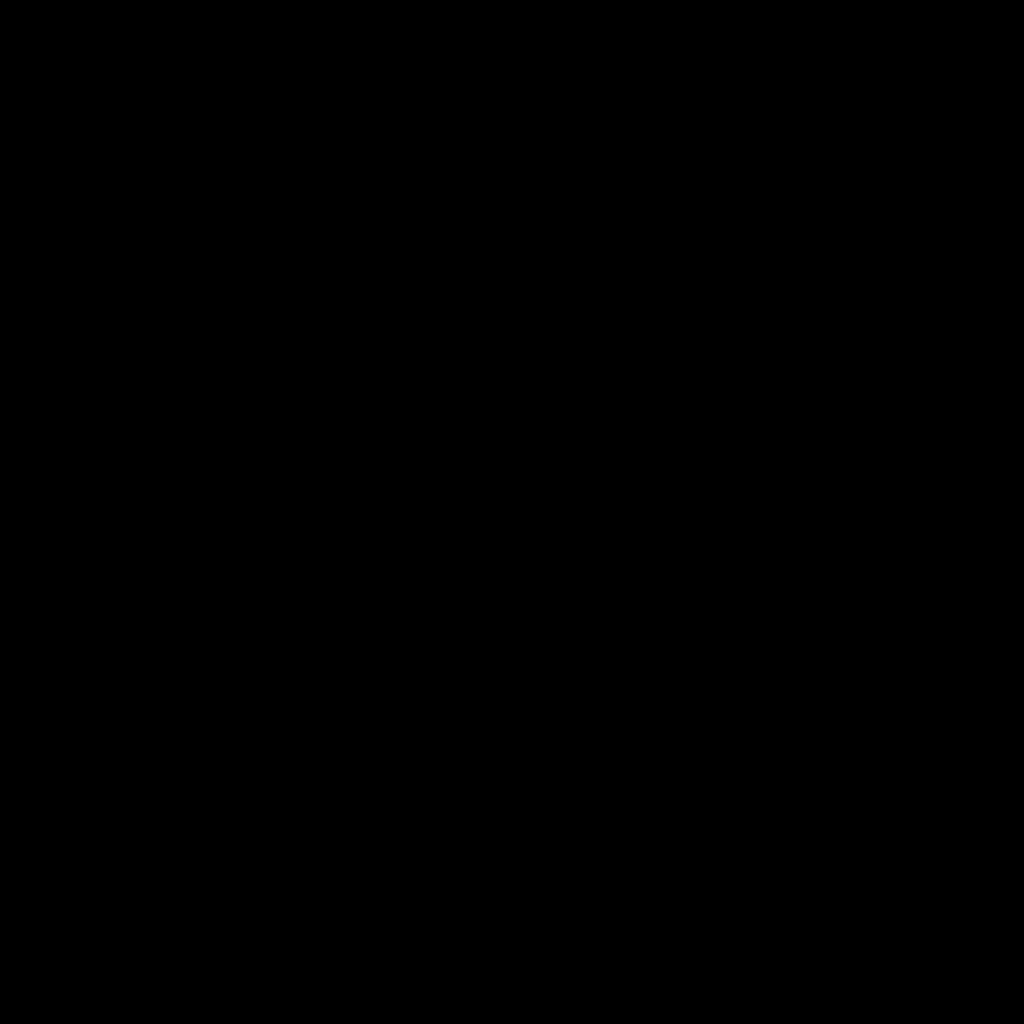

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 77%|███████▋  | 77/100 [07:59<02:08,  5.59s/it]

Loss: 0.21360886096954346

0: 288x640 32 tooths, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


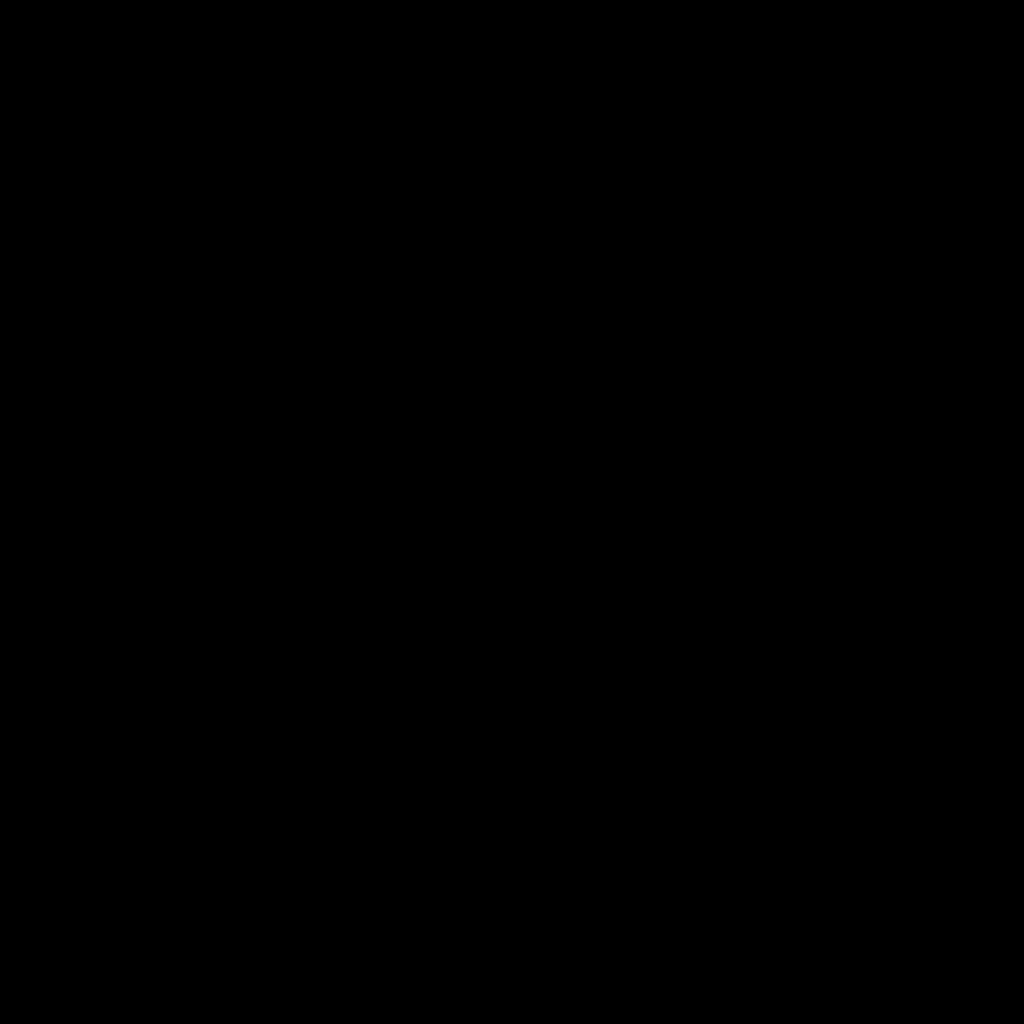

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 78%|███████▊  | 78/100 [08:07<02:17,  6.25s/it]

Loss: 0.20845364034175873

0: 288x640 28 tooths, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


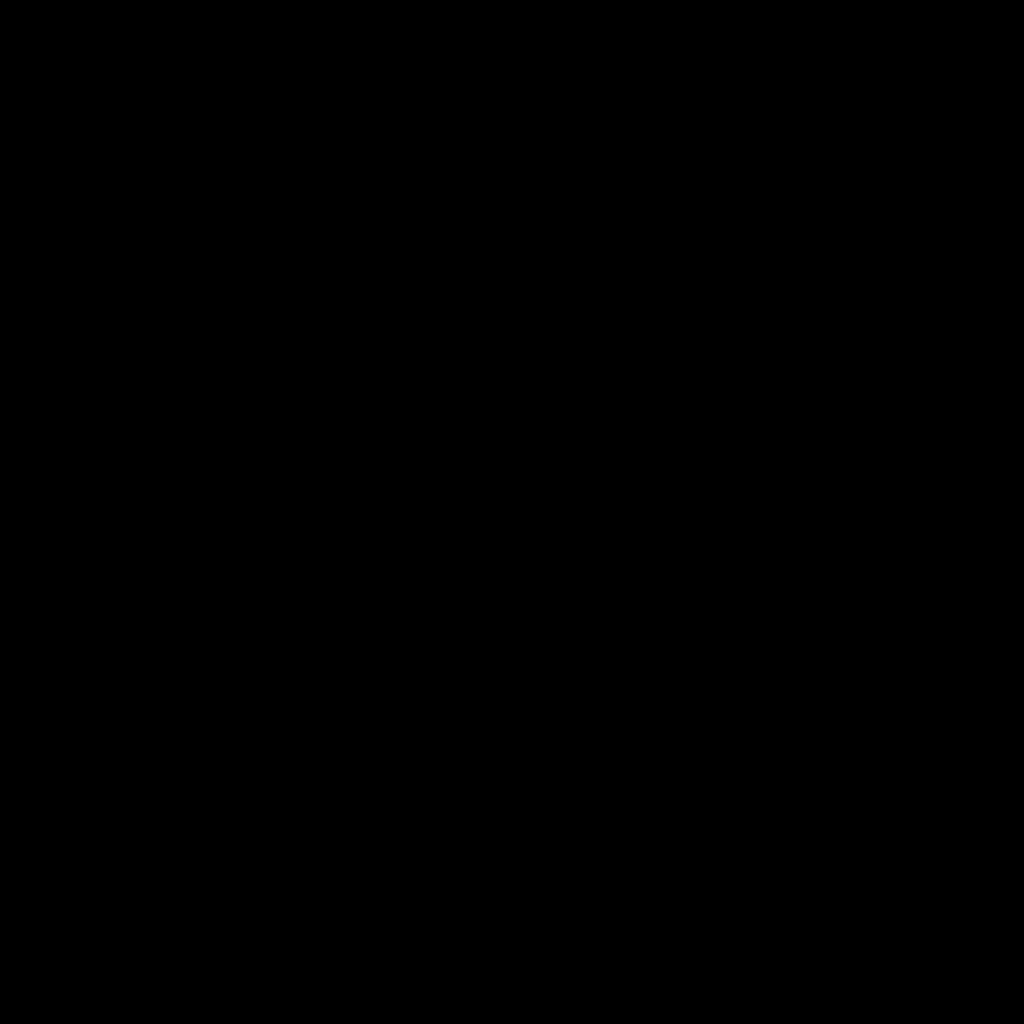

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 79%|███████▉  | 79/100 [08:13<02:07,  6.07s/it]

Loss: 0.20279540121555328

0: 288x640 31 tooths, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


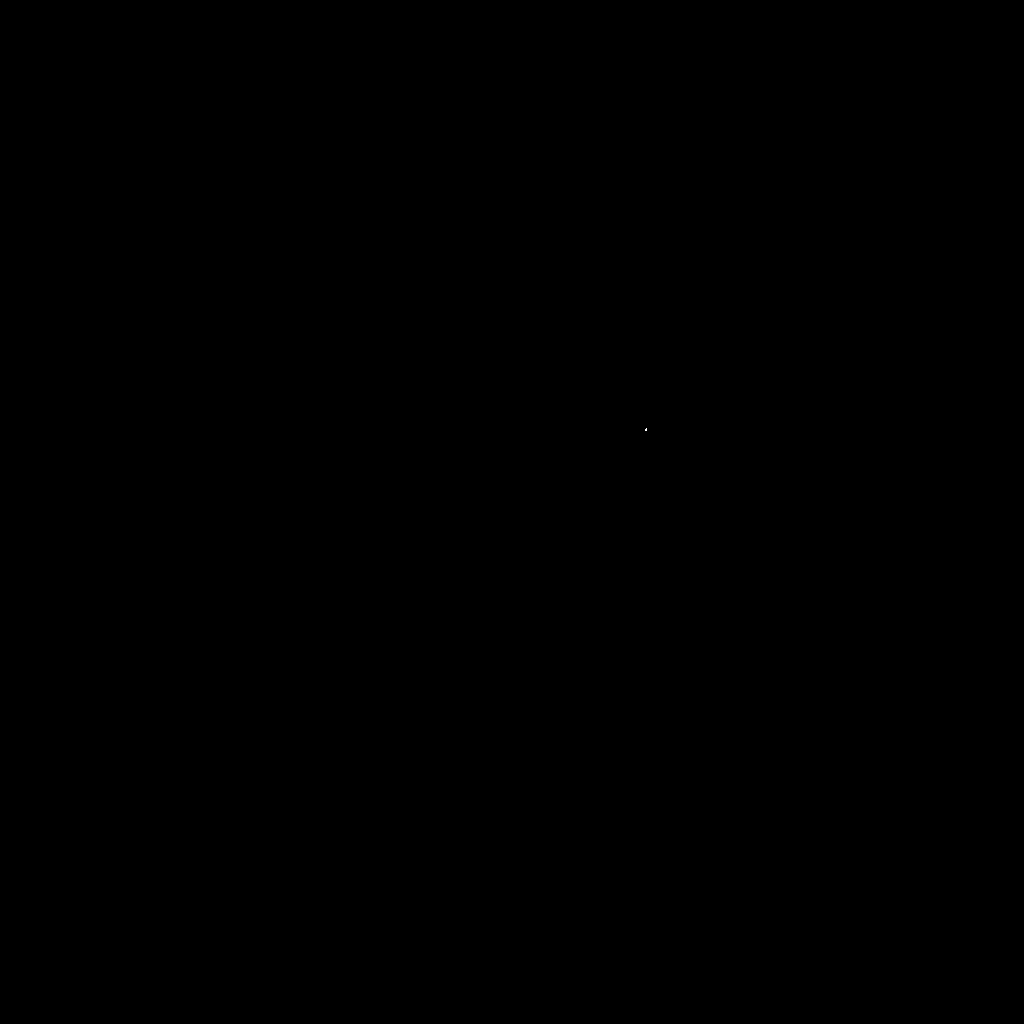

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 80%|████████  | 80/100 [08:20<02:10,  6.52s/it]

Loss: 0.20052847266197205

0: 288x640 29 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


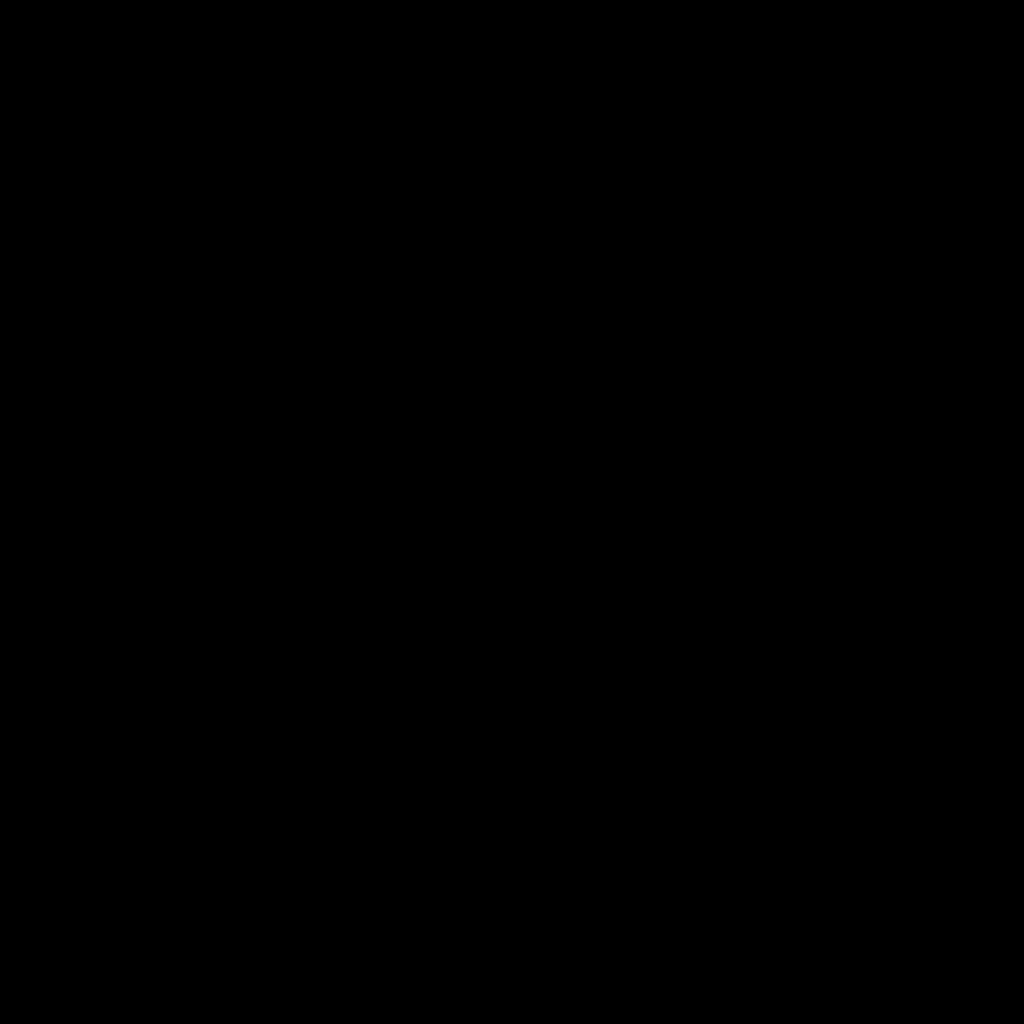

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 81%|████████  | 81/100 [08:26<02:00,  6.32s/it]

Loss: 0.18427681922912598

0: 288x640 32 tooths, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


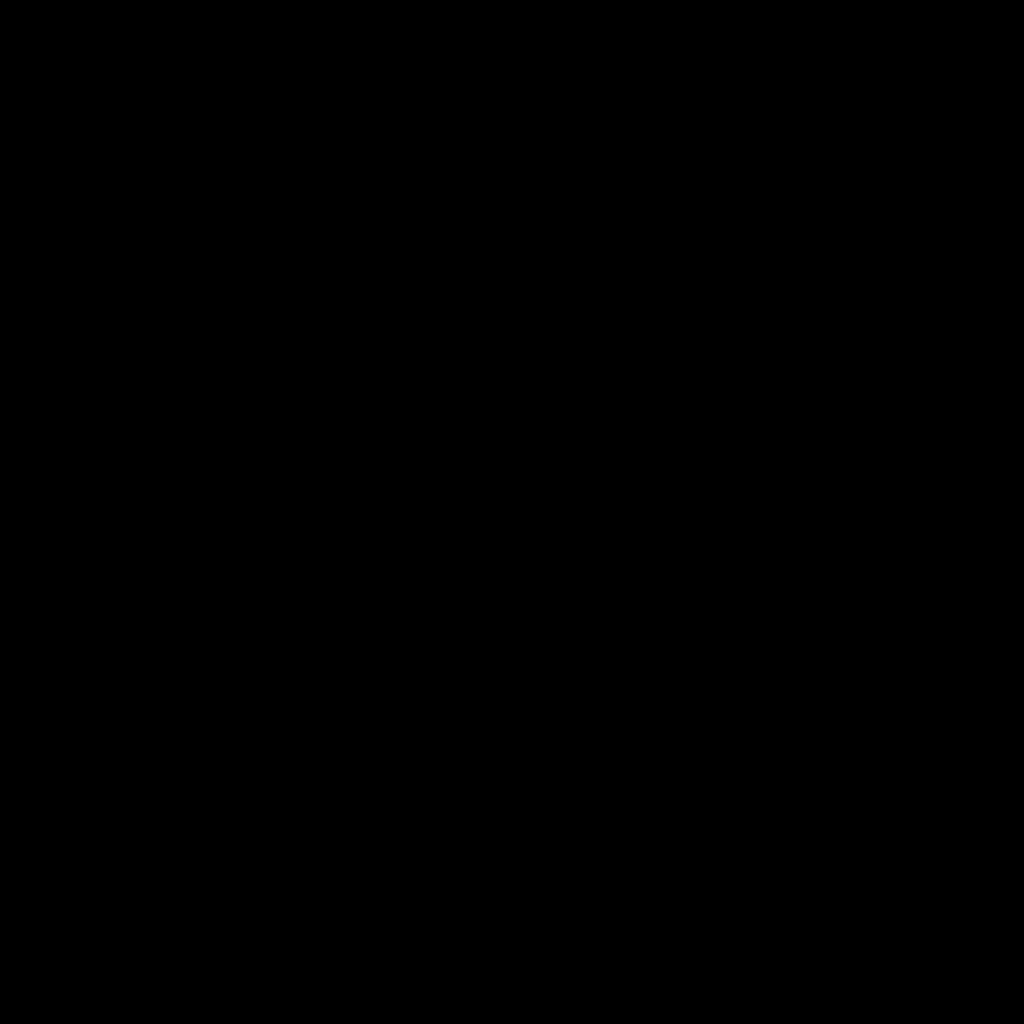

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 82%|████████▏ | 82/100 [08:34<02:02,  6.78s/it]

Loss: 0.24056313931941986

0: 288x640 24 tooths, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


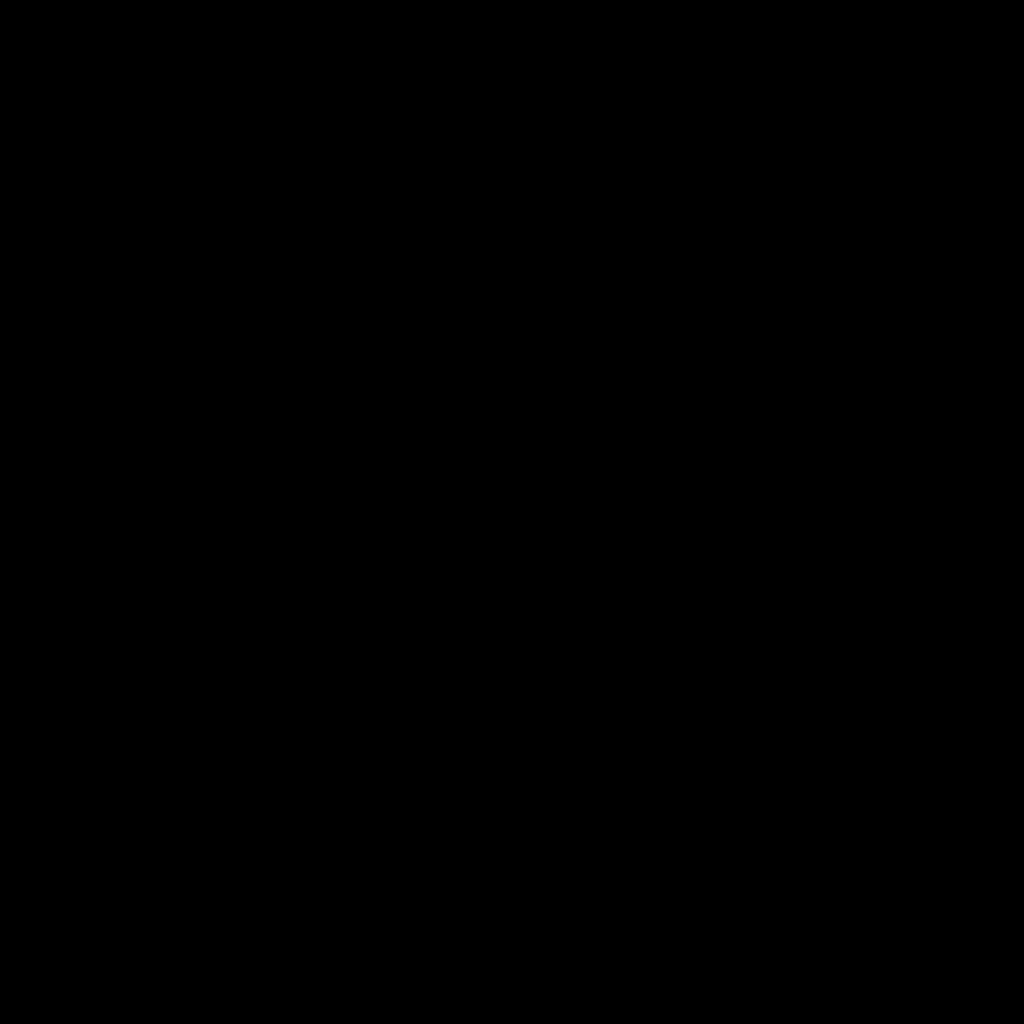

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 83%|████████▎ | 83/100 [08:39<01:46,  6.26s/it]

Loss: 0.1321166455745697

0: 288x640 25 tooths, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


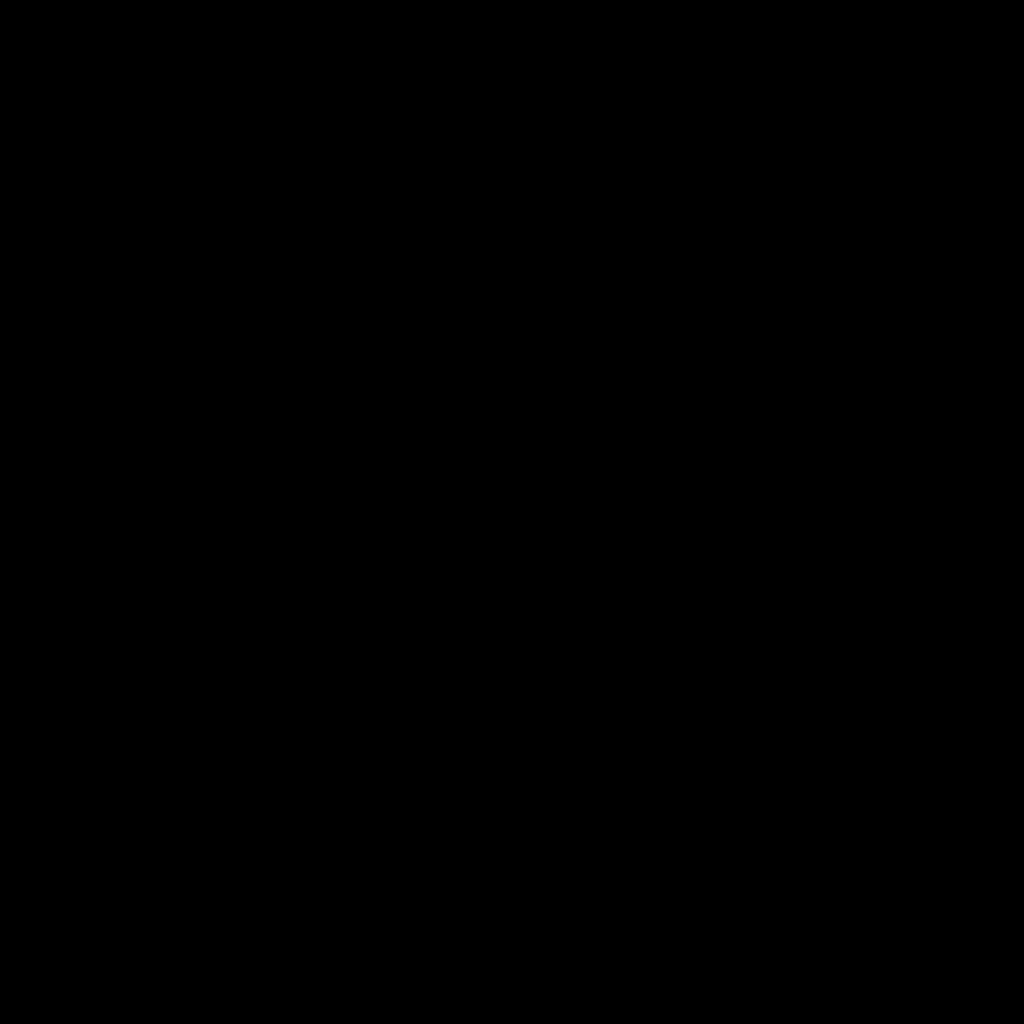

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 84%|████████▍ | 84/100 [08:45<01:41,  6.35s/it]

Loss: 0.1389804482460022

0: 288x640 30 tooths, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


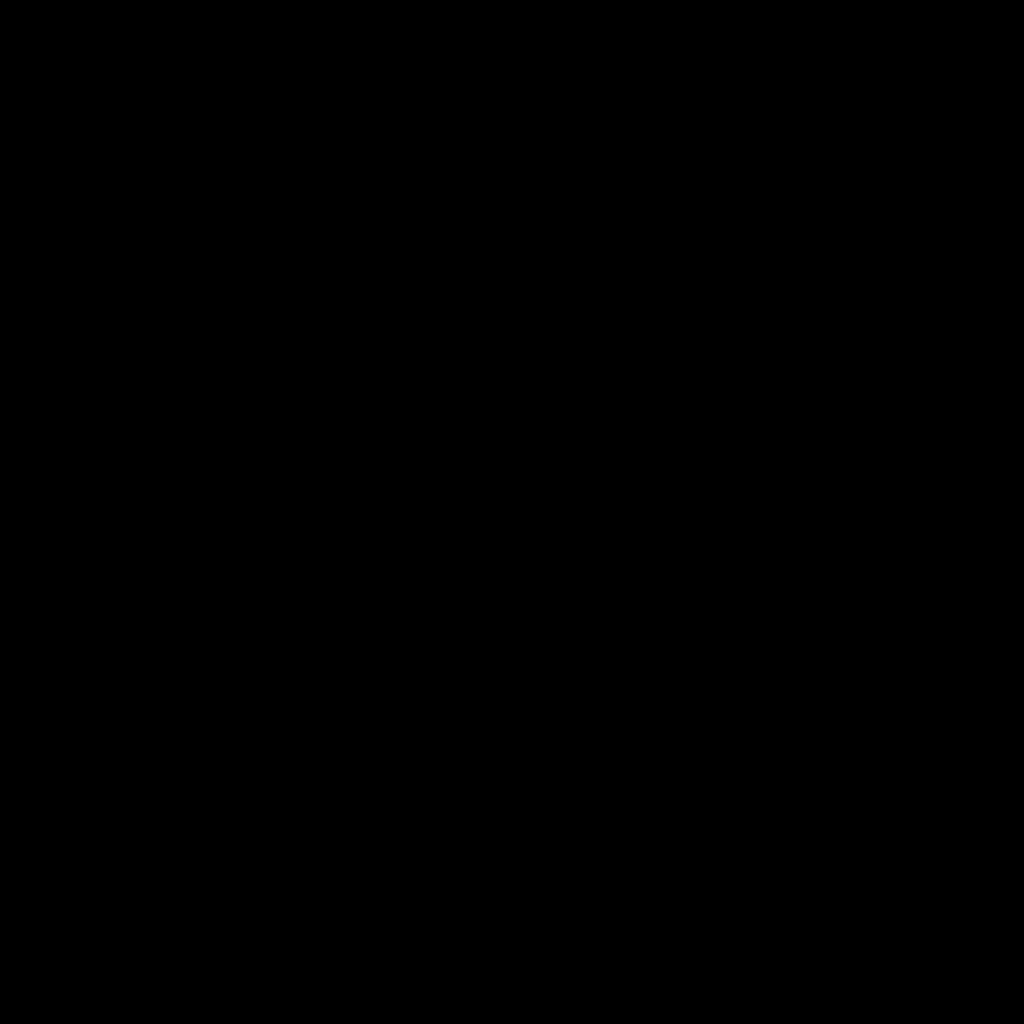

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 85%|████████▌ | 85/100 [08:51<01:33,  6.23s/it]

Loss: 0.22330224514007568

0: 288x640 25 tooths, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


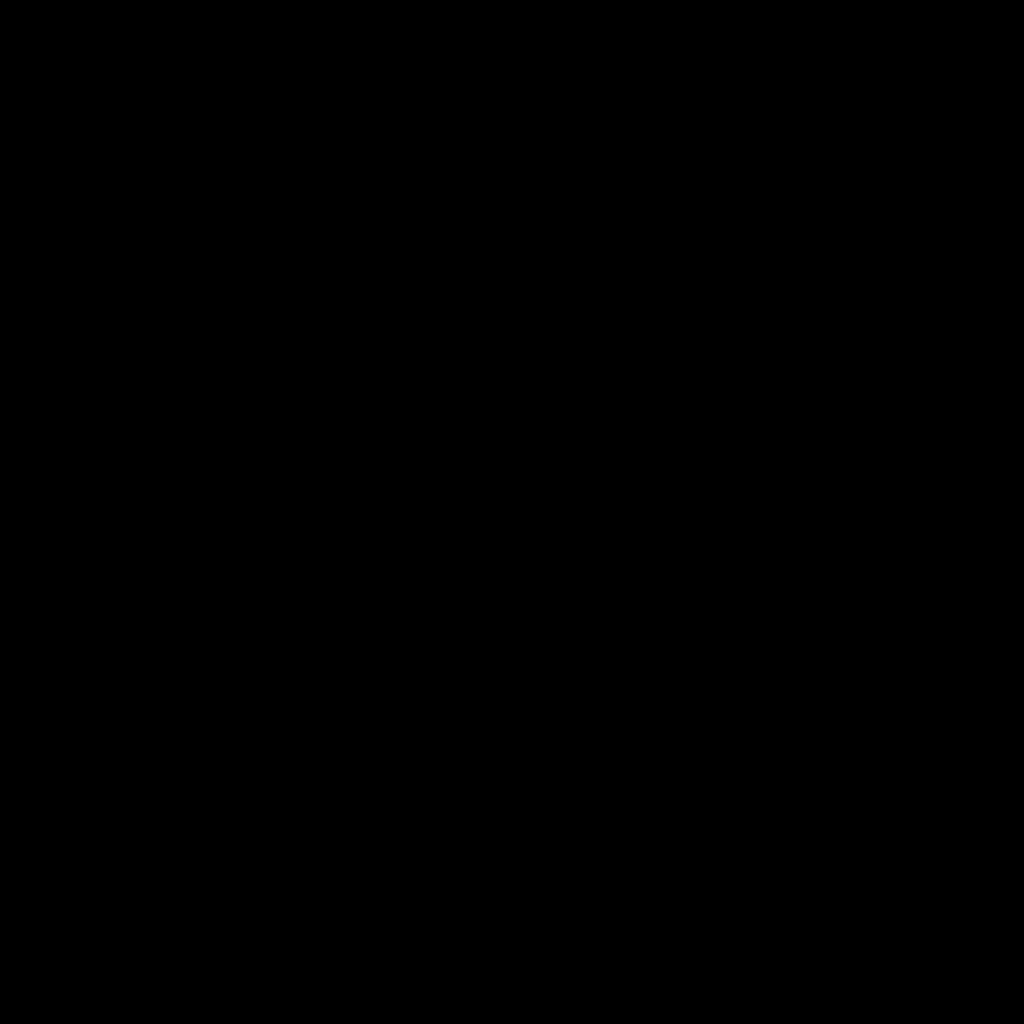

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 86%|████████▌ | 86/100 [08:58<01:28,  6.32s/it]

Loss: 0.17567633092403412

0: 288x640 28 tooths, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


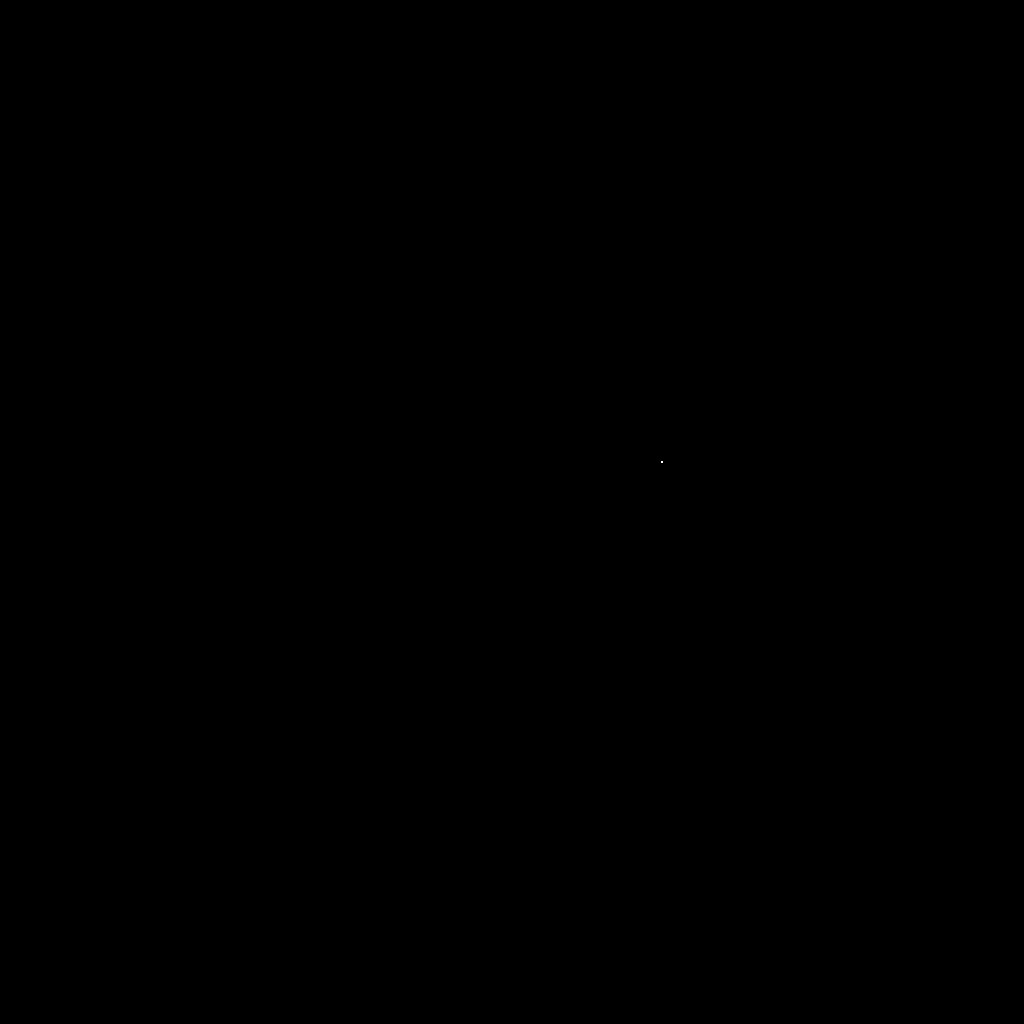

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 87%|████████▋ | 87/100 [09:05<01:25,  6.56s/it]

Loss: 0.1899448186159134

0: 288x640 27 tooths, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


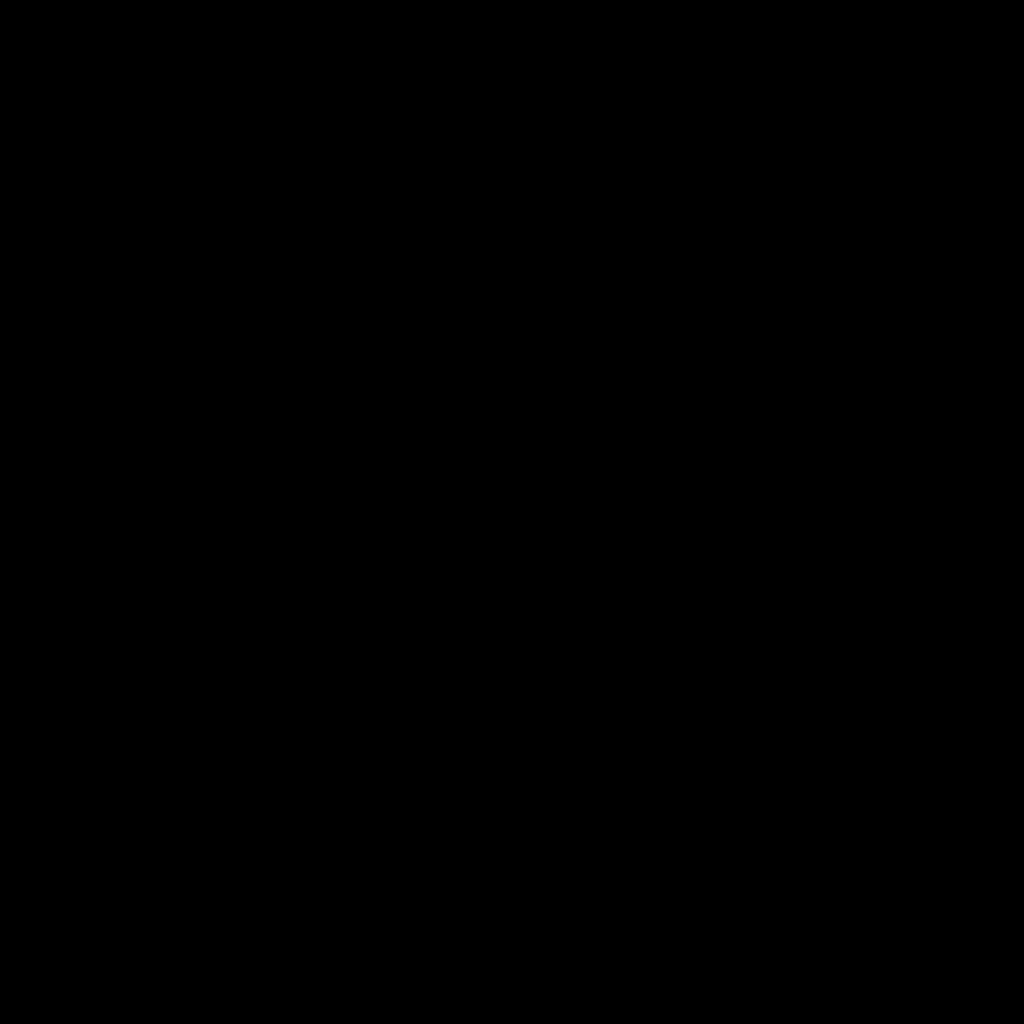

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 88%|████████▊ | 88/100 [09:12<01:20,  6.70s/it]

Loss: 0.18657559156417847

0: 288x640 27 tooths, 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


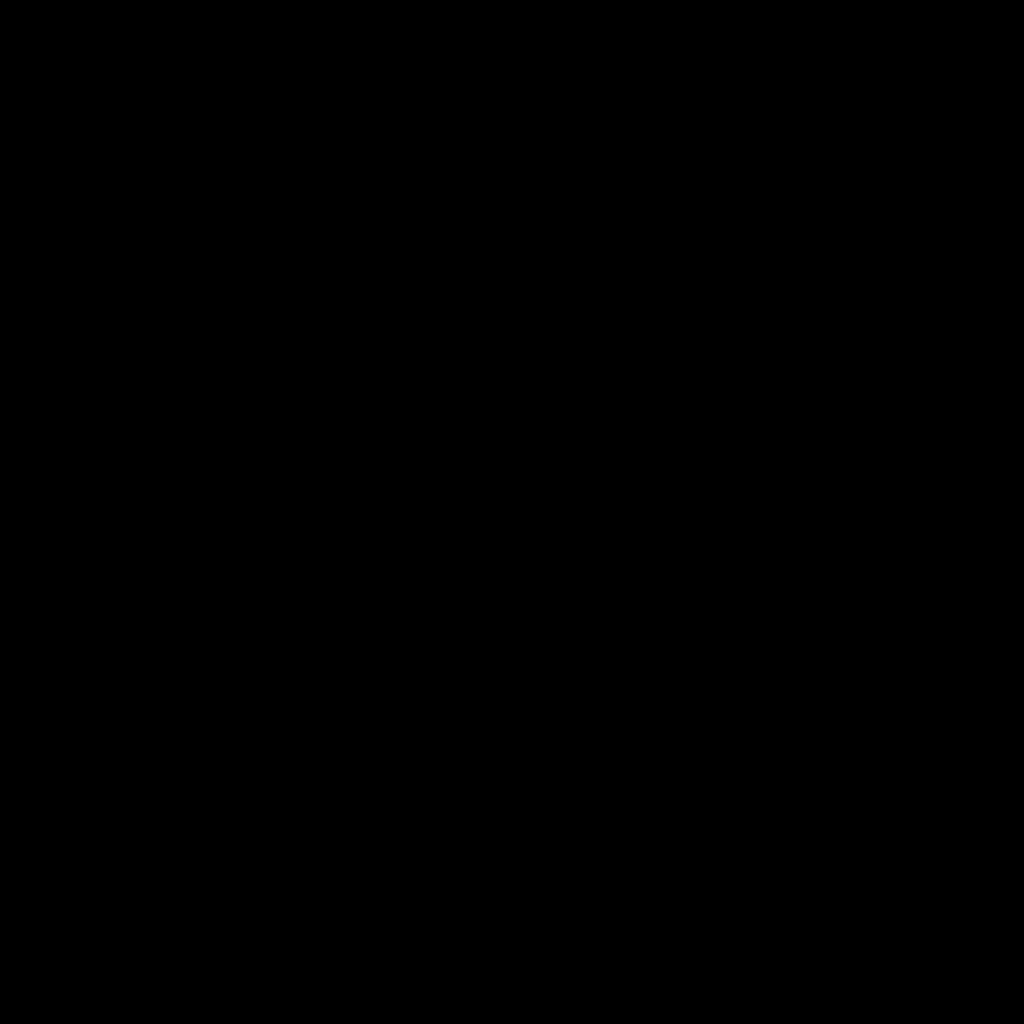

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 89%|████████▉ | 89/100 [09:18<01:09,  6.34s/it]

Loss: 0.19632475078105927

0: 288x640 32 tooths, 8.3ms
Speed: 2.1ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


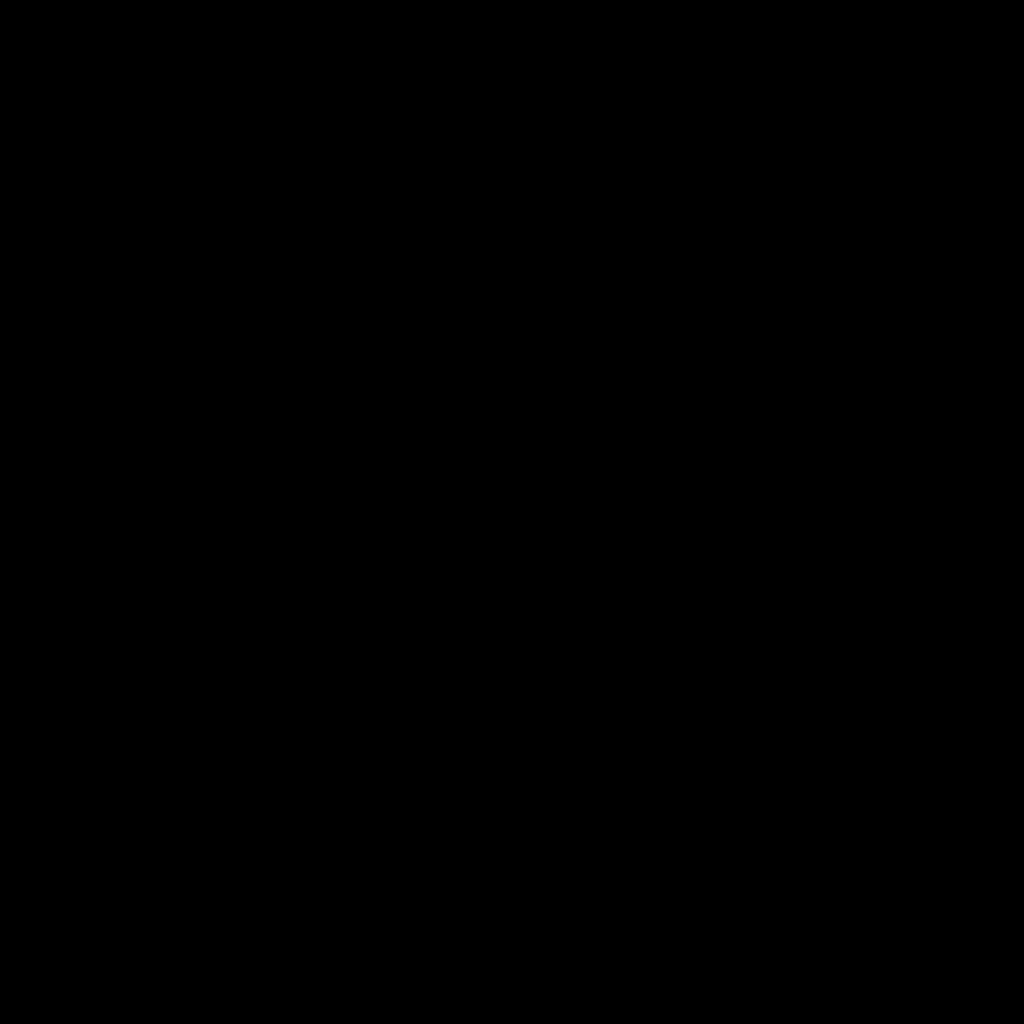

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 90%|█████████ | 90/100 [09:25<01:07,  6.79s/it]

Loss: 0.20845364034175873

0: 288x640 32 tooths, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


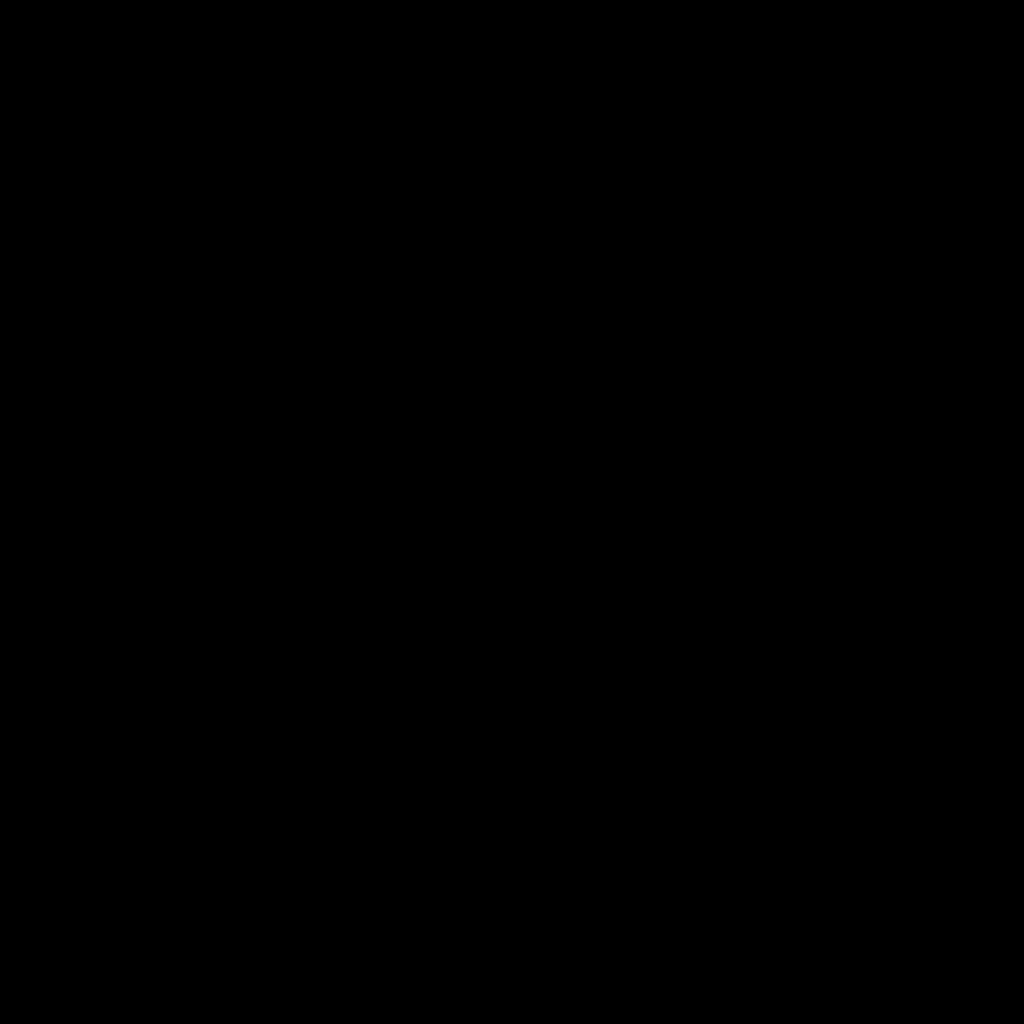

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 91%|█████████ | 91/100 [09:32<01:00,  6.69s/it]

Loss: 0.1857999712228775

0: 288x640 30 tooths, 11.8ms
Speed: 2.6ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


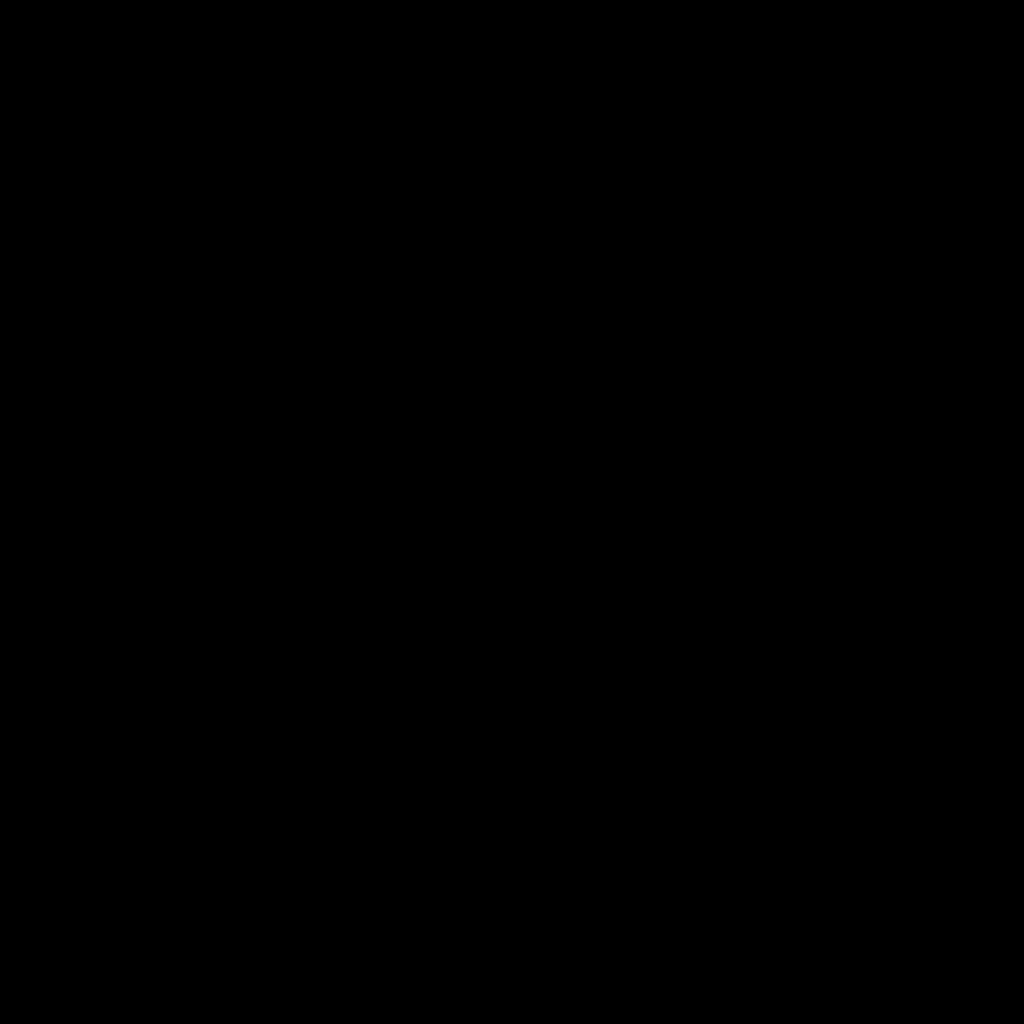

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 92%|█████████▏| 92/100 [09:39<00:55,  6.93s/it]

Loss: 0.22499330341815948

0: 288x640 20 tooths, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


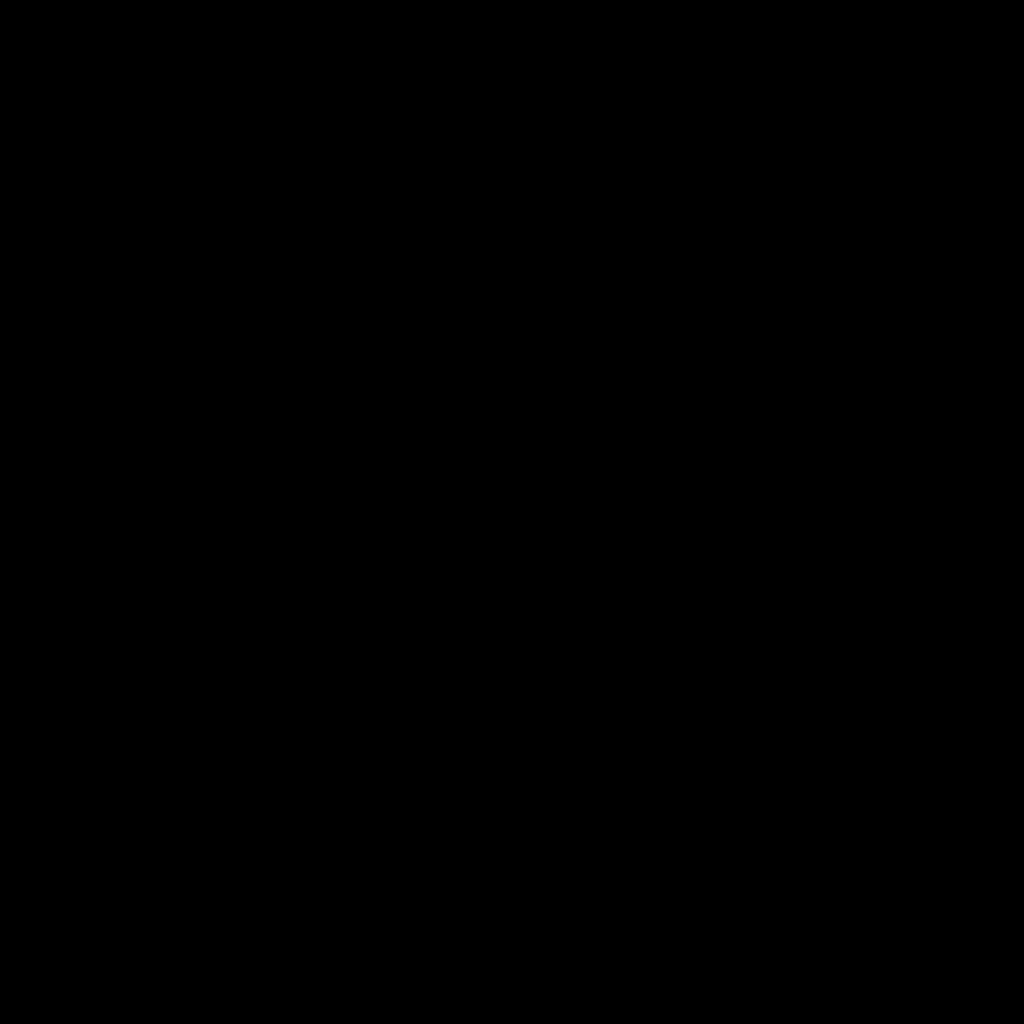

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 93%|█████████▎| 93/100 [09:44<00:43,  6.14s/it]

Loss: 0.12337560206651688

0: 288x640 32 tooths, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


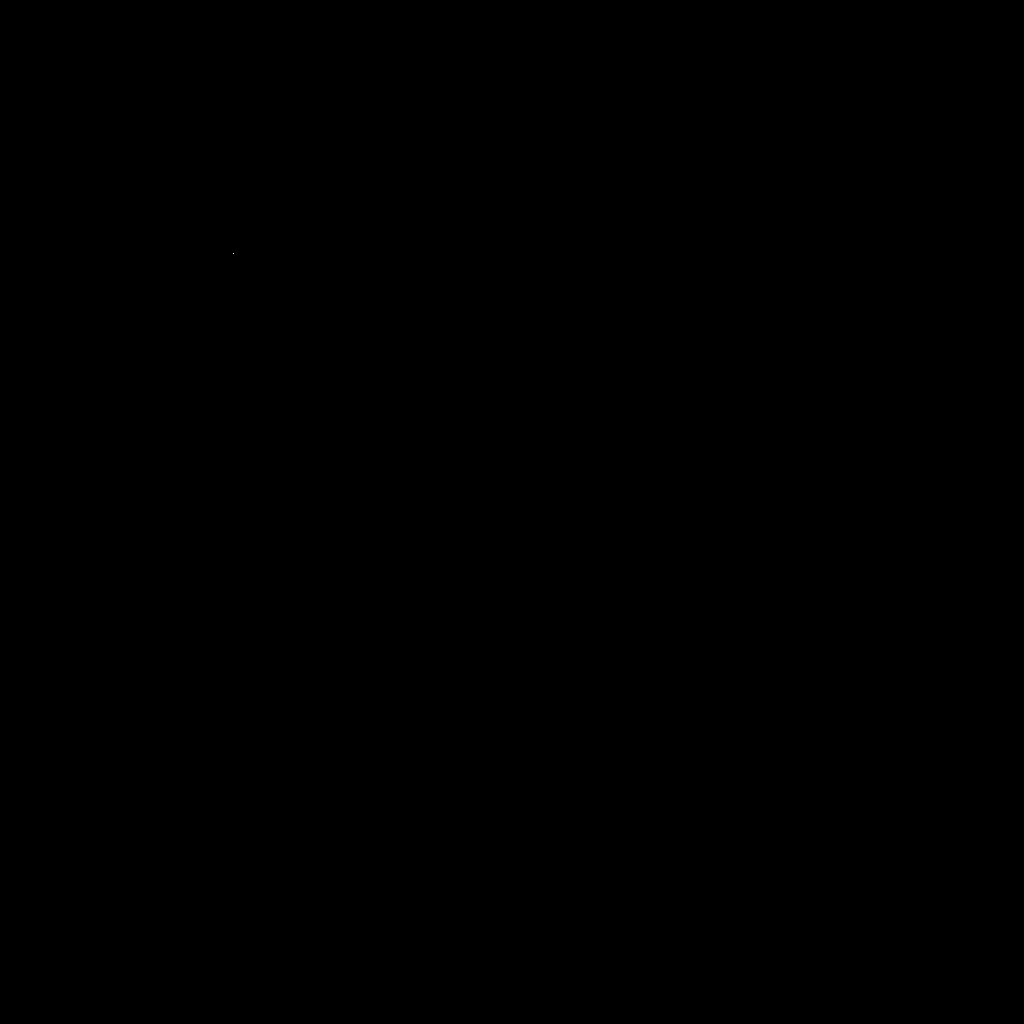

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 94%|█████████▍| 94/100 [09:51<00:39,  6.64s/it]

Loss: 0.2564395070075989

0: 288x640 31 tooths, 7.8ms
Speed: 2.3ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


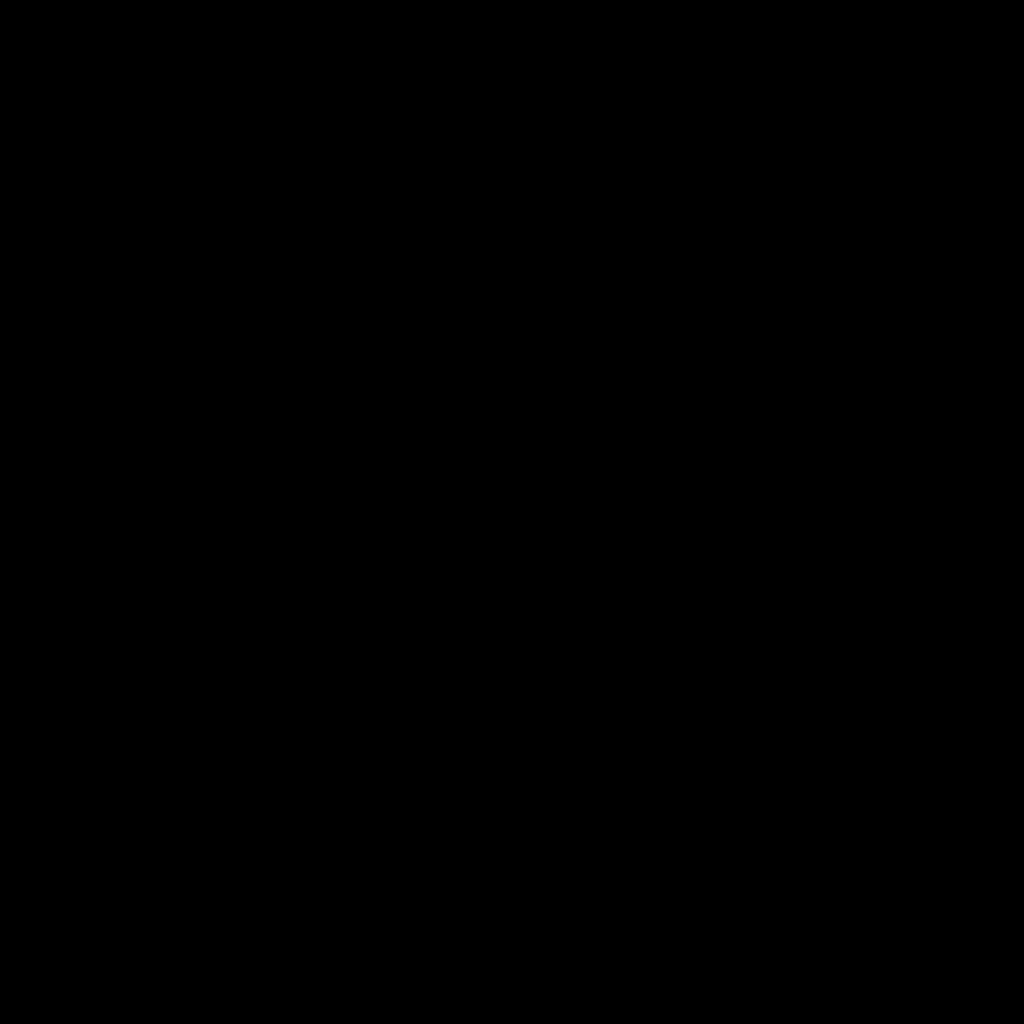

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 95%|█████████▌| 95/100 [09:58<00:32,  6.49s/it]

Loss: 0.20368295907974243

0: 288x640 29 tooths, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


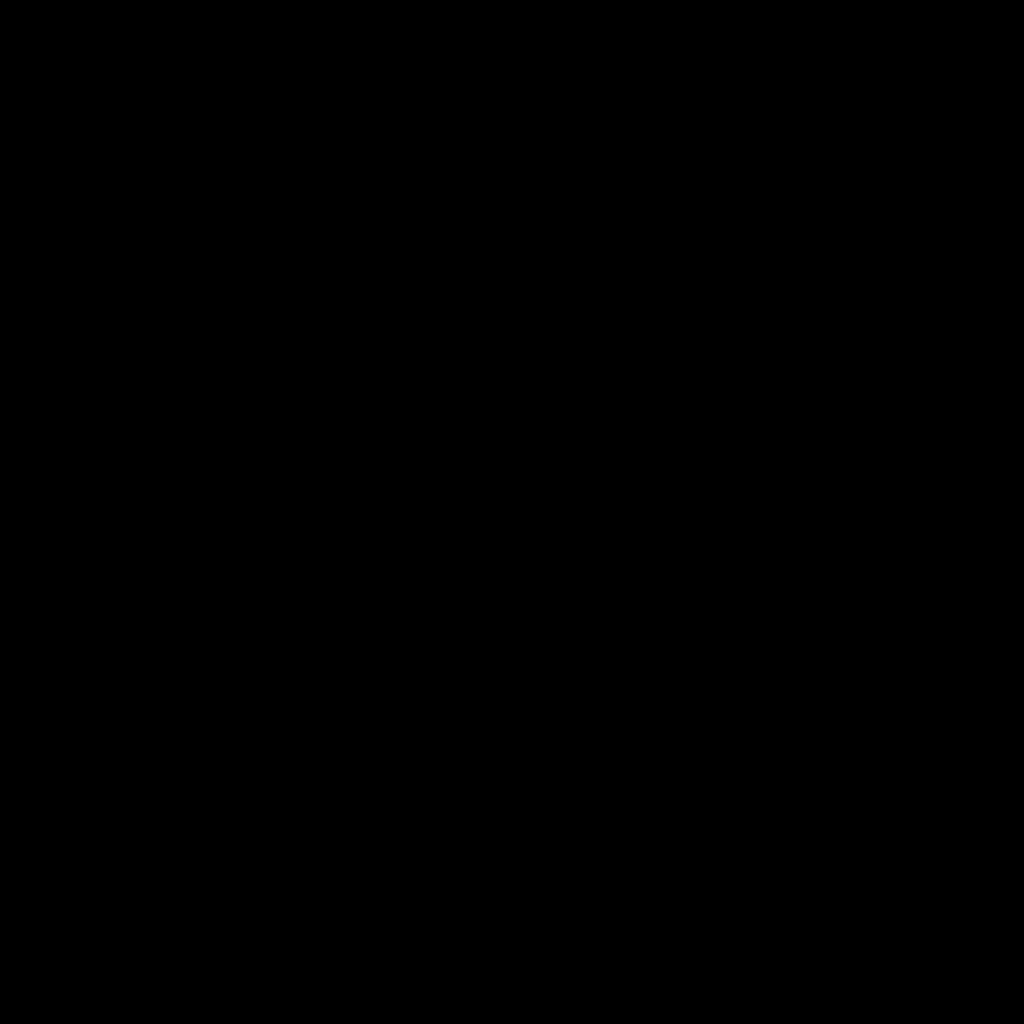

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 96%|█████████▌| 96/100 [10:05<00:26,  6.75s/it]

Loss: 0.23700128495693207

0: 288x640 32 tooths, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


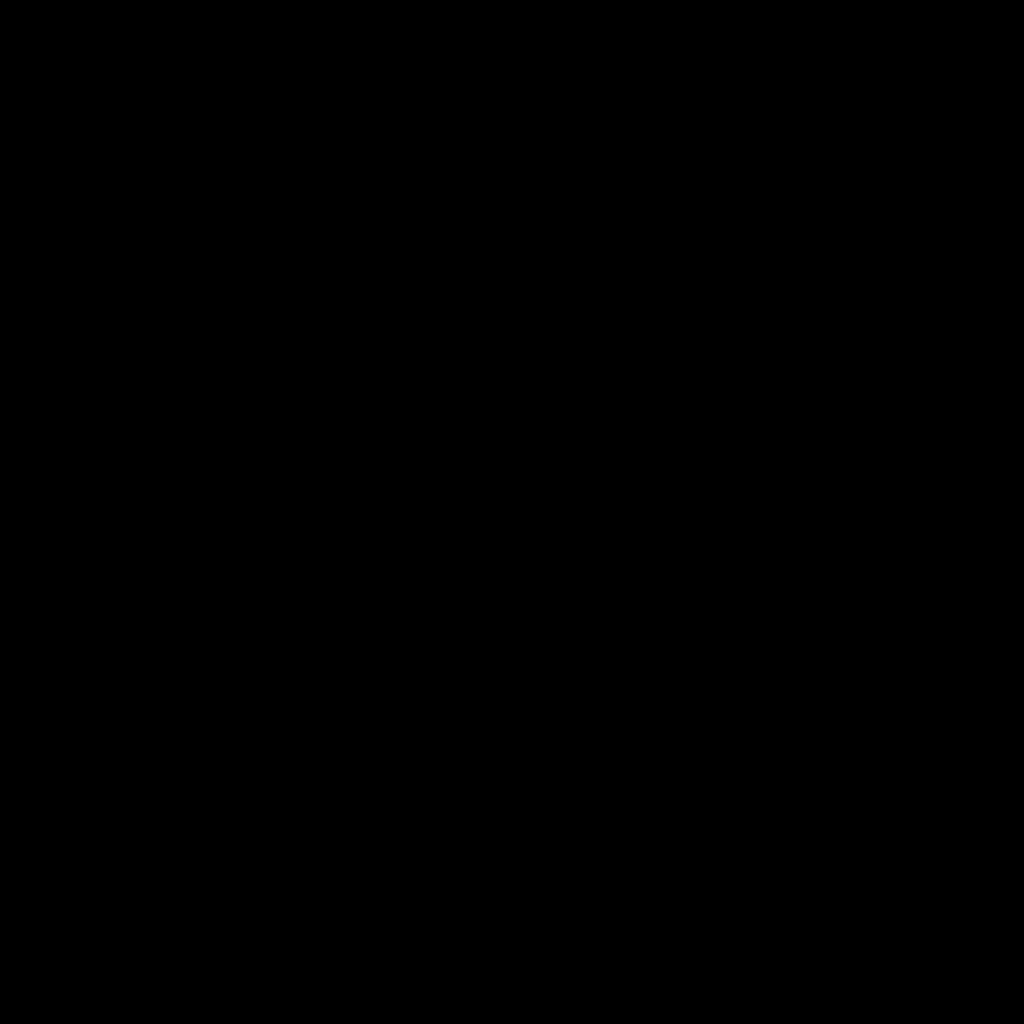

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 97%|█████████▋| 97/100 [10:11<00:19,  6.65s/it]

Loss: 0.20845364034175873

0: 288x640 32 tooths, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


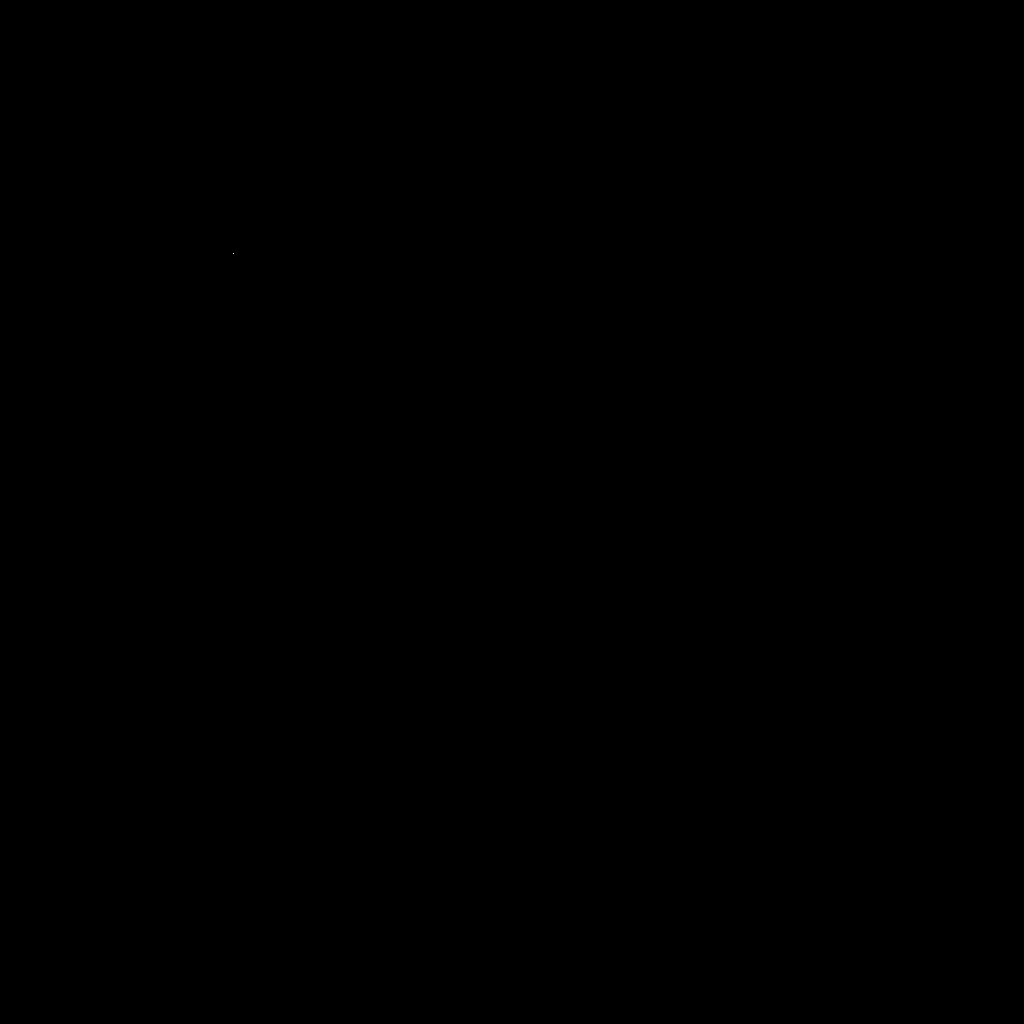

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 98%|█████████▊| 98/100 [10:19<00:14,  7.03s/it]

Loss: 0.2564395070075989

0: 288x640 21 tooths, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


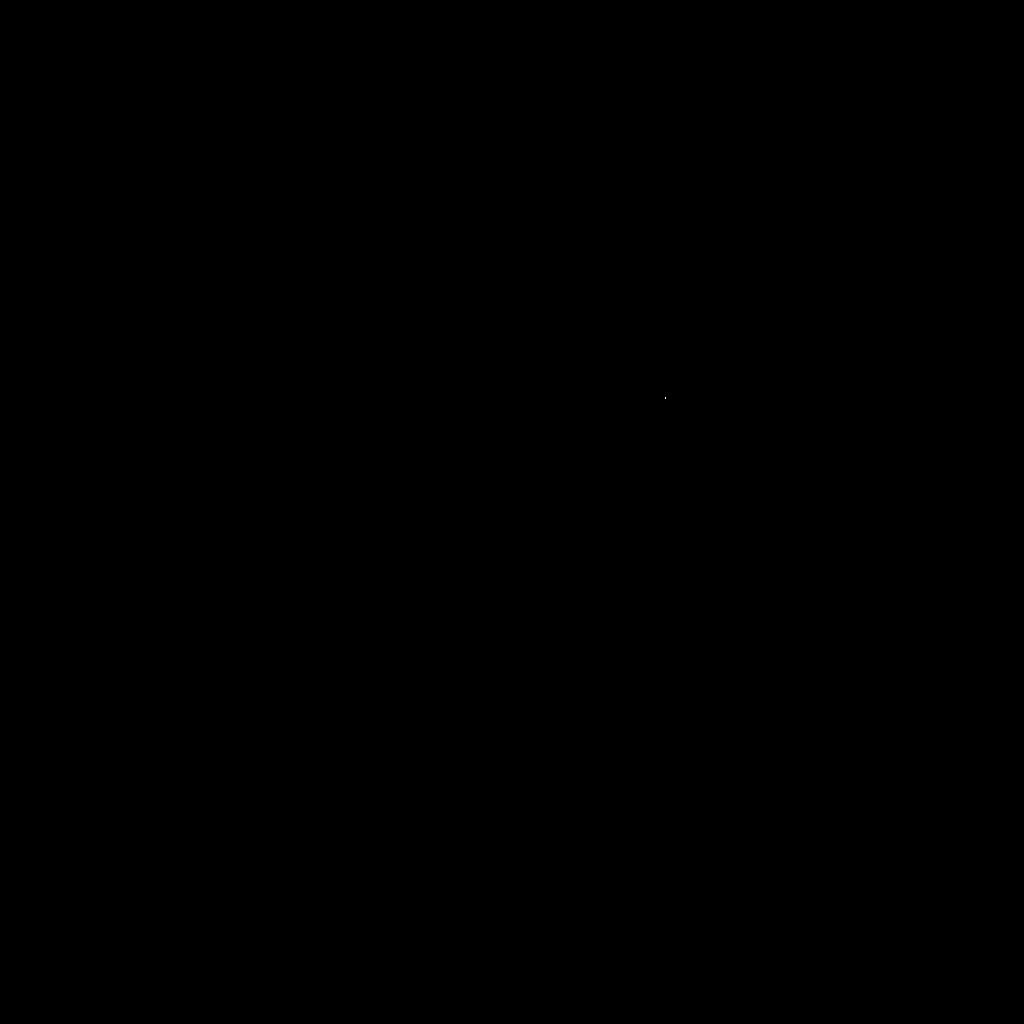

Max, min in prediction tensor(1., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


 99%|█████████▉| 99/100 [10:24<00:06,  6.24s/it]

Loss: 0.1074519157409668

0: 288x640 30 tooths, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)
Full mask shape (1, 1024, 1024)


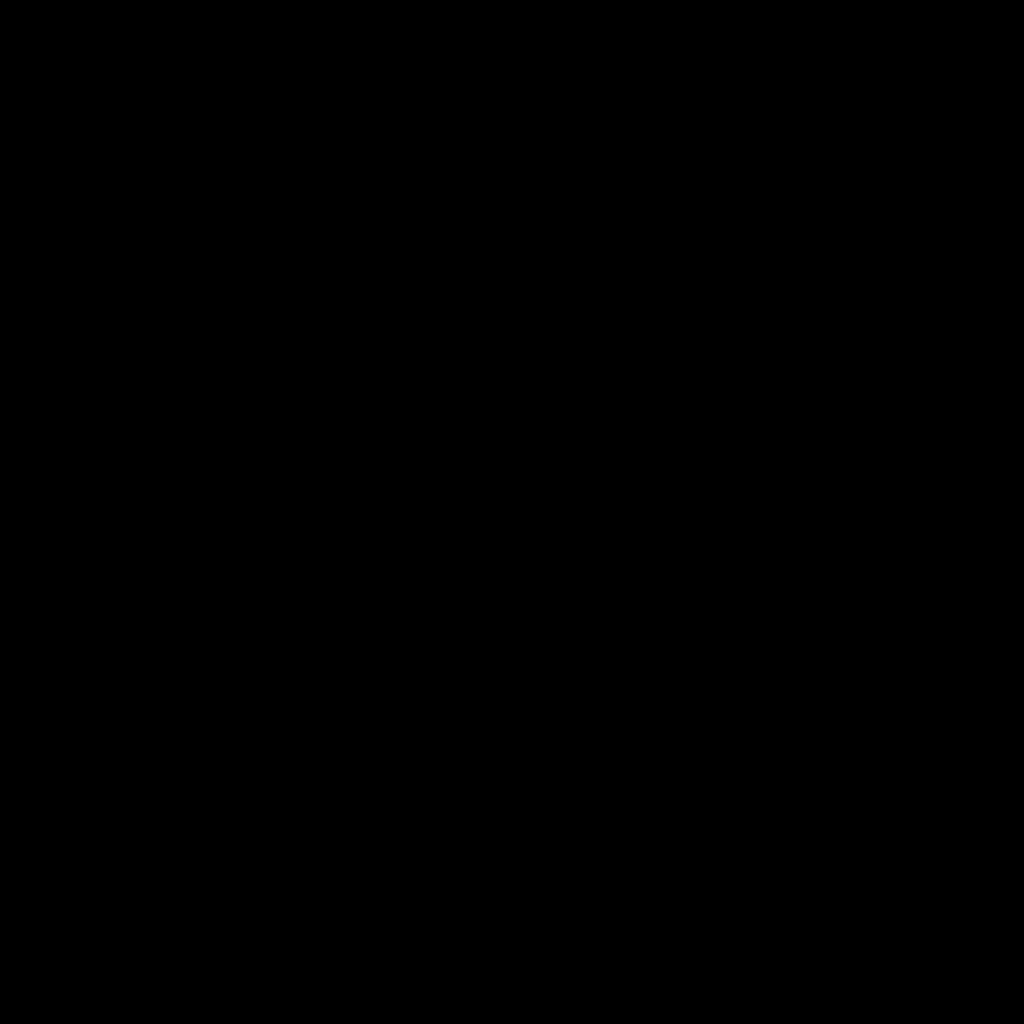

Max, min in prediction tensor(0., grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)
Max, min in gt tensor(1.) tensor(0.)


100%|██████████| 100/100 [10:31<00:00,  6.32s/it]

Loss: 0.22330224514007568


In [48]:
from ultralytics import YOLO
from torch.nn.functional import threshold, normalize
from tqdm import tqdm
import random
import gc
import torch
from segment_anything import sam_model_registry

sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters())
loss_fn = torch.nn.MSELoss()

gc.collect()
torch.cuda.empty_cache()

yolo_model = YOLO("/content/drive/MyDrive/DentalImages/TrainingCheckpoints/best_yolov8.pt")
EPOCHS = 100
MODEL_SAVE_PATH = '/content/SAM'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam_model.to(device)
yolo_model.to(device)

#Training loop

for _ in tqdm(range(EPOCHS)):
  random_select = random.randint(0,87)

  #The weird indexing is meant to add the batch dimension
  image = x_train[random_select:random_select+1].copy()
  yolo_image = x_train_yolo[random_select].copy()
  gt_mask = y_train[random_select:random_select+1].copy()

  image = image.astype(np.float32)
  image /= 255.0
  image = torch.from_numpy(image)

  image = image.to(device)


  with torch.no_grad():
    image_embedding = sam_model.image_encoder(image)
    results = yolo_model.predict(yolo_image)

    boxes = results[0].boxes.xywhn
    boxes = torch.Tensor.cpu(boxes)
    box_list = []
    for box in boxes:
      x1, y1, x2, y2 = get_fixed_coordinates(box,image[0,0,:,:])
      box_list.append([x1, y1, x2, y2])
    if len(box_list) == 0:
      continue
    box_tensor = torch.tensor(box_list)

    box_tensor = box_tensor.to(device)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
              points=None,
              boxes=box_tensor,
              masks=None,
          )

  low_res_masks, iou_predictions = sam_model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
  )



  upscaled_masks = sam_model.postprocess_masks(low_res_masks, (1024,1024),(1024,1024)).to("cpu")

  binary_mask = normalize(threshold(upscaled_masks, 0.0, 0)).to("cpu")
  # print("Mask shape",gt_mask.shape,"original_shape",image.shape,"yolo_shape", yolo_image.shape)
  full_mask = torch.sum(binary_mask, axis=0)
  copy = full_mask.clone()
  copy = copy.detach().numpy()
  copy = copy*255
  copy = copy.astype(np.uint8)
  print("Full mask shape",copy.shape)
  cv2_imshow(np.reshape(copy,(1024,1024)))

  # print("GENERATED MASK", binary_mask.shape)
  # cv2_imshow((binary_mask[0,0,:,:].detach().numpy()*255).astype(np.uint8))
  gt_mask = gt_mask.astype(np.float32)
  gt_mask /= 255.0
  gt_mask = torch.from_numpy(gt_mask)
  print("Max, min in prediction",torch.max(full_mask), torch.min(full_mask))
  print("Max, min in gt",torch.max(gt_mask), torch.min(gt_mask))
  # print("GT Mask", gt_mask.shape)
  # cv2_imshow((gt_mask[4,0,:,:].numpy()*255).astype(np.uint8))

  loss = loss_fn(full_mask, gt_mask)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  print("Loss:",loss.item())
torch.save(sam_model, MODEL_SAVE_PATH)


0: 288x640 31 tooths, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)
masks, boxes torch.Size([31, 3, 1024, 1024]) torch.Size([31, 4])
(1024, 1024) 765 0


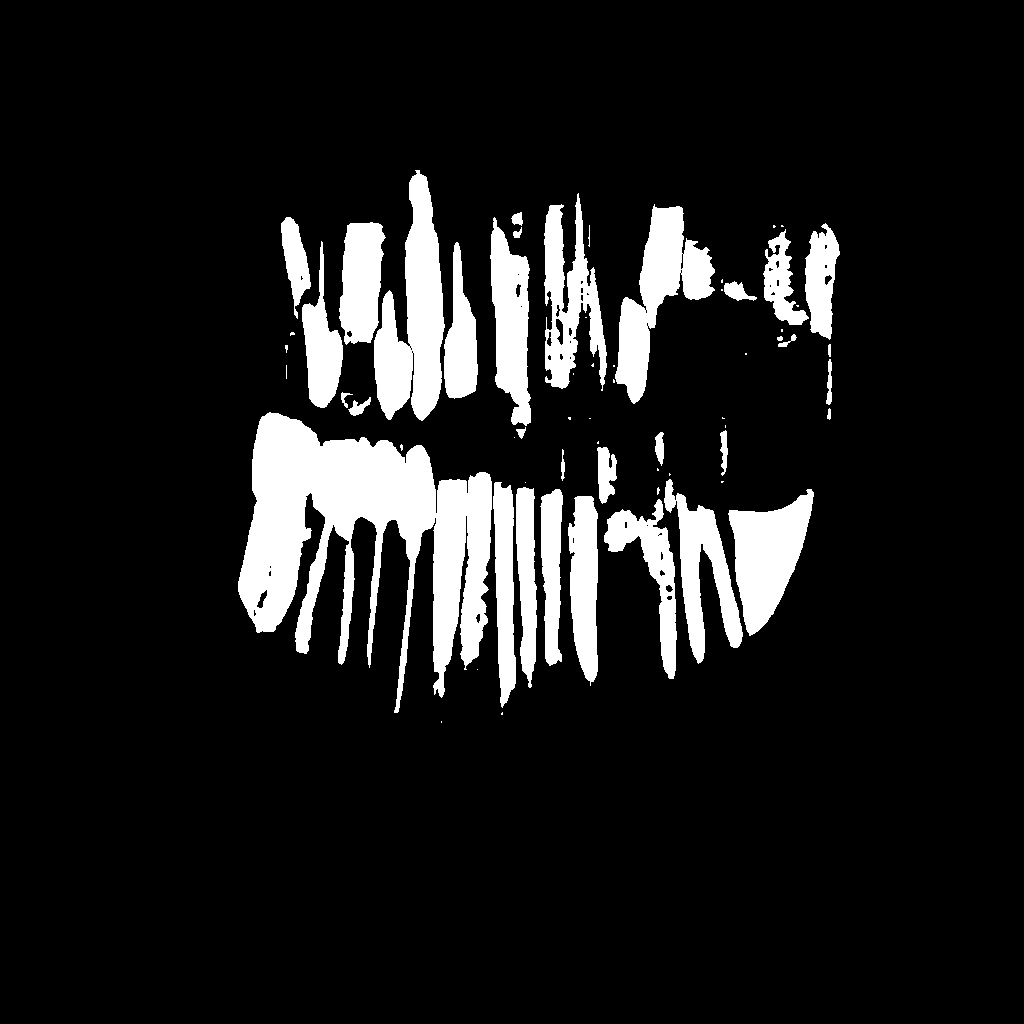

In [ ]:
from segment_anything import SamPredictor
from google.colab.patches import cv2_imshow
# loaded_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')

# loaded_model = torch.load(MODEL_SAVE_PATH)
IMAGE_NUMBER = 1
test_image = x_val[IMAGE_NUMBER]
test_image_yolo = x_val_yolo[IMAGE_NUMBER]

mask_predictor = SamPredictor(loaded_model)
mask_predictor.set_image(test_image)

results = yolo_model.predict(yolo_image)

boxes = results[0].boxes.xywhn
boxes = torch.Tensor.cpu(boxes)
box_list = []
for box in boxes:
  x1, y1, x2, y2 = get_fixed_coordinates(box,test_image)
  box_list.append([x1, y1, x2, y2])
boxes = np.array(box_list)

input_boxes = torch.tensor(boxes, device=mask_predictor.device)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(input_boxes, test_image.shape[:2])
masks, iou_predictions, low_res_masks = mask_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True
)
print("masks, boxes",masks.shape,transformed_boxes.shape)

masks = torch.Tensor.cpu(masks).numpy()
masks = masks[:,2,:,:]
masks = masks*255
masks = masks.astype(np.uint8)

full_mask = np.sum(masks,axis=0)

full_mask = np.reshape(full_mask,(1024,1024))
print(full_mask.shape, np.max(full_mask), np.min(full_mask))
cv2_imshow(full_mask)
